## 라이브러리 불러오기

In [1]:
import sys
import pandas as pd
import numpy as np

import optuna  # 파라미터 튜닝
import shap
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from mlxtend.regressor import StackingCVRegressor

from pycaret.regression import * 
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, mean_absolute_error

from scipy import stats
from scipy.stats import norm, skew

from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns

## Experiment 5
- 이상의 비율을 5개로 split하여 5개의 데이터셋을 학습시켜 앙상블

In [2]:
train = pd.read_csv('C:/Users/cdbre/Desktop/MyLife/DACON/data/teacher_train.csv')
real_test = pd.read_csv('C:/Users/cdbre/Desktop/MyLife/DACON/data/test.csv')

In [3]:
train = train[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR','Y_LABEL','Label','Score_0']]
real_test = real_test[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]

In [4]:
# Label 기준으로 split
train, test = train_test_split(train, stratify=train.Label, test_size=0.2, random_state=42)

In [5]:
# YEAR 칼럼 LabelEncoding
le = LabelEncoder()
train.YEAR = le.fit_transform(train.YEAR)
test.YEAR = le.transform(test.YEAR)
real_test.YEAR = le.transform(real_test.YEAR)

In [6]:
numeric_feats = []

for col in train.columns:
    if col not in ['YEAR','Score_0','Label','Y_LABEL']:
        numeric_feats.append(col)

# Check the skew of all numerical features
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



Skew
CR           53.601677
ANONYMOUS_1  32.396129
FE           22.304026
CU           19.550846
NI           17.997284
V40          14.774742
PQINDEX      10.164341
ANONYMOUS_2   8.101399
MO            2.853648
ZN            0.228219

In [7]:
skewness = skewness[abs(skewness.Skew) > 0.75]

skewed_features = skewness.index

# log 변환
for col in skewed_features:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])
    real_test[col] = np.log1p(real_test[col])

In [8]:
print(train.Y_LABEL.value_counts())
print(test.Y_LABEL.value_counts())
print(train.Label.value_counts())
print(test.Label.value_counts())

0    10325
1      951
Name: Y_LABEL, dtype: int64
0    2567
1     252
Name: Y_LABEL, dtype: int64
0    10526
1      750
Name: Label, dtype: int64
0    2631
1     188
Name: Label, dtype: int64


In [9]:
750 / (750 + 10526)  # 약 6.65 % 이상 여부

0.06651294785384888

In [10]:
188 / (188 + 2631)

0.06669031571479248

In [11]:
confusion_matrix(train.Label, train.Y_LABEL)

array([[10325,   201],
       [    0,   750]], dtype=int64)

In [12]:
confusion_matrix(test.Label, test.Y_LABEL)

array([[2567,   64],
       [   0,  188]], dtype=int64)

In [13]:
train.shape

(11276, 14)

## Labeling, Metric

In [14]:
def labeling(prob, threshold=0.5):
    return 0 if prob > threshold else 1

def competition_metric(pred, org):
    return round(f1_score(pred, org),4), round(f1_score(pred, org, average='macro'),4)

## DownSample Dataset

In [15]:
train0_index_list = []
train0 = train[train.Score_0 >= 0.5].reset_index(drop=True)
train1 = train[train.Score_0 <= 0.5].reset_index(drop=True)

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

for index, train0_index in kf.split(train0):
    train0_index_list.append(train0_index)

In [16]:
train0

ANONYMOUS_1  YEAR        FE  ANONYMOUS_2    ZN       V40   PQINDEX  \
0         7.822044     7  4.248495     5.303305    18  4.894101  5.817111   
1         7.784473     1  5.703782     6.311735   239  4.767289  4.317488   
2         7.650645     6  1.945910     5.303305    10  4.913390  2.772589   
3         8.860925    10  3.044522     5.303305  1113  4.085976  2.708050   
4         8.248267     3  4.836282     5.303305    19  5.182907  6.721426   
...            ...   ...       ...          ...   ...       ...       ...   
10521    11.269822    10  2.890372     5.303305    35  4.905275  2.833213   
10522     7.625107     6  3.891820     5.303305    51  5.025195  5.241747   
10523     8.979920    10  4.499810     7.378384  1170  4.177459  4.343805   
10524     7.640123     3  6.775366     5.303305    20  5.200705  7.449498   
10525     8.851234    11  5.176150     5.303305    14  4.930148  6.594413   

             NI        CU       MO        CR  Y_LABEL  Label  Score_0  
0      0.000000  0.000000  0.00000  0.693147        0      0   0.9901  
1      0.693147  2.564949  1.94591  1.098612        0      0   0.9253  
2      0.000000  1.098612  0.00000  0.000000        0      0   0.9823  
3      0.000000  2.079442  0.00000  0.000000        0      0   0.9906  
4      0.000000  0.693147  0.00000  1.098612        0      0   0.9751  
...         ...       ...      ...       ...      ...    ...      ...  
10521  0.000000  0.693147  0.00000  0.000000        0      0   0.9662  
10522  0.000000  0.000000  0.00000  0.000000        0      0   0.9984  
10523  0.000000  2.564949  0.00000  0.000000        0      0   0.9885  
10524  1.609438  1.791759  0.00000  2.772589        0      0   0.9794  
10525  0.000000  0.000000  0.00000  1.098612        0      0   0.9893  

[10526 rows x 14 columns]

In [16]:
train01 = train0[train0.index.isin(train0_index_list[0])]
train02 = train0[train0.index.isin(train0_index_list[1])]
train03 = train0[train0.index.isin(train0_index_list[2])]
train04 = train0[train0.index.isin(train0_index_list[3])]
train05 = train0[train0.index.isin(train0_index_list[4])]

In [17]:
train_df1 = pd.concat([train01, train1], axis=0).reset_index(drop=True)
train_df2 = pd.concat([train02, train1], axis=0).reset_index(drop=True)
train_df3 = pd.concat([train03, train1], axis=0).reset_index(drop=True)
train_df4 = pd.concat([train04, train1], axis=0).reset_index(drop=True)
train_df5 = pd.concat([train05, train1], axis=0).reset_index(drop=True)

In [18]:
X_train1 = train_df1[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train1 = train_df1['Score_0']

X_train2 = train_df2[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train2 = train_df2['Score_0']

X_train3 = train_df3[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train3 = train_df3['Score_0']

X_train4 = train_df4[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train4 = train_df4['Score_0']

X_train5 = train_df5[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_train5 = train_df5['Score_0']

X_test = test[['ANONYMOUS_1','YEAR','FE','ANONYMOUS_2','ZN','V40','PQINDEX','NI','CU','MO','CR']]
y_test = test[['Y_LABEL', 'Score_0']]

**Use "Optuna" for hyperparameter tuning**

## Dataset 1

### Decision Tree

In [28]:
def objectiveDT(trial, X_train1,y_train1, X_test, y_test):
    
    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'random_state': 42}

    #학습모델 생성
    model = DecisionTreeRegressor(**param)
    model.fit(X_train1, y_train1)

    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test.Score_0, pred)
    
    return mae

In [29]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyDT=optuna.create_study(direction='minimize')

# n_trials 지정
studyDT.optimize(lambda trial: objectiveDT(trial, X_train1, y_train1, X_test, y_test), n_trials=100) 

print('study.best_params:', studyDT.best_trial.value)
print('Number of finished trials:', len(studyDT.trials))
print('Best trial:', studyDT.best_trial.params)
print('study.best_params:', studyDT.best_params)

[I 2022-12-08 21:10:08,830] A new study created in memory with name: no-name-873b60d3-2053-4063-b38d-37eaf4339874
[I 2022-12-08 21:10:08,854] Trial 0 finished with value: 0.2461407314167877 and parameters: {'max_depth': 12, 'max_leaf_nodes': 448}. Best is trial 0 with value: 0.2461407314167877.
[I 2022-12-08 21:10:08,870] Trial 1 finished with value: 0.22455782094673926 and parameters: {'max_depth': 6, 'max_leaf_nodes': 237}. Best is trial 1 with value: 0.22455782094673926.
[I 2022-12-08 21:10:08,878] Trial 2 finished with value: 0.22087350188169513 and parameters: {'max_depth': 7, 'max_leaf_nodes': 893}. Best is trial 2 with value: 0.22087350188169513.
[I 2022-12-08 21:10:08,894] Trial 3 finished with value: 0.2243119768477517 and parameters: {'max_depth': 5, 'max_leaf_nodes': 563}. Best is trial 2 with value: 0.22087350188169513.
[I 2022-12-08 21:10:08,902] Trial 4 finished with value: 0.22167493322480403 and parameters: {'max_depth': 9, 'max_leaf_nodes': 39}. Best is trial 2 with va

[I 2022-12-08 21:10:09,570] Trial 42 finished with value: 0.22087350188169513 and parameters: {'max_depth': 7, 'max_leaf_nodes': 239}. Best is trial 2 with value: 0.22087350188169513.
[I 2022-12-08 21:10:09,586] Trial 43 finished with value: 0.2221126959385233 and parameters: {'max_depth': 7, 'max_leaf_nodes': 72}. Best is trial 2 with value: 0.22087350188169513.
[I 2022-12-08 21:10:09,603] Trial 44 finished with value: 0.22455782094673926 and parameters: {'max_depth': 6, 'max_leaf_nodes': 374}. Best is trial 2 with value: 0.22087350188169513.
[I 2022-12-08 21:10:09,627] Trial 45 finished with value: 0.2261570364317398 and parameters: {'max_depth': 8, 'max_leaf_nodes': 925}. Best is trial 2 with value: 0.22087350188169513.
[I 2022-12-08 21:10:09,646] Trial 46 finished with value: 0.24512708999326402 and parameters: {'max_depth': 13, 'max_leaf_nodes': 706}. Best is trial 2 with value: 0.22087350188169513.
[I 2022-12-08 21:10:09,667] Trial 47 finished with value: 0.23062833148260548 and 

[I 2022-12-08 21:10:10,360] Trial 84 finished with value: 0.22087350188169513 and parameters: {'max_depth': 7, 'max_leaf_nodes': 162}. Best is trial 65 with value: 0.2206429550332804.
[I 2022-12-08 21:10:10,375] Trial 85 finished with value: 0.22455782094673926 and parameters: {'max_depth': 6, 'max_leaf_nodes': 118}. Best is trial 65 with value: 0.2206429550332804.
[I 2022-12-08 21:10:10,391] Trial 86 finished with value: 0.2261570364317398 and parameters: {'max_depth': 8, 'max_leaf_nodes': 534}. Best is trial 65 with value: 0.2206429550332804.
[I 2022-12-08 21:10:10,408] Trial 87 finished with value: 0.22087350188169513 and parameters: {'max_depth': 7, 'max_leaf_nodes': 298}. Best is trial 65 with value: 0.2206429550332804.
[I 2022-12-08 21:10:10,431] Trial 88 finished with value: 0.22455782094673926 and parameters: {'max_depth': 6, 'max_leaf_nodes': 317}. Best is trial 65 with value: 0.2206429550332804.
[I 2022-12-08 21:10:10,448] Trial 89 finished with value: 0.22087350188169513 and

study.best_params: 0.22011241749507138
Number of finished trials: 100
Best trial: {'max_depth': 7, 'max_leaf_nodes': 38}
study.best_params: {'max_depth': 7, 'max_leaf_nodes': 38}


In [30]:
param_dt = studyDT.best_params

clf_dt = DecisionTreeRegressor(**param_dt, random_state=42)

In [34]:
clf_dt.fit(X_train1, y_train1)

pred_test_dt = clf_dt.predict(X_test)

y_test['pred_dt'] = [labeling(pred, threshold=0.6) for pred in pred_test_dt]

print('MAE :', round(mean_absolute_error(pred_test_dt, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_dt, y_test.Y_LABEL))

MAE : 0.2201
F1 Score : 0.2078
Macro F1 Score : 0.5579 

[[2293  191]
 [ 274   61]]


In [35]:
optuna.visualization.plot_param_importances(studyDT)

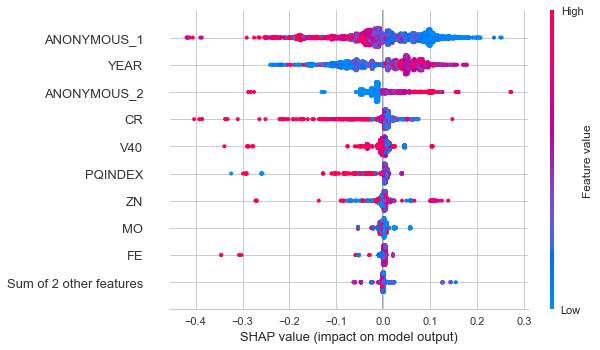

In [37]:
explainer_dt = shap.Explainer(clf_dt)
shap_values_dt = explainer_dt(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_dt)

In [38]:
fi_dt = pd.DataFrame(clf_dt.feature_importances_, index=X_train1.columns, columns=['feature_importance_dt']).sort_values('feature_importance_dt', ascending=False)
fi_dt

feature_importance_dt
ANONYMOUS_1               0.289211
YEAR                      0.233278
CR                        0.106675
ANONYMOUS_2               0.090888
V40                       0.080660
ZN                        0.065957
PQINDEX                   0.055415
FE                        0.032816
CU                        0.022053
MO                        0.012881
NI                        0.010165

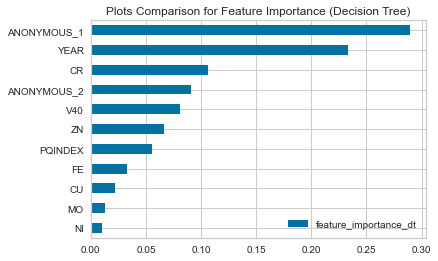

In [39]:
fi_dt[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Decision Tree)')
plt.show()

### SVR

In [47]:
def objectiveSVR(trial, X_train1,y_train1, X_test, y_test):
    
    param = {
        'C': trial.suggest_loguniform('C', 0.3, 10.0),
        'degree': trial.suggest_int('degree', 2, 7),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 0.01),
        'epsilon': trial.suggest_float('epsilon', 0.05, 0.5),
    }

    #학습모델 생성
    model = SVR(**param)
    model.fit(X_train1,y_train1)

    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test.Score_0, pred)
    
    return mae

In [48]:
# MAE가 최소가 되는 방향으로 학습을 진행
studySVR=optuna.create_study(direction='minimize')

# n_trials 지정
studySVR.optimize(lambda trial: objectiveSVR(trial, X_train1, y_train1, X_test, y_test), n_trials=100) 

print('study.best_params:', studySVR.best_trial.value)
print('Number of finished trials:', len(studySVR.trials))
print('Best trial:', studySVR.best_trial.params)
print('study.best_params:', studySVR.best_params)

[I 2022-12-08 21:32:41,383] A new study created in memory with name: no-name-4a9d4cf5-c9d1-4749-afdb-3ccc95ec2e71
[I 2022-12-08 21:32:42,052] Trial 0 finished with value: 0.3485559635829867 and parameters: {'C': 0.760217883121436, 'degree': 3, 'gamma': 0.0012764576104696544, 'epsilon': 0.3557944641935426}. Best is trial 0 with value: 0.3485559635829867.
[I 2022-12-08 21:32:43,224] Trial 1 finished with value: 0.1671274272485248 and parameters: {'C': 2.84629020285804, 'degree': 5, 'gamma': 0.004666615254899415, 'epsilon': 0.08045872346232295}. Best is trial 1 with value: 0.1671274272485248.
[I 2022-12-08 21:32:44,019] Trial 2 finished with value: 0.19900692440847395 and parameters: {'C': 0.3711104213913358, 'degree': 4, 'gamma': 0.00153622745189261, 'epsilon': 0.16677987906065517}. Best is trial 1 with value: 0.1671274272485248.
[I 2022-12-08 21:32:45,114] Trial 3 finished with value: 0.2734718322980252 and parameters: {'C': 6.089720259323887, 'degree': 4, 'gamma': 0.0075953384463676, '

[I 2022-12-08 21:33:14,989] Trial 32 finished with value: 0.11366641635869985 and parameters: {'C': 0.3732464703570174, 'degree': 5, 'gamma': 0.0020119778050664296, 'epsilon': 0.05088891669376016}. Best is trial 32 with value: 0.11366641635869985.
[I 2022-12-08 21:33:15,936] Trial 33 finished with value: 0.1502897504358238 and parameters: {'C': 0.389909828877512, 'degree': 5, 'gamma': 0.0020436741668920706, 'epsilon': 0.10228875641107041}. Best is trial 32 with value: 0.11366641635869985.
[I 2022-12-08 21:33:17,033] Trial 34 finished with value: 0.11572254331787765 and parameters: {'C': 0.3551270932232511, 'degree': 4, 'gamma': 0.0031646287232195256, 'epsilon': 0.05124098808396426}. Best is trial 32 with value: 0.11366641635869985.
[I 2022-12-08 21:33:18,057] Trial 35 finished with value: 0.1328870210053166 and parameters: {'C': 0.3059338052871696, 'degree': 4, 'gamma': 0.002954860045152571, 'epsilon': 0.07771952496986452}. Best is trial 32 with value: 0.11366641635869985.
[I 2022-12-0

[I 2022-12-08 21:33:50,550] Trial 64 finished with value: 0.17179650953123685 and parameters: {'C': 0.5033412739222444, 'degree': 5, 'gamma': 0.0035655453244363543, 'epsilon': 0.12473706381422477}. Best is trial 32 with value: 0.11366641635869985.
[I 2022-12-08 21:33:51,851] Trial 65 finished with value: 0.12981458151971698 and parameters: {'C': 0.42548597961142154, 'degree': 5, 'gamma': 0.0036985296622033498, 'epsilon': 0.06917925897386644}. Best is trial 32 with value: 0.11366641635869985.
[I 2022-12-08 21:33:53,227] Trial 66 finished with value: 0.1576536374760581 and parameters: {'C': 0.5792426278662482, 'degree': 6, 'gamma': 0.0027225315155518454, 'epsilon': 0.10829520868053194}. Best is trial 32 with value: 0.11366641635869985.
[I 2022-12-08 21:33:54,660] Trial 67 finished with value: 0.1288715309759594 and parameters: {'C': 1.5955203375556715, 'degree': 4, 'gamma': 0.0030784905127602827, 'epsilon': 0.050007494739120126}. Best is trial 32 with value: 0.11366641635869985.
[I 2022-

[I 2022-12-08 21:34:30,364] Trial 96 finished with value: 0.12772667499028142 and parameters: {'C': 0.33347536070473077, 'degree': 4, 'gamma': 0.002108992334330277, 'epsilon': 0.07187985916873693}. Best is trial 32 with value: 0.11366641635869985.
[I 2022-12-08 21:34:31,366] Trial 97 finished with value: 0.14003948103913896 and parameters: {'C': 0.36166559880217714, 'degree': 5, 'gamma': 0.0014087958433778266, 'epsilon': 0.09102104316384901}. Best is trial 32 with value: 0.11366641635869985.
[I 2022-12-08 21:34:32,396] Trial 98 finished with value: 0.1221688731302777 and parameters: {'C': 0.43948051992775206, 'degree': 5, 'gamma': 0.0028396105394205445, 'epsilon': 0.06044697908089139}. Best is trial 32 with value: 0.11366641635869985.
[I 2022-12-08 21:34:33,484] Trial 99 finished with value: 0.11522966900492929 and parameters: {'C': 0.301364486405064, 'degree': 4, 'gamma': 0.0035026790622577396, 'epsilon': 0.05074059748139735}. Best is trial 32 with value: 0.11366641635869985.


study.best_params: 0.11366641635869985
Number of finished trials: 100
Best trial: {'C': 0.3732464703570174, 'degree': 5, 'gamma': 0.0020119778050664296, 'epsilon': 0.05088891669376016}
study.best_params: {'C': 0.3732464703570174, 'degree': 5, 'gamma': 0.0020119778050664296, 'epsilon': 0.05088891669376016}


In [50]:
param_svr = studySVR.best_params

clf_svr = SVR(**param_svr)

In [52]:
clf_svr.fit(X_train1, y_train1)

pred_test_svr = clf_svr.predict(X_test)

y_test['pred_svr'] = [labeling(pred, threshold=0.6) for pred in pred_test_svr]

print('MAE :', round(mean_absolute_error(pred_test_svr, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_svr, y_test.Y_LABEL))

MAE : 0.1137
F1 Score : 0.0275
Macro F1 Score : 0.4873 

[[2532  248]
 [  35    4]]


In [53]:
optuna.visualization.plot_param_importances(studySVR)

### Random Forest Regressor

In [55]:
def objectiveRF(trial, X_train1, y_train1, X_test, y_test):

    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),  # max_depth 제한
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),  # n_estimators 제한
    'random_state': 42}

    #학습모델 생성
    model = RandomForestRegressor(**param)
    model.fit(X_train1, y_train1)

    pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test.Score_0, pred)
    
    return mae

In [56]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyRF=optuna.create_study(direction='minimize')

# n_trials 지정
studyRF.optimize(lambda trial: objectiveRF(trial, X_train1, y_train1, X_test, y_test), n_trials=100) 

print('study.best_params:', studyRF.best_trial.value)
print('Number of finished trials:', len(studyRF.trials))
print('Best trial:', studyRF.best_trial.params)
print('study.best_params:', studyRF.best_params)

[I 2022-12-08 21:39:05,150] A new study created in memory with name: no-name-69ef3891-bd72-4b77-941b-99e1bcd0d29d
[I 2022-12-08 21:39:07,395] Trial 0 finished with value: 0.21755969068251554 and parameters: {'max_depth': 7, 'max_leaf_nodes': 788, 'n_estimators': 386}. Best is trial 0 with value: 0.21755969068251554.
[I 2022-12-08 21:39:08,558] Trial 1 finished with value: 0.22752886170329256 and parameters: {'max_depth': 3, 'max_leaf_nodes': 45, 'n_estimators': 367}. Best is trial 0 with value: 0.21755969068251554.
[I 2022-12-08 21:39:11,168] Trial 2 finished with value: 0.21712011615357857 and parameters: {'max_depth': 11, 'max_leaf_nodes': 50, 'n_estimators': 403}. Best is trial 2 with value: 0.21712011615357857.
[I 2022-12-08 21:39:14,647] Trial 3 finished with value: 0.2175834962806718 and parameters: {'max_depth': 10, 'max_leaf_nodes': 571, 'n_estimators': 428}. Best is trial 2 with value: 0.21712011615357857.
[I 2022-12-08 21:39:15,956] Trial 4 finished with value: 0.218399749061

[I 2022-12-08 21:39:54,452] Trial 38 finished with value: 0.21423897102053083 and parameters: {'max_depth': 12, 'max_leaf_nodes': 160, 'n_estimators': 66}. Best is trial 38 with value: 0.21423897102053083.
[I 2022-12-08 21:39:55,162] Trial 39 finished with value: 0.21790234607575007 and parameters: {'max_depth': 11, 'max_leaf_nodes': 604, 'n_estimators': 74}. Best is trial 38 with value: 0.21423897102053083.
[I 2022-12-08 21:39:55,333] Trial 40 finished with value: 0.22688930231880858 and parameters: {'max_depth': 3, 'max_leaf_nodes': 332, 'n_estimators': 50}. Best is trial 38 with value: 0.21423897102053083.
[I 2022-12-08 21:39:56,089] Trial 41 finished with value: 0.21391634192319678 and parameters: {'max_depth': 12, 'max_leaf_nodes': 161, 'n_estimators': 89}. Best is trial 41 with value: 0.21391634192319678.
[I 2022-12-08 21:39:56,802] Trial 42 finished with value: 0.2135391042659435 and parameters: {'max_depth': 13, 'max_leaf_nodes': 156, 'n_estimators': 84}. Best is trial 42 with 

[I 2022-12-08 21:40:42,097] Trial 76 finished with value: 0.21877319315734323 and parameters: {'max_depth': 10, 'max_leaf_nodes': 34, 'n_estimators': 125}. Best is trial 42 with value: 0.2135391042659435.
[I 2022-12-08 21:40:42,769] Trial 77 finished with value: 0.21538502932409598 and parameters: {'max_depth': 11, 'max_leaf_nodes': 186, 'n_estimators': 70}. Best is trial 42 with value: 0.2135391042659435.
[I 2022-12-08 21:40:43,238] Trial 78 finished with value: 0.21473282212467976 and parameters: {'max_depth': 13, 'max_leaf_nodes': 104, 'n_estimators': 53}. Best is trial 42 with value: 0.2135391042659435.
[I 2022-12-08 21:40:44,078] Trial 79 finished with value: 0.21627795804792707 and parameters: {'max_depth': 12, 'max_leaf_nodes': 65, 'n_estimators': 109}. Best is trial 42 with value: 0.2135391042659435.
[I 2022-12-08 21:40:45,068] Trial 80 finished with value: 0.21881555523001361 and parameters: {'max_depth': 12, 'max_leaf_nodes': 526, 'n_estimators': 89}. Best is trial 42 with va

study.best_params: 0.2135391042659435
Number of finished trials: 100
Best trial: {'max_depth': 13, 'max_leaf_nodes': 156, 'n_estimators': 84}
study.best_params: {'max_depth': 13, 'max_leaf_nodes': 156, 'n_estimators': 84}


In [57]:
param_rf = studyRF.best_params

clf_rf = RandomForestRegressor(**param_rf, random_state=42)

In [62]:
clf_rf.fit(X_train1, y_train1)

pred_test_rf = clf_rf.predict(X_test)

y_test['pred_rf'] = [labeling(pred, threshold=0.6) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.2135
F1 Score : 0.2164
Macro F1 Score : 0.567 

[[2341  194]
 [ 226   58]]


In [63]:
optuna.visualization.plot_param_importances(studyRF)

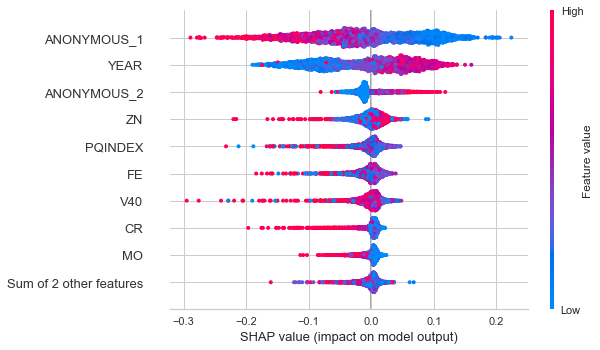

In [64]:
explainer_rf = shap.Explainer(clf_rf)
shap_values_rf = explainer_rf(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_rf)

In [66]:
fi_rf = pd.DataFrame(clf_rf.feature_importances_, index=X_train1.columns, columns=['feature_importance_rf']).sort_values('feature_importance_rf', ascending=False)
fi_rf

feature_importance_rf
ANONYMOUS_1               0.209351
V40                       0.118475
YEAR                      0.114310
ZN                        0.111855
PQINDEX                   0.105322
FE                        0.103360
CU                        0.070254
CR                        0.048897
MO                        0.048761
ANONYMOUS_2               0.045569
NI                        0.023846

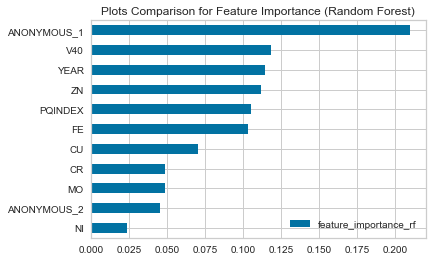

In [67]:
fi_rf[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Random Forest)')
plt.show()

### XGBRegressor

In [70]:
def objectiveXGB(trial, X_train1,y_train1, X_test, y_test):

    param = {
    'verbosity':1,
    'objective': trial.suggest_categorical('objective',['reg:squarederror']),
    'max_depth':trial.suggest_int('max_depth',3,13),  # 데이터 수가 적어 3~13으로 제한
    'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'subsample':trial.suggest_loguniform('subsample',0.7,1),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 300 ),
    'alpha': trial.suggest_loguniform( 'alpha', 1e-3, 10.0),
    'random_state': 42}

    #학습모델 생성
    model = xgb.XGBRegressor(**param)
    model.fit(X_train1,y_train1,eval_set=[(X_test,y_test.Score_0)],early_stopping_rounds=25,verbose=False)

    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test.Score_0, pred)
    
    return mae

In [71]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X_train1, y_train1, X_test, y_test), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)

[I 2022-12-08 21:48:58,022] A new study created in memory with name: no-name-4b0f6432-5f22-4eb1-a562-20e7ceba8092
[I 2022-12-08 21:48:58,070] Trial 0 finished with value: 0.46301159985810564 and parameters: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 6.494341421794356e-08, 'n_estimators': 418, 'subsample': 0.7037753582641653, 'min_child_weight': 250, 'alpha': 0.2525532531597168}. Best is trial 0 with value: 0.46301159985810564.
[I 2022-12-08 21:48:58,438] Trial 1 finished with value: 0.4624048233268023 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 2.3070521427340397e-05, 'n_estimators': 109, 'subsample': 0.9878918053986815, 'min_child_weight': 13, 'alpha': 0.17445360750250516}. Best is trial 1 with value: 0.4624048233268023.
[I 2022-12-08 21:48:59,591] Trial 2 finished with value: 0.46258738427678076 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 3.7689873657543587e-06, 'n_estimators': 471,

[I 2022-12-08 21:49:08,516] Trial 23 finished with value: 0.4369593634773544 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.0009100385059976062, 'n_estimators': 131, 'subsample': 0.7208894446298738, 'min_child_weight': 132, 'alpha': 2.189524944349513}. Best is trial 12 with value: 0.26630190801639086.
[I 2022-12-08 21:49:09,057] Trial 24 finished with value: 0.3330001548609441 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.00364543745941783, 'n_estimators': 230, 'subsample': 0.8481660789850716, 'min_child_weight': 166, 'alpha': 3.7427837437956413}. Best is trial 12 with value: 0.26630190801639086.
[I 2022-12-08 21:49:09,428] Trial 25 finished with value: 0.44683542110599406 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.0004470028015189062, 'n_estimators': 160, 'subsample': 0.7973472395419657, 'min_child_weight': 186, 'alpha': 1.3635475031089666}. Best is trial 12 with v

[I 2022-12-08 21:49:31,248] Trial 47 finished with value: 0.44273229274600906 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.00019694156160135313, 'n_estimators': 450, 'subsample': 0.8624433679860093, 'min_child_weight': 69, 'alpha': 0.41934811384186016}. Best is trial 35 with value: 0.2507929968538416.
[I 2022-12-08 21:49:32,426] Trial 48 finished with value: 0.2591082552350299 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.0047018179950328275, 'n_estimators': 387, 'subsample': 0.922967228130484, 'min_child_weight': 18, 'alpha': 0.11284699430545872}. Best is trial 35 with value: 0.2507929968538416.
[I 2022-12-08 21:49:33,397] Trial 49 finished with value: 0.4629918050900297 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 2.3527037669174243e-07, 'n_estimators': 349, 'subsample': 0.8305335022733739, 'min_child_weight': 64, 'alpha': 0.8844726939145576}. Best is trial 35 with val

[I 2022-12-08 21:50:06,000] Trial 71 finished with value: 0.2268105472189689 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.007353985653882304, 'n_estimators': 476, 'subsample': 0.9727209145991801, 'min_child_weight': 78, 'alpha': 0.19691382949725006}. Best is trial 69 with value: 0.2249356239961115.
[I 2022-12-08 21:50:07,927] Trial 72 finished with value: 0.22567209306615765 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.007631105475126983, 'n_estimators': 478, 'subsample': 0.9713406121372831, 'min_child_weight': 78, 'alpha': 0.1308618716095966}. Best is trial 69 with value: 0.2249356239961115.
[I 2022-12-08 21:50:09,454] Trial 73 finished with value: 0.22743371295548362 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.00777552036728796, 'n_estimators': 439, 'subsample': 0.9742302329667595, 'min_child_weight': 74, 'alpha': 0.16678718698645248}. Best is trial 69 with value: 

[I 2022-12-08 21:50:38,919] Trial 95 finished with value: 0.32782207529721596 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.0019807934391019794, 'n_estimators': 415, 'subsample': 0.9638055252808531, 'min_child_weight': 73, 'alpha': 0.01751528904667336}. Best is trial 78 with value: 0.22022117044898626.
[I 2022-12-08 21:50:40,357] Trial 96 finished with value: 0.4618764589258101 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 1.0597696209798176e-05, 'n_estimators': 446, 'subsample': 0.9616420333994682, 'min_child_weight': 140, 'alpha': 0.009225446730002583}. Best is trial 78 with value: 0.22022117044898626.
[I 2022-12-08 21:50:41,692] Trial 97 finished with value: 0.22327349516948766 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.009715304251825856, 'n_estimators': 463, 'subsample': 0.9922695352975099, 'min_child_weight': 125, 'alpha': 0.01570566276610775}. Best is trial 78 wi

study.best_params: 0.22022117044898626
Number of finished trials: 100
Best trial: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.00992499810512271, 'n_estimators': 456, 'subsample': 0.9996976268005289, 'min_child_weight': 55, 'alpha': 0.10047380499000068}
study.best_params: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.00992499810512271, 'n_estimators': 456, 'subsample': 0.9996976268005289, 'min_child_weight': 55, 'alpha': 0.10047380499000068}


In [72]:
param_xgb = studyXGB.best_params

clf_xgb = xgb.XGBRegressor(**param_xgb, random_state=42)

In [92]:
clf_xgb.fit(X_train1, y_train1)

pred_test_xgb = clf_xgb.predict(X_test)

y_test['pred_xgb'] = [labeling(pred, threshold=0.6) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.2202
F1 Score : 0.2222
Macro F1 Score : 0.5714 

[[2355  194]
 [ 212   58]]


In [76]:
optuna.visualization.plot_param_importances(studyXGB)

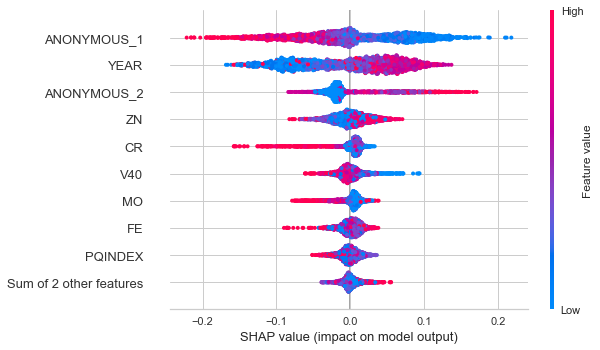

In [77]:
explainer_xgb = shap.Explainer(clf_xgb)
shap_values_xgb = explainer_xgb(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_xgb)

In [78]:
fi_xgb = pd.DataFrame(clf_xgb.feature_importances_, index=X_train1.columns, columns=['feature_importance_xgb']).sort_values('feature_importance_xgb', ascending=False)
fi_xgb

feature_importance_xgb
YEAR                       0.162677
CR                         0.120194
ANONYMOUS_1                0.112411
ANONYMOUS_2                0.100496
NI                         0.084612
V40                        0.081149
FE                         0.072746
ZN                         0.072733
PQINDEX                    0.071074
CU                         0.061506
MO                         0.060403

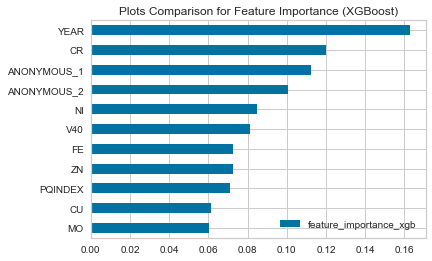

In [79]:
fi_xgb[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (XGBoost)')
plt.show()

### LGBM

In [80]:
def objectiveLGBM(trial, X_train, y_train, X_test, y_test):

    param = {
        'metric': 'mae', 
        'random_state': 42,
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate':trial.suggest_loguniform('learning_rate',1e-8,1e-2),
#         'max_depth':trial.suggest_int('max_depth',3,30),
        'num_leaves' : trial.suggest_categorical('num_leaves', [8,16,32,64,128,256,512,1024]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }

    #학습모델 생성
    model = lgb.LGBMRegressor(**param, max_depth=-1)
    model.fit(X_train,y_train,eval_set=[(X_test,y_test.Score_0)],early_stopping_rounds=25,verbose=False)

    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test.Score_0, pred)
    
    return mae

In [81]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyLGBM = optuna.create_study(direction='minimize')

# n_trials 지정
studyLGBM.optimize(lambda trial: objectiveLGBM(trial, X_train1, y_train1, X_test, y_test), n_trials=100) 

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-12-08 21:56:35,206] A new study created in memory with name: no-name-f0a4e145-0723-4b29-8161-45e941061166
[I 2022-12-08 21:56:35,344] Trial 0 finished with value: 0.24879992120532912 and parameters: {'n_estimators': 375, 'reg_alpha': 0.08064611811531032, 'reg_lambda': 0.033032513353376064, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 8.21868355853892e-05, 'num_leaves': 32, 'min_child_samples': 238, 'min_data_per_groups': 94}. Best is trial 0 with value: 0.24879992120532912.
[I 2022-12-08 21:56:35,457] Trial 1 finished with value: 0.2490746402227839 and parameters: {'n_estimators': 380, 'reg_alpha': 0.011973091584570841, 'reg_lambda': 0.08545096885810724, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 1.3172750093934819e-08, 'num_leaves': 32, 'min_child_samples': 294, 'min_data_per_groups': 99}. Best is trial 0 with value: 0.24879992120532912.
[I 2022-12-08 21:56:35,593] Trial 2 finished with value: 0.24907371631406758 and parameters: {'n_estimators':

[I 2022-12-08 21:56:40,713] Trial 21 finished with value: 0.23069969439665194 and parameters: {'n_estimators': 500, 'reg_alpha': 0.001001888255069895, 'reg_lambda': 0.6809981471617514, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.0030904249962541634, 'num_leaves': 256, 'min_child_samples': 138, 'min_data_per_groups': 2}. Best is trial 10 with value: 0.22254884527561805.
[I 2022-12-08 21:56:41,117] Trial 22 finished with value: 0.2320584304608746 and parameters: {'n_estimators': 402, 'reg_alpha': 0.0017398768288058918, 'reg_lambda': 0.4260249027813659, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.003036650895478007, 'num_leaves': 256, 'min_child_samples': 82, 'min_data_per_groups': 2}. Best is trial 10 with value: 0.22254884527561805.
[I 2022-12-08 21:56:41,392] Trial 23 finished with value: 0.24863078995333462 and parameters: {'n_estimators': 469, 'reg_alpha': 0.004516062170510162, 'reg_lambda': 1.350944821233313, 'colsample_bytree': 0.8, 'subsample': 

[I 2022-12-08 21:56:50,218] Trial 42 finished with value: 0.2371350508942911 and parameters: {'n_estimators': 444, 'reg_alpha': 0.0013965240521237844, 'reg_lambda': 0.5777335999432363, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.0016895742656389155, 'num_leaves': 256, 'min_child_samples': 69, 'min_data_per_groups': 5}. Best is trial 27 with value: 0.21985900535638153.
[I 2022-12-08 21:56:50,532] Trial 43 finished with value: 0.2287706324580983 and parameters: {'n_estimators': 429, 'reg_alpha': 0.0010310002495400288, 'reg_lambda': 0.3711214329865625, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.004179418258479635, 'num_leaves': 256, 'min_child_samples': 133, 'min_data_per_groups': 2}. Best is trial 27 with value: 0.21985900535638153.
[I 2022-12-08 21:56:51,662] Trial 44 finished with value: 0.23861383693504742 and parameters: {'n_estimators': 483, 'reg_alpha': 0.0022984388763964605, 'reg_lambda': 2.0380559578639383, 'colsample_bytree': 0.8, 'subsample'

[I 2022-12-08 21:56:56,694] Trial 63 finished with value: 0.22599208354251973 and parameters: {'n_estimators': 422, 'reg_alpha': 0.0032472233392366297, 'reg_lambda': 1.7478229735948705, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.006737201405808274, 'num_leaves': 512, 'min_child_samples': 199, 'min_data_per_groups': 37}. Best is trial 27 with value: 0.21985900535638153.
[I 2022-12-08 21:56:56,963] Trial 64 finished with value: 0.2258769323942561 and parameters: {'n_estimators': 441, 'reg_alpha': 0.001348042691851645, 'reg_lambda': 1.1289719596765628, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.006841138308862715, 'num_leaves': 256, 'min_child_samples': 174, 'min_data_per_groups': 12}. Best is trial 27 with value: 0.21985900535638153.
[I 2022-12-08 21:56:57,351] Trial 65 finished with value: 0.22080561663960072 and parameters: {'n_estimators': 500, 'reg_alpha': 0.03713069021617836, 'reg_lambda': 0.6756601214177833, 'colsample_bytree': 0.7, 'subsample'

[I 2022-12-08 21:57:05,024] Trial 84 finished with value: 0.22154278115479006 and parameters: {'n_estimators': 488, 'reg_alpha': 0.027067153366601156, 'reg_lambda': 0.0024249179442247634, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.007316854062845813, 'num_leaves': 64, 'min_child_samples': 115, 'min_data_per_groups': 27}. Best is trial 27 with value: 0.21985900535638153.
[I 2022-12-08 21:57:05,877] Trial 85 finished with value: 0.24068149025206756 and parameters: {'n_estimators': 447, 'reg_alpha': 0.04240151843832659, 'reg_lambda': 0.0010075326197693918, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.0020758711590553773, 'num_leaves': 64, 'min_child_samples': 73, 'min_data_per_groups': 34}. Best is trial 27 with value: 0.21985900535638153.
[I 2022-12-08 21:57:06,406] Trial 86 finished with value: 0.22147530480131256 and parameters: {'n_estimators': 433, 'reg_alpha': 0.07170382528469613, 'reg_lambda': 0.021543936686445074, 'colsample_bytree': 0.7, 'subsa

study.best_params: 0.21985900535638153
Number of finished trials: 100
Best trial: {'n_estimators': 343, 'reg_alpha': 0.0022801176445977835, 'reg_lambda': 0.3541315161335923, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.007809216596820026, 'num_leaves': 256, 'min_child_samples': 38, 'min_data_per_groups': 26}
study.best_params: {'n_estimators': 343, 'reg_alpha': 0.0022801176445977835, 'reg_lambda': 0.3541315161335923, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.007809216596820026, 'num_leaves': 256, 'min_child_samples': 38, 'min_data_per_groups': 26}


In [82]:
param_lgbm = studyLGBM.best_params

clf_lgbm = lgb.LGBMRegressor(**param_lgbm, max_depth=-1, random_state=42)

In [93]:
clf_lgbm.fit(X_train1, y_train1)

pred_test_lgbm = clf_lgbm.predict(X_test)

y_test['pred_lgbm'] = [labeling(pred, threshold=0.6) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE : 0.2199
F1 Score : 0.1901
Macro F1 Score : 0.557 

[[2381  206]
 [ 186   46]]


In [94]:
optuna.visualization.plot_param_importances(studyLGBM)

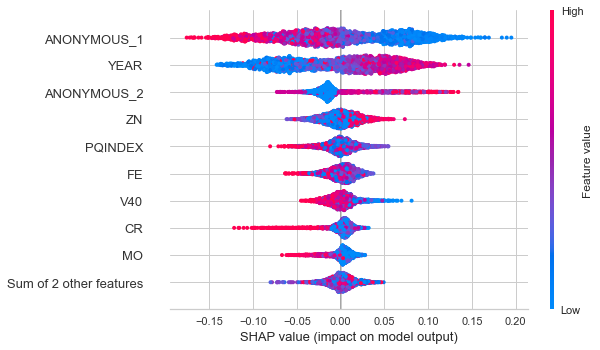

In [95]:
explainer_lgbm = shap.Explainer(clf_lgbm)
shap_values_lgbm = explainer_lgbm(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_lgbm)

In [96]:
fi_lgbm = pd.DataFrame(clf_lgbm.feature_importances_, index=X_train1.columns, columns=['feature_importance_lgbm']).sort_values('feature_importance_lgbm', ascending=False)
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                     3076
ZN                              2577
PQINDEX                         2300
V40                             2298
FE                              2272
CU                              1870
YEAR                            1712
MO                              1153
ANONYMOUS_2                     1073
CR                               836
NI                               245

In [123]:
fi_lgbm['feature_importance_lgbm'] = fi_lgbm['feature_importance_lgbm'] / fi_lgbm['feature_importance_lgbm'].sum()
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                 0.158459
ZN                          0.132753
PQINDEX                     0.118483
V40                         0.118380
FE                          0.117041
CU                          0.096332
YEAR                        0.088193
MO                          0.059396
ANONYMOUS_2                 0.055275
CR                          0.043066
NI                          0.012621

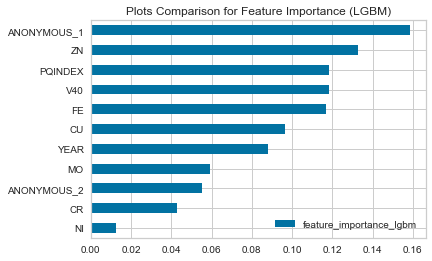

In [124]:
fi_lgbm[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (LGBM)')
plt.show()

### CatBoost

In [98]:
def objectiveCB(trial, X_train, y_train, X_test, y_test):
    
    param = {
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
#         'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators':trial.suggest_int('n_estimators',50,500),
        'max_depth':trial.suggest_int('max_depth',3,13),
        'random_state': 42,
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }

    #학습모델 생성
    model = CatBoostRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test,y_test.Score_0)], early_stopping_rounds=25, verbose=False)

    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test.Score_0, pred)
    
    return mae

In [99]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyCB = optuna.create_study(direction='minimize')

# n_trials 지정
studyCB.optimize(lambda trial: objectiveCB(trial, X_train1, y_train1, X_test, y_test), n_trials=100) 

print('study.best_params:', studyCB.best_trial.value)
print('Number of finished trials:', len(studyCB.trials))
print('Best trial:', studyCB.best_trial.params)
print('study.best_params:', studyCB.best_params)

[I 2022-12-08 22:00:27,353] A new study created in memory with name: no-name-888ac045-0350-4e0f-9fb0-bca44c628906
[I 2022-12-08 22:00:27,973] Trial 0 finished with value: 0.23481917278110215 and parameters: {'l2_leaf_reg': 0.00208733352207555, 'max_bin': 245, 'learning_rate': 0.009781824462364698, 'n_estimators': 106, 'max_depth': 6, 'min_data_in_leaf': 75}. Best is trial 0 with value: 0.23481917278110215.
[I 2022-12-08 22:00:29,845] Trial 1 finished with value: 0.22515816240145162 and parameters: {'l2_leaf_reg': 0.1901632447962351, 'max_bin': 241, 'learning_rate': 0.009489827228919175, 'n_estimators': 338, 'max_depth': 9, 'min_data_in_leaf': 56}. Best is trial 1 with value: 0.22515816240145162.
[I 2022-12-08 22:00:46,609] Trial 2 finished with value: 0.22740327368539084 and parameters: {'l2_leaf_reg': 0.005677175401800869, 'max_bin': 236, 'learning_rate': 0.01604474718998427, 'n_estimators': 148, 'max_depth': 13, 'min_data_in_leaf': 283}. Best is trial 1 with value: 0.2251581624014516

[I 2022-12-08 22:03:49,186] Trial 27 finished with value: 0.2263867767959557 and parameters: {'l2_leaf_reg': 9.004735187634111, 'max_bin': 252, 'learning_rate': 0.015477289740650955, 'n_estimators': 225, 'max_depth': 13, 'min_data_in_leaf': 28}. Best is trial 10 with value: 0.2232719986032814.
[I 2022-12-08 22:03:51,943] Trial 28 finished with value: 0.22436797640677528 and parameters: {'l2_leaf_reg': 0.7702265524696592, 'max_bin': 341, 'learning_rate': 0.013131081575754934, 'n_estimators': 288, 'max_depth': 8, 'min_data_in_leaf': 138}. Best is trial 10 with value: 0.2232719986032814.
[I 2022-12-08 22:03:53,043] Trial 29 finished with value: 0.22711133835280184 and parameters: {'l2_leaf_reg': 0.16693502069405405, 'max_bin': 235, 'learning_rate': 0.009843683739569174, 'n_estimators': 422, 'max_depth': 6, 'min_data_in_leaf': 74}. Best is trial 10 with value: 0.2232719986032814.
[I 2022-12-08 22:04:17,304] Trial 30 finished with value: 0.22663518194632598 and parameters: {'l2_leaf_reg': 1

[I 2022-12-08 22:04:53,457] Trial 54 finished with value: 0.22308464560321947 and parameters: {'l2_leaf_reg': 0.5154374446274306, 'max_bin': 375, 'learning_rate': 0.017956186283400753, 'n_estimators': 282, 'max_depth': 6, 'min_data_in_leaf': 107}. Best is trial 51 with value: 0.2227596362504652.
[I 2022-12-08 22:04:54,221] Trial 55 finished with value: 0.22309727384913555 and parameters: {'l2_leaf_reg': 0.26694838744977595, 'max_bin': 378, 'learning_rate': 0.017775231754122267, 'n_estimators': 285, 'max_depth': 6, 'min_data_in_leaf': 81}. Best is trial 51 with value: 0.2227596362504652.
[I 2022-12-08 22:04:54,877] Trial 56 finished with value: 0.22331714963442942 and parameters: {'l2_leaf_reg': 0.2325674315259079, 'max_bin': 373, 'learning_rate': 0.017831786828229612, 'n_estimators': 277, 'max_depth': 5, 'min_data_in_leaf': 87}. Best is trial 51 with value: 0.2227596362504652.
[I 2022-12-08 22:04:55,757] Trial 57 finished with value: 0.22269598644543312 and parameters: {'l2_leaf_reg': 

[I 2022-12-08 22:05:25,667] Trial 81 finished with value: 0.22458714787913978 and parameters: {'l2_leaf_reg': 0.42350814943843484, 'max_bin': 391, 'learning_rate': 0.01676842214849004, 'n_estimators': 357, 'max_depth': 9, 'min_data_in_leaf': 78}. Best is trial 62 with value: 0.22186964800096806.
[I 2022-12-08 22:05:27,164] Trial 82 finished with value: 0.22460722782695544 and parameters: {'l2_leaf_reg': 0.21042057103164638, 'max_bin': 383, 'learning_rate': 0.01757874973927295, 'n_estimators': 339, 'max_depth': 8, 'min_data_in_leaf': 60}. Best is trial 62 with value: 0.22186964800096806.
[I 2022-12-08 22:05:30,404] Trial 83 finished with value: 0.22199718296918144 and parameters: {'l2_leaf_reg': 1.3066627093211216, 'max_bin': 373, 'learning_rate': 0.015866509499565203, 'n_estimators': 366, 'max_depth': 9, 'min_data_in_leaf': 131}. Best is trial 62 with value: 0.22186964800096806.
[I 2022-12-08 22:05:32,657] Trial 84 finished with value: 0.22539706136244603 and parameters: {'l2_leaf_reg'

study.best_params: 0.22186964800096806
Number of finished trials: 100
Best trial: {'l2_leaf_reg': 0.2173719039485466, 'max_bin': 384, 'learning_rate': 0.017055842199830848, 'n_estimators': 261, 'max_depth': 6, 'min_data_in_leaf': 74}
study.best_params: {'l2_leaf_reg': 0.2173719039485466, 'max_bin': 384, 'learning_rate': 0.017055842199830848, 'n_estimators': 261, 'max_depth': 6, 'min_data_in_leaf': 74}


In [100]:
param_cat = studyCB.best_params

clf_cat = CatBoostRegressor(**param_cat, random_state=42)

In [103]:
clf_cat.fit(X_train1, y_train1)

pred_test_cat = clf_cat.predict(X_test)

y_test['pred_cat'] = [labeling(pred, threshold=0.6) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

0:	learn: 0.3808351	total: 2.35ms	remaining: 611ms
1:	learn: 0.3802474	total: 4.64ms	remaining: 601ms
2:	learn: 0.3797185	total: 6.86ms	remaining: 590ms
3:	learn: 0.3791040	total: 8.99ms	remaining: 578ms
4:	learn: 0.3785172	total: 11.2ms	remaining: 575ms
5:	learn: 0.3780389	total: 13.4ms	remaining: 569ms
6:	learn: 0.3775928	total: 15.9ms	remaining: 578ms
7:	learn: 0.3770895	total: 18.2ms	remaining: 576ms
8:	learn: 0.3766346	total: 20.5ms	remaining: 573ms
9:	learn: 0.3762192	total: 22.8ms	remaining: 572ms
10:	learn: 0.3757723	total: 25.1ms	remaining: 571ms
11:	learn: 0.3753723	total: 27.5ms	remaining: 571ms
12:	learn: 0.3749489	total: 29.8ms	remaining: 568ms
13:	learn: 0.3745543	total: 31.9ms	remaining: 563ms
14:	learn: 0.3740693	total: 34.2ms	remaining: 560ms
15:	learn: 0.3735724	total: 36.3ms	remaining: 556ms
16:	learn: 0.3731834	total: 38.3ms	remaining: 550ms
17:	learn: 0.3728399	total: 40.7ms	remaining: 549ms
18:	learn: 0.3724311	total: 42.7ms	remaining: 544ms
19:	learn: 0.3719946	t

179:	learn: 0.3461620	total: 351ms	remaining: 158ms
180:	learn: 0.3460740	total: 353ms	remaining: 156ms
181:	learn: 0.3459918	total: 355ms	remaining: 154ms
182:	learn: 0.3458285	total: 358ms	remaining: 152ms
183:	learn: 0.3457595	total: 360ms	remaining: 151ms
184:	learn: 0.3456632	total: 362ms	remaining: 149ms
185:	learn: 0.3455600	total: 364ms	remaining: 147ms
186:	learn: 0.3454561	total: 367ms	remaining: 145ms
187:	learn: 0.3453920	total: 369ms	remaining: 143ms
188:	learn: 0.3452837	total: 372ms	remaining: 142ms
189:	learn: 0.3452363	total: 374ms	remaining: 140ms
190:	learn: 0.3451357	total: 377ms	remaining: 138ms
191:	learn: 0.3450413	total: 379ms	remaining: 136ms
192:	learn: 0.3449261	total: 381ms	remaining: 134ms
193:	learn: 0.3448574	total: 384ms	remaining: 132ms
194:	learn: 0.3447535	total: 386ms	remaining: 131ms
195:	learn: 0.3446490	total: 389ms	remaining: 129ms
196:	learn: 0.3445789	total: 391ms	remaining: 127ms
197:	learn: 0.3444925	total: 393ms	remaining: 125ms
198:	learn: 

In [104]:
optuna.visualization.plot_param_importances(studyCB)

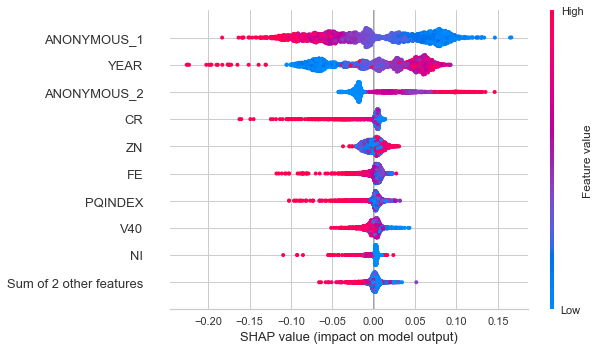

In [105]:
explainer_cat = shap.Explainer(clf_cat)
shap_values_cat = explainer_cat(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_cat)

In [106]:
fi_cat = pd.DataFrame(clf_cat.feature_importances_, index=X_train1.columns, columns=['feature_importance_cat']).sort_values('feature_importance_cat', ascending=False)
fi_cat

feature_importance_cat
YEAR                      23.768434
ANONYMOUS_1               22.010602
ANONYMOUS_2               11.320578
PQINDEX                    7.984336
FE                         7.018302
ZN                         6.003051
CR                         5.746806
V40                        5.651592
MO                         3.744953
CU                         3.467004
NI                         3.284343

In [125]:
fi_cat['feature_importance_cat'] = fi_cat['feature_importance_cat'] / fi_cat['feature_importance_cat'].sum()
fi_cat

feature_importance_cat
YEAR                       0.237684
ANONYMOUS_1                0.220106
ANONYMOUS_2                0.113206
PQINDEX                    0.079843
FE                         0.070183
ZN                         0.060031
CR                         0.057468
V40                        0.056516
MO                         0.037450
CU                         0.034670
NI                         0.032843

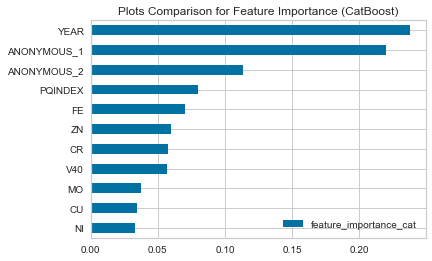

In [126]:
fi_cat[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (CatBoost)')
plt.show()

### Extra Tree

In [108]:
def objectiveET(trial, X_train, y_train, X_test, y_test):
    
    param = {
    'max_depth':trial.suggest_int('max_depth',3,13),
    'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 1000),
    'n_estimators':trial.suggest_int('n_estimators',50,500),
    'random_state': 42}

    #학습모델 생성
    model = ExtraTreesRegressor(**param)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test.Score_0, pred)
    
    return mae

In [109]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyET = optuna.create_study(direction='minimize')

# n_trials 지정
studyET.optimize(lambda trial: objectiveET(trial, X_train1, y_train1, X_test, y_test), n_trials=100) 

print('study.best_params:', studyET.best_trial.value)
print('Number of finished trials:', len(studyET.trials))
print('Best trial:', studyET.best_trial.params)
print('study.best_params:', studyET.best_params)

[I 2022-12-08 22:08:55,018] A new study created in memory with name: no-name-0686297e-7598-48e4-8da8-aa4fef5fd4e4
[I 2022-12-08 22:08:55,508] Trial 0 finished with value: 0.22242695832915782 and parameters: {'max_depth': 7, 'max_leaf_nodes': 506, 'n_estimators': 235}. Best is trial 0 with value: 0.22242695832915782.
[I 2022-12-08 22:08:56,767] Trial 1 finished with value: 0.22051098591110704 and parameters: {'max_depth': 11, 'max_leaf_nodes': 144, 'n_estimators': 467}. Best is trial 1 with value: 0.22051098591110704.
[I 2022-12-08 22:08:58,418] Trial 2 finished with value: 0.2219432616404478 and parameters: {'max_depth': 13, 'max_leaf_nodes': 852, 'n_estimators': 365}. Best is trial 1 with value: 0.22051098591110704.
[I 2022-12-08 22:08:58,555] Trial 3 finished with value: 0.2219250542009538 and parameters: {'max_depth': 8, 'max_leaf_nodes': 539, 'n_estimators': 54}. Best is trial 1 with value: 0.22051098591110704.
[I 2022-12-08 22:08:59,279] Trial 4 finished with value: 0.231772941772

[I 2022-12-08 22:09:32,407] Trial 37 finished with value: 0.22181913869782258 and parameters: {'max_depth': 13, 'max_leaf_nodes': 608, 'n_estimators': 352}. Best is trial 28 with value: 0.21883279248184836.
[I 2022-12-08 22:09:33,832] Trial 38 finished with value: 0.21870388344350356 and parameters: {'max_depth': 12, 'max_leaf_nodes': 276, 'n_estimators': 298}. Best is trial 38 with value: 0.21870388344350356.
[I 2022-12-08 22:09:36,515] Trial 39 finished with value: 0.22038505565891972 and parameters: {'max_depth': 12, 'max_leaf_nodes': 464, 'n_estimators': 405}. Best is trial 38 with value: 0.21870388344350356.
[I 2022-12-08 22:09:38,654] Trial 40 finished with value: 0.21953310543847823 and parameters: {'max_depth': 13, 'max_leaf_nodes': 353, 'n_estimators': 312}. Best is trial 38 with value: 0.21870388344350356.
[I 2022-12-08 22:09:40,111] Trial 41 finished with value: 0.21931033464127878 and parameters: {'max_depth': 11, 'max_leaf_nodes': 259, 'n_estimators': 289}. Best is trial 3

[I 2022-12-08 22:10:35,186] Trial 75 finished with value: 0.2198623316405769 and parameters: {'max_depth': 13, 'max_leaf_nodes': 424, 'n_estimators': 162}. Best is trial 71 with value: 0.21851724749634197.
[I 2022-12-08 22:10:35,987] Trial 76 finished with value: 0.22121424516895016 and parameters: {'max_depth': 11, 'max_leaf_nodes': 103, 'n_estimators': 283}. Best is trial 71 with value: 0.21851724749634197.
[I 2022-12-08 22:10:36,760] Trial 77 finished with value: 0.21985339230953374 and parameters: {'max_depth': 10, 'max_leaf_nodes': 234, 'n_estimators': 204}. Best is trial 71 with value: 0.21851724749634197.
[I 2022-12-08 22:10:38,128] Trial 78 finished with value: 0.21943535491711727 and parameters: {'max_depth': 13, 'max_leaf_nodes': 348, 'n_estimators': 319}. Best is trial 71 with value: 0.21851724749634197.
[I 2022-12-08 22:10:39,196] Trial 79 finished with value: 0.21859462364892968 and parameters: {'max_depth': 12, 'max_leaf_nodes': 255, 'n_estimators': 239}. Best is trial 71

study.best_params: 0.21839549181794718
Number of finished trials: 100
Best trial: {'max_depth': 12, 'max_leaf_nodes': 312, 'n_estimators': 222}
study.best_params: {'max_depth': 12, 'max_leaf_nodes': 312, 'n_estimators': 222}


In [128]:
param_et = studyET.best_params

clf_et1 = ExtraTreesRegressor(**param_et, random_state=42)

In [129]:
clf_et1.fit(X_train1, y_train1)

pred_test_et = clf_et1.predict(X_test)

y_test['pred_et'] = [labeling(pred, threshold=0.6) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.2184
F1 Score : 0.2418
Macro F1 Score : 0.5823 

[[2361  189]
 [ 206   63]]


In [112]:
optuna.visualization.plot_param_importances(studyET)

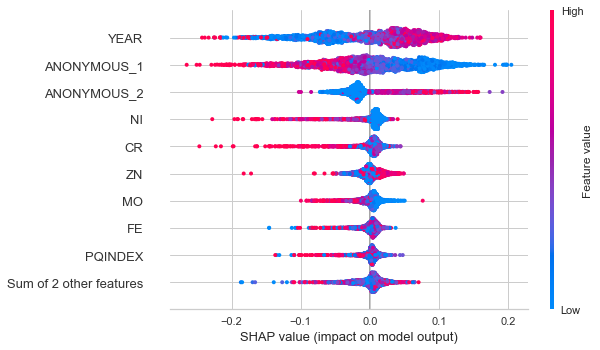

In [130]:
explainer_et = shap.Explainer(clf_et1)
shap_values_et = explainer_et(X_train1)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_et)

In [131]:
fi_et = pd.DataFrame(clf_et1.feature_importances_, index=X_train1.columns, columns=['feature_importance_et']).sort_values('feature_importance_et', ascending=False)
fi_et

feature_importance_et
ANONYMOUS_1               0.181112
YEAR                      0.165326
PQINDEX                   0.078963
FE                        0.077753
CR                        0.077407
CU                        0.075902
ANONYMOUS_2               0.073877
V40                       0.073244
ZN                        0.071071
MO                        0.065985
NI                        0.059360

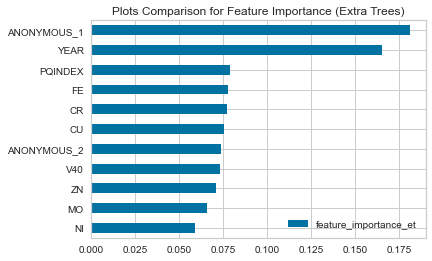

In [132]:
fi_et[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Extra Trees)')
plt.show()

## Dataset 2

### Decision Tree

In [133]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyDT=optuna.create_study(direction='minimize')

# n_trials 지정
studyDT.optimize(lambda trial: objectiveDT(trial, X_train2, y_train2, X_test, y_test), n_trials=100) 

print('study.best_params:', studyDT.best_trial.value)
print('Number of finished trials:', len(studyDT.trials))
print('Best trial:', studyDT.best_trial.params)
print('study.best_params:', studyDT.best_params)

[I 2022-12-08 22:30:58,677] A new study created in memory with name: no-name-ac4faf6c-2c1c-40b3-b890-480f4838dc43
[I 2022-12-08 22:30:58,702] Trial 0 finished with value: 0.23512552756438598 and parameters: {'max_depth': 11, 'max_leaf_nodes': 641}. Best is trial 0 with value: 0.23512552756438598.
[I 2022-12-08 22:30:58,718] Trial 1 finished with value: 0.2248376043479513 and parameters: {'max_depth': 7, 'max_leaf_nodes': 187}. Best is trial 1 with value: 0.2248376043479513.
[I 2022-12-08 22:30:58,726] Trial 2 finished with value: 0.22540513715375016 and parameters: {'max_depth': 6, 'max_leaf_nodes': 620}. Best is trial 1 with value: 0.2248376043479513.
[I 2022-12-08 22:30:58,734] Trial 3 finished with value: 0.22734728391903308 and parameters: {'max_depth': 4, 'max_leaf_nodes': 584}. Best is trial 1 with value: 0.2248376043479513.
[I 2022-12-08 22:30:58,742] Trial 4 finished with value: 0.2305253081190526 and parameters: {'max_depth': 3, 'max_leaf_nodes': 960}. Best is trial 1 with val

[I 2022-12-08 22:30:59,427] Trial 42 finished with value: 0.2248376043479513 and parameters: {'max_depth': 7, 'max_leaf_nodes': 554}. Best is trial 1 with value: 0.2248376043479513.
[I 2022-12-08 22:30:59,443] Trial 43 finished with value: 0.22745121507794808 and parameters: {'max_depth': 8, 'max_leaf_nodes': 340}. Best is trial 1 with value: 0.2248376043479513.
[I 2022-12-08 22:30:59,459] Trial 44 finished with value: 0.2248376043479513 and parameters: {'max_depth': 7, 'max_leaf_nodes': 138}. Best is trial 1 with value: 0.2248376043479513.
[I 2022-12-08 22:30:59,475] Trial 45 finished with value: 0.22540513715375016 and parameters: {'max_depth': 6, 'max_leaf_nodes': 244}. Best is trial 1 with value: 0.2248376043479513.
[I 2022-12-08 22:30:59,491] Trial 46 finished with value: 0.22745121507794808 and parameters: {'max_depth': 8, 'max_leaf_nodes': 352}. Best is trial 1 with value: 0.2248376043479513.
[I 2022-12-08 22:30:59,515] Trial 47 finished with value: 0.2258006154078818 and parame

[I 2022-12-08 22:31:00,195] Trial 84 finished with value: 0.22330672953847436 and parameters: {'max_depth': 7, 'max_leaf_nodes': 26}. Best is trial 84 with value: 0.22330672953847436.
[I 2022-12-08 22:31:00,219] Trial 85 finished with value: 0.22540513715375016 and parameters: {'max_depth': 6, 'max_leaf_nodes': 162}. Best is trial 84 with value: 0.22330672953847436.
[I 2022-12-08 22:31:00,235] Trial 86 finished with value: 0.22745121507794808 and parameters: {'max_depth': 8, 'max_leaf_nodes': 610}. Best is trial 84 with value: 0.22330672953847436.
[I 2022-12-08 22:31:00,251] Trial 87 finished with value: 0.2248376043479513 and parameters: {'max_depth': 7, 'max_leaf_nodes': 126}. Best is trial 84 with value: 0.22330672953847436.
[I 2022-12-08 22:31:00,275] Trial 88 finished with value: 0.22494325679279423 and parameters: {'max_depth': 7, 'max_leaf_nodes': 72}. Best is trial 84 with value: 0.22330672953847436.
[I 2022-12-08 22:31:00,283] Trial 89 finished with value: 0.22605804082243028 

study.best_params: 0.22330672953847436
Number of finished trials: 100
Best trial: {'max_depth': 7, 'max_leaf_nodes': 26}
study.best_params: {'max_depth': 7, 'max_leaf_nodes': 26}


In [134]:
param_dt = studyDT.best_params

clf_dt = DecisionTreeRegressor(**param_dt, random_state=42)

In [135]:
clf_dt.fit(X_train2, y_train2)

pred_test_dt = clf_dt.predict(X_test)

y_test['pred_dt'] = [labeling(pred, threshold=0.6) for pred in pred_test_dt]

print('MAE :', round(mean_absolute_error(pred_test_dt, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_dt, y_test.Y_LABEL))

MAE : 0.2233
F1 Score : 0.2115
Macro F1 Score : 0.5567 

[[2261  186]
 [ 306   66]]


In [136]:
optuna.visualization.plot_param_importances(studyDT)

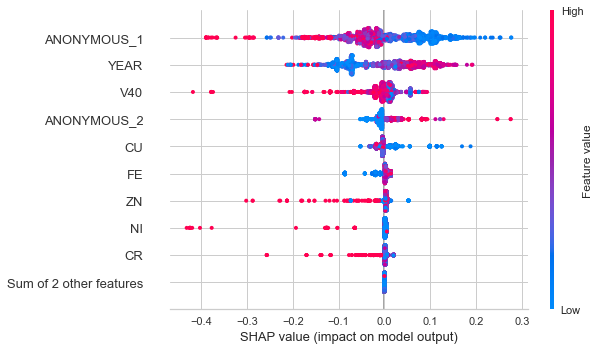

In [137]:
explainer_dt = shap.Explainer(clf_dt)
shap_values_dt = explainer_dt(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_dt)

In [138]:
fi_dt = pd.DataFrame(clf_dt.feature_importances_, index=X_train2.columns, columns=['feature_importance_dt']).sort_values('feature_importance_dt', ascending=False)
fi_dt

feature_importance_dt
YEAR                      0.285054
ANONYMOUS_1               0.274508
V40                       0.139227
ANONYMOUS_2               0.086737
NI                        0.067789
ZN                        0.051160
CR                        0.045492
CU                        0.032667
FE                        0.017366
PQINDEX                   0.000000
MO                        0.000000

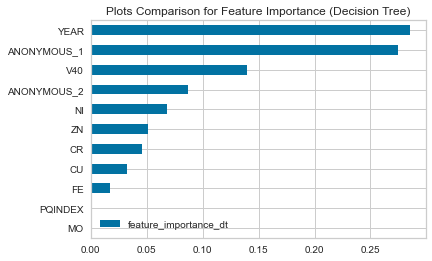

In [139]:
fi_dt[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Decision Tree)')
plt.show()

### SVR

In [140]:
# MAE가 최소가 되는 방향으로 학습을 진행
studySVR=optuna.create_study(direction='minimize')

# n_trials 지정
studySVR.optimize(lambda trial: objectiveSVR(trial, X_train2, y_train2, X_test, y_test), n_trials=100) 

print('study.best_params:', studySVR.best_trial.value)
print('Number of finished trials:', len(studySVR.trials))
print('Best trial:', studySVR.best_trial.params)
print('study.best_params:', studySVR.best_params)

[I 2022-12-08 22:35:26,866] A new study created in memory with name: no-name-90a66e5d-d111-40f1-86ca-a5b376f8eef0
[I 2022-12-08 22:35:28,195] Trial 0 finished with value: 0.2792888962675489 and parameters: {'C': 6.6467455783746985, 'degree': 5, 'gamma': 0.009273246995461261, 'epsilon': 0.23182622755499527}. Best is trial 0 with value: 0.2792888962675489.
[I 2022-12-08 22:35:29,204] Trial 1 finished with value: 0.18921166375416182 and parameters: {'C': 2.3192483669821846, 'degree': 7, 'gamma': 0.0010969462496563313, 'epsilon': 0.14956720098957849}. Best is trial 1 with value: 0.18921166375416182.
[I 2022-12-08 22:35:30,228] Trial 2 finished with value: 0.383932891201951 and parameters: {'C': 3.098400948305646, 'degree': 5, 'gamma': 0.004001378543091036, 'epsilon': 0.4002542980084171}. Best is trial 1 with value: 0.18921166375416182.
[I 2022-12-08 22:35:31,216] Trial 3 finished with value: 0.32113784879990376 and parameters: {'C': 3.454033998373768, 'degree': 5, 'gamma': 0.00305468724449

[I 2022-12-08 22:36:04,119] Trial 32 finished with value: 0.16474030759146424 and parameters: {'C': 0.5141457899559637, 'degree': 7, 'gamma': 0.00215217243921562, 'epsilon': 0.11801676170808792}. Best is trial 31 with value: 0.11809654625470527.
[I 2022-12-08 22:36:05,275] Trial 33 finished with value: 0.14162962068238222 and parameters: {'C': 0.3953488921379233, 'degree': 7, 'gamma': 0.002773396833739986, 'epsilon': 0.08690447556495771}. Best is trial 31 with value: 0.11809654625470527.
[I 2022-12-08 22:36:06,389] Trial 34 finished with value: 0.1928043672659388 and parameters: {'C': 0.6437975600458538, 'degree': 6, 'gamma': 0.0021171151228134943, 'epsilon': 0.1538973191139582}. Best is trial 31 with value: 0.11809654625470527.
[I 2022-12-08 22:36:07,383] Trial 35 finished with value: 0.13485628547133796 and parameters: {'C': 0.49658722641382025, 'degree': 7, 'gamma': 0.001273667737951217, 'epsilon': 0.08399544178263504}. Best is trial 31 with value: 0.11809654625470527.
[I 2022-12-08

[I 2022-12-08 22:36:39,538] Trial 64 finished with value: 0.1568695477623789 and parameters: {'C': 0.744505447164681, 'degree': 7, 'gamma': 0.001978881137887967, 'epsilon': 0.10595586012145697}. Best is trial 62 with value: 0.11604702860499062.
[I 2022-12-08 22:36:40,707] Trial 65 finished with value: 0.11797323105639942 and parameters: {'C': 0.539701804742025, 'degree': 7, 'gamma': 0.0024675721930865085, 'epsilon': 0.050766784853023474}. Best is trial 62 with value: 0.11604702860499062.
[I 2022-12-08 22:36:41,783] Trial 66 finished with value: 0.1374594356325791 and parameters: {'C': 0.39132743729497277, 'degree': 7, 'gamma': 0.002483899679699523, 'epsilon': 0.08244706173808641}. Best is trial 62 with value: 0.11604702860499062.
[I 2022-12-08 22:36:42,840] Trial 67 finished with value: 0.14984766020565757 and parameters: {'C': 0.5391193512716643, 'degree': 7, 'gamma': 0.0030315735479170924, 'epsilon': 0.09427869080382065}. Best is trial 62 with value: 0.11604702860499062.
[I 2022-12-0

[I 2022-12-08 22:37:25,321] Trial 96 finished with value: 0.12427922778133482 and parameters: {'C': 0.47720440374269085, 'degree': 2, 'gamma': 0.0012987391742241138, 'epsilon': 0.06956300179311793}. Best is trial 93 with value: 0.11085537644822857.
[I 2022-12-08 22:37:26,660] Trial 97 finished with value: 0.1101244636142382 and parameters: {'C': 0.41770486193253165, 'degree': 3, 'gamma': 0.0010549330966712386, 'epsilon': 0.05093914574761282}. Best is trial 97 with value: 0.1101244636142382.
[I 2022-12-08 22:37:27,866] Trial 98 finished with value: 0.1093759063738593 and parameters: {'C': 0.3963443607540798, 'degree': 3, 'gamma': 0.0010612507852701654, 'epsilon': 0.05020773056305497}. Best is trial 98 with value: 0.1093759063738593.
[I 2022-12-08 22:37:28,665] Trial 99 finished with value: 0.4549648601739141 and parameters: {'C': 0.40045852125111536, 'degree': 3, 'gamma': 0.0010586411916397877, 'epsilon': 0.48414085793761563}. Best is trial 98 with value: 0.1093759063738593.


study.best_params: 0.1093759063738593
Number of finished trials: 100
Best trial: {'C': 0.3963443607540798, 'degree': 3, 'gamma': 0.0010612507852701654, 'epsilon': 0.05020773056305497}
study.best_params: {'C': 0.3963443607540798, 'degree': 3, 'gamma': 0.0010612507852701654, 'epsilon': 0.05020773056305497}


In [141]:
param_svr = studySVR.best_params

clf_svr = SVR(**param_svr)

In [142]:
clf_svr.fit(X_train2, y_train2)

pred_test_svr = clf_svr.predict(X_test)

y_test['pred_svr'] = [labeling(pred, threshold=0.6) for pred in pred_test_svr]

print('MAE :', round(mean_absolute_error(pred_test_svr, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_svr, y_test.Y_LABEL))

MAE : 0.1094
F1 Score : 0.0225
Macro F1 Score : 0.4869 

[[2555  249]
 [  12    3]]


In [143]:
optuna.visualization.plot_param_importances(studySVR)

### Random Forest Regressor

In [144]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyRF=optuna.create_study(direction='minimize')

# n_trials 지정
studyRF.optimize(lambda trial: objectiveRF(trial, X_train2, y_train2, X_test, y_test), n_trials=100) 

print('study.best_params:', studyRF.best_trial.value)
print('Number of finished trials:', len(studyRF.trials))
print('Best trial:', studyRF.best_trial.params)
print('study.best_params:', studyRF.best_params)

[I 2022-12-08 22:40:24,059] A new study created in memory with name: no-name-b323644d-e1f5-4b89-acd2-2d5fc3833cbb
[I 2022-12-08 22:40:26,042] Trial 0 finished with value: 0.2212170843180191 and parameters: {'max_depth': 6, 'max_leaf_nodes': 270, 'n_estimators': 208}. Best is trial 0 with value: 0.2212170843180191.
[I 2022-12-08 22:40:31,071] Trial 1 finished with value: 0.2239940693177272 and parameters: {'max_depth': 13, 'max_leaf_nodes': 612, 'n_estimators': 336}. Best is trial 0 with value: 0.2212170843180191.
[I 2022-12-08 22:40:34,219] Trial 2 finished with value: 0.22396625532517375 and parameters: {'max_depth': 13, 'max_leaf_nodes': 17, 'n_estimators': 310}. Best is trial 0 with value: 0.2212170843180191.
[I 2022-12-08 22:40:35,186] Trial 3 finished with value: 0.2201306491173941 and parameters: {'max_depth': 6, 'max_leaf_nodes': 738, 'n_estimators': 81}. Best is trial 3 with value: 0.2201306491173941.
[I 2022-12-08 22:40:39,070] Trial 4 finished with value: 0.22226202391222297 

[I 2022-12-08 22:41:36,702] Trial 38 finished with value: 0.22024780989066425 and parameters: {'max_depth': 8, 'max_leaf_nodes': 735, 'n_estimators': 297}. Best is trial 32 with value: 0.21891285607356417.
[I 2022-12-08 22:41:37,301] Trial 39 finished with value: 0.2201306491173941 and parameters: {'max_depth': 6, 'max_leaf_nodes': 837, 'n_estimators': 81}. Best is trial 32 with value: 0.21891285607356417.
[I 2022-12-08 22:41:38,524] Trial 40 finished with value: 0.21903348705611037 and parameters: {'max_depth': 9, 'max_leaf_nodes': 521, 'n_estimators': 129}. Best is trial 32 with value: 0.21891285607356417.
[I 2022-12-08 22:41:39,246] Trial 41 finished with value: 0.21896095065570395 and parameters: {'max_depth': 7, 'max_leaf_nodes': 844, 'n_estimators': 92}. Best is trial 32 with value: 0.21891285607356417.
[I 2022-12-08 22:41:39,793] Trial 42 finished with value: 0.21908075827034693 and parameters: {'max_depth': 7, 'max_leaf_nodes': 933, 'n_estimators': 77}. Best is trial 32 with va

[I 2022-12-08 22:42:15,443] Trial 76 finished with value: 0.2190433103864372 and parameters: {'max_depth': 10, 'max_leaf_nodes': 907, 'n_estimators': 75}. Best is trial 74 with value: 0.2184082417782431.
[I 2022-12-08 22:42:16,138] Trial 77 finished with value: 0.2186263099684166 and parameters: {'max_depth': 9, 'max_leaf_nodes': 929, 'n_estimators': 78}. Best is trial 74 with value: 0.2184082417782431.
[I 2022-12-08 22:42:16,667] Trial 78 finished with value: 0.2185032280684724 and parameters: {'max_depth': 9, 'max_leaf_nodes': 938, 'n_estimators': 60}. Best is trial 74 with value: 0.2184082417782431.
[I 2022-12-08 22:42:17,294] Trial 79 finished with value: 0.2210266671192478 and parameters: {'max_depth': 11, 'max_leaf_nodes': 935, 'n_estimators': 60}. Best is trial 74 with value: 0.2184082417782431.
[I 2022-12-08 22:42:18,040] Trial 80 finished with value: 0.21903876126075253 and parameters: {'max_depth': 10, 'max_leaf_nodes': 1000, 'n_estimators': 78}. Best is trial 74 with value: 

study.best_params: 0.21827695893590726
Number of finished trials: 100
Best trial: {'max_depth': 9, 'max_leaf_nodes': 389, 'n_estimators': 65}
study.best_params: {'max_depth': 9, 'max_leaf_nodes': 389, 'n_estimators': 65}


In [145]:
param_rf = studyRF.best_params

clf_rf = RandomForestRegressor(**param_rf, random_state=42)

In [146]:
clf_rf.fit(X_train2, y_train2)

pred_test_rf = clf_rf.predict(X_test)

y_test['pred_rf'] = [labeling(pred, threshold=0.6) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.2183
F1 Score : 0.2308
Macro F1 Score : 0.5763 

[[2359  192]
 [ 208   60]]


In [147]:
optuna.visualization.plot_param_importances(studyRF)

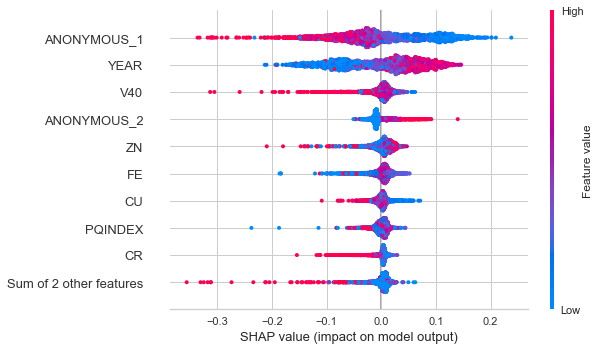

In [148]:
explainer_rf = shap.Explainer(clf_rf)
shap_values_rf = explainer_rf(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_rf)

In [149]:
fi_rf = pd.DataFrame(clf_rf.feature_importances_, index=X_train2.columns, columns=['feature_importance_rf']).sort_values('feature_importance_rf', ascending=False)
fi_rf

feature_importance_rf
ANONYMOUS_1               0.228277
YEAR                      0.128136
V40                       0.119714
ZN                        0.105123
FE                        0.091880
PQINDEX                   0.079279
CU                        0.071897
ANONYMOUS_2               0.047613
MO                        0.046436
CR                        0.042592
NI                        0.039054

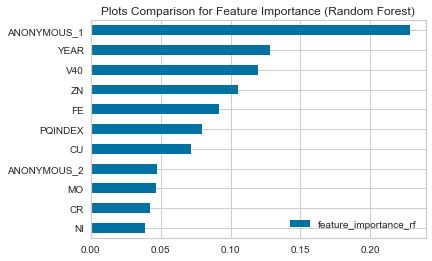

In [150]:
fi_rf[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Random Forest)')
plt.show()

### XGBRegressor

In [151]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X_train2, y_train2, X_test, y_test), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)

[I 2022-12-08 22:45:06,381] A new study created in memory with name: no-name-042f710e-ac8f-423b-a718-3e5075563df2
[I 2022-12-08 22:45:07,113] Trial 0 finished with value: 0.4593434377447346 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 6.296524109130559e-05, 'n_estimators': 248, 'subsample': 0.7405316629376333, 'min_child_weight': 51, 'alpha': 0.36807248951083743}. Best is trial 0 with value: 0.4593434377447346.
[I 2022-12-08 22:45:07,813] Trial 1 finished with value: 0.46293406039984264 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 1.483763896778447e-06, 'n_estimators': 223, 'subsample': 0.7431462423240806, 'min_child_weight': 52, 'alpha': 1.1184888581717278}. Best is trial 0 with value: 0.4593434377447346.
[I 2022-12-08 22:45:07,905] Trial 2 finished with value: 0.46301159985810564 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 2.39149512609383e-08, 'n_estimators': 468, 's

[I 2022-12-08 22:45:22,680] Trial 23 finished with value: 0.4531801430985707 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.00033061372896082736, 'n_estimators': 138, 'subsample': 0.8195222471886247, 'min_child_weight': 217, 'alpha': 9.237821358800376}. Best is trial 14 with value: 0.24506515299555848.
[I 2022-12-08 22:45:23,084] Trial 24 finished with value: 0.37817820726640256 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.0033085439562839723, 'n_estimators': 139, 'subsample': 0.778082170522785, 'min_child_weight': 260, 'alpha': 1.8922662333273683}. Best is trial 14 with value: 0.24506515299555848.
[I 2022-12-08 22:45:23,818] Trial 25 finished with value: 0.4437120932012046 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.0003138093670863718, 'n_estimators': 284, 'subsample': 0.7999007523267153, 'min_child_weight': 205, 'alpha': 4.883693412546691}. Best is trial 14 with val

[I 2022-12-08 22:45:45,726] Trial 47 finished with value: 0.4460233857466761 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.00017946346013544728, 'n_estimators': 425, 'subsample': 0.7562208656428177, 'min_child_weight': 83, 'alpha': 2.2132029912526967}. Best is trial 40 with value: 0.2323455984291856.
[I 2022-12-08 22:45:47,476] Trial 48 finished with value: 0.4629170737738303 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 8.857830863462403e-07, 'n_estimators': 455, 'subsample': 0.7683936391730699, 'min_child_weight': 38, 'alpha': 0.6257767724100802}. Best is trial 40 with value: 0.2323455984291856.
[I 2022-12-08 22:45:48,729] Trial 49 finished with value: 0.39920284478792106 and parameters: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.0006875476431380712, 'n_estimators': 479, 'subsample': 0.7378602787617746, 'min_child_weight': 189, 'alpha': 3.390490339083295}. Best is trial 40 with value

[I 2022-12-08 22:46:19,524] Trial 71 finished with value: 0.2313749397150292 and parameters: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.009399322058763265, 'n_estimators': 406, 'subsample': 0.7085229747602291, 'min_child_weight': 118, 'alpha': 0.05589408689737146}. Best is trial 54 with value: 0.2291771277603083.
[I 2022-12-08 22:46:20,999] Trial 72 finished with value: 0.3211561314285119 and parameters: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.002136350375029836, 'n_estimators': 437, 'subsample': 0.7258974313691161, 'min_child_weight': 160, 'alpha': 0.014578773581000572}. Best is trial 54 with value: 0.2291771277603083.
[I 2022-12-08 22:46:22,454] Trial 73 finished with value: 0.2310706414303064 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.009580148541944923, 'n_estimators': 385, 'subsample': 0.7483462913694613, 'min_child_weight': 123, 'alpha': 0.0058789948163239765}. Best is trial 54 with v

[I 2022-12-08 22:47:01,551] Trial 95 finished with value: 0.22753350597757444 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.00987250232094324, 'n_estimators': 429, 'subsample': 0.7399381676885105, 'min_child_weight': 110, 'alpha': 0.0037830293628802287}. Best is trial 95 with value: 0.22753350597757444.
[I 2022-12-08 22:47:03,200] Trial 96 finished with value: 0.23638505988694453 and parameters: {'objective': 'reg:squarederror', 'max_depth': 5, 'learning_rate': 0.007189444456810377, 'n_estimators': 431, 'subsample': 0.7409000621163877, 'min_child_weight': 142, 'alpha': 0.0037389487813754663}. Best is trial 95 with value: 0.22753350597757444.
[I 2022-12-08 22:47:04,777] Trial 97 finished with value: 0.26099925176885036 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.004332190815359199, 'n_estimators': 446, 'subsample': 0.7606655788015649, 'min_child_weight': 107, 'alpha': 0.0073153060815596554}. Best is trial 95

study.best_params: 0.22753350597757444
Number of finished trials: 100
Best trial: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.00987250232094324, 'n_estimators': 429, 'subsample': 0.7399381676885105, 'min_child_weight': 110, 'alpha': 0.0037830293628802287}
study.best_params: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.00987250232094324, 'n_estimators': 429, 'subsample': 0.7399381676885105, 'min_child_weight': 110, 'alpha': 0.0037830293628802287}


In [152]:
param_xgb = studyXGB.best_params

clf_xgb = xgb.XGBRegressor(**param_xgb, random_state=42)

In [155]:
clf_xgb.fit(X_train2, y_train2)

pred_test_xgb = clf_xgb.predict(X_test)

y_test['pred_xgb'] = [labeling(pred, threshold=0.6) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.2275
F1 Score : 0.2112
Macro F1 Score : 0.5718 

[[2421  205]
 [ 146   47]]


In [156]:
optuna.visualization.plot_param_importances(studyXGB)

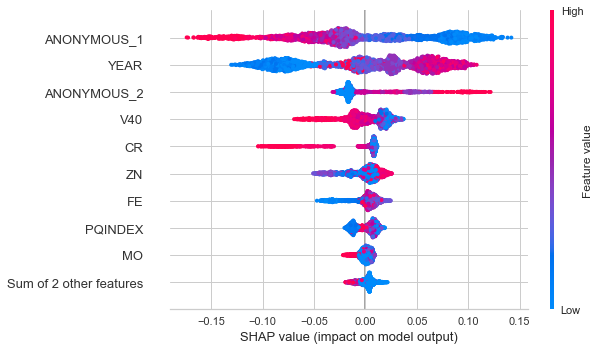

In [157]:
explainer_xgb = shap.Explainer(clf_xgb)
shap_values_xgb = explainer_xgb(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_xgb)

In [158]:
fi_xgb = pd.DataFrame(clf_xgb.feature_importances_, index=X_train2.columns, columns=['feature_importance_xgb']).sort_values('feature_importance_xgb', ascending=False)
fi_xgb

feature_importance_xgb
ANONYMOUS_1                0.138921
YEAR                       0.136993
CR                         0.135990
ANONYMOUS_2                0.104610
NI                         0.078031
V40                        0.076289
FE                         0.068828
MO                         0.065952
ZN                         0.065507
PQINDEX                    0.065148
CU                         0.063733

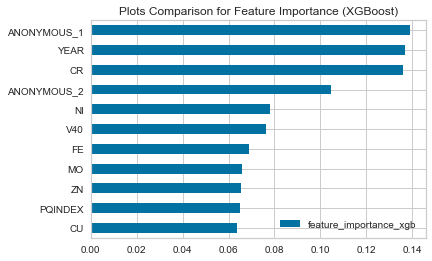

In [159]:
fi_xgb[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (XGBoost)')
plt.show()

### LGBM

In [160]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyLGBM = optuna.create_study(direction='minimize')

# n_trials 지정
studyLGBM.optimize(lambda trial: objectiveLGBM(trial, X_train2, y_train2, X_test, y_test), n_trials=100) 

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-12-08 22:49:09,207] A new study created in memory with name: no-name-1d8ed32b-2301-4d56-867b-52e32ec23abf
[I 2022-12-08 22:49:09,507] Trial 0 finished with value: 0.25143154015831076 and parameters: {'n_estimators': 371, 'reg_alpha': 0.16701932769837305, 'reg_lambda': 0.25813575007496303, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 4.381077286408215e-06, 'num_leaves': 128, 'min_child_samples': 134, 'min_data_per_groups': 81}. Best is trial 0 with value: 0.25143154015831076.
[I 2022-12-08 22:49:10,291] Trial 1 finished with value: 0.24617577143852518 and parameters: {'n_estimators': 407, 'reg_alpha': 0.0012589244675741025, 'reg_lambda': 0.015734494214955704, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.0007566184257941978, 'num_leaves': 1024, 'min_child_samples': 122, 'min_data_per_groups': 58}. Best is trial 1 with value: 0.24617577143852518.
[I 2022-12-08 22:49:10,492] Trial 2 finished with value: 0.25146898346671887 and parameters: {'n_estimat

[I 2022-12-08 22:49:20,192] Trial 21 finished with value: 0.2254288987796511 and parameters: {'n_estimators': 260, 'reg_alpha': 1.4263321889898184, 'reg_lambda': 0.0022137320524398558, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.009793231580816249, 'num_leaves': 256, 'min_child_samples': 30, 'min_data_per_groups': 84}. Best is trial 21 with value: 0.2254288987796511.
[I 2022-12-08 22:49:20,710] Trial 22 finished with value: 0.2392729620059594 and parameters: {'n_estimators': 261, 'reg_alpha': 2.1193735206393916, 'reg_lambda': 0.011174289241855578, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.00305467389230452, 'num_leaves': 256, 'min_child_samples': 89, 'min_data_per_groups': 78}. Best is trial 21 with value: 0.2254288987796511.
[I 2022-12-08 22:49:22,701] Trial 23 finished with value: 0.24638244652084493 and parameters: {'n_estimators': 344, 'reg_alpha': 0.06464443061000795, 'reg_lambda': 0.004109624995028872, 'colsample_bytree': 0.7, 'subsample': 0.

[I 2022-12-08 22:49:34,564] Trial 42 finished with value: 0.2323482312080296 and parameters: {'n_estimators': 192, 'reg_alpha': 0.06805721593369662, 'reg_lambda': 0.013464400792012167, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.005878070534469883, 'num_leaves': 256, 'min_child_samples': 63, 'min_data_per_groups': 75}. Best is trial 31 with value: 0.2239572086016281.
[I 2022-12-08 22:49:35,141] Trial 43 finished with value: 0.23168427201473432 and parameters: {'n_estimators': 282, 'reg_alpha': 0.016842936065378428, 'reg_lambda': 0.006251052571570266, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.004580092280249562, 'num_leaves': 256, 'min_child_samples': 89, 'min_data_per_groups': 65}. Best is trial 31 with value: 0.2239572086016281.
[I 2022-12-08 22:49:38,240] Trial 44 finished with value: 0.24418687290767738 and parameters: {'n_estimators': 253, 'reg_alpha': 0.032126520504706484, 'reg_lambda': 0.0019576397336526193, 'colsample_bytree': 0.9, 'subsampl

[I 2022-12-08 22:49:52,073] Trial 63 finished with value: 0.22887228201962487 and parameters: {'n_estimators': 355, 'reg_alpha': 0.41654124726533137, 'reg_lambda': 1.9824237729234684, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.005263251936440075, 'num_leaves': 128, 'min_child_samples': 82, 'min_data_per_groups': 26}. Best is trial 31 with value: 0.2239572086016281.
[I 2022-12-08 22:49:53,477] Trial 64 finished with value: 0.24242776738890115 and parameters: {'n_estimators': 474, 'reg_alpha': 1.8822840432649204, 'reg_lambda': 0.7119501413276105, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.0008887992650462742, 'num_leaves': 16, 'min_child_samples': 96, 'min_data_per_groups': 33}. Best is trial 31 with value: 0.2239572086016281.
[I 2022-12-08 22:49:55,040] Trial 65 finished with value: 0.2257440949673839 and parameters: {'n_estimators': 392, 'reg_alpha': 0.7561568650743601, 'reg_lambda': 4.110384683845262, 'colsample_bytree': 0.8, 'subsample': 0.5, 'le

[I 2022-12-08 22:50:23,967] Trial 84 finished with value: 0.23141676370629596 and parameters: {'n_estimators': 429, 'reg_alpha': 0.05595659060322857, 'reg_lambda': 0.009865015441788283, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.0024567586170907386, 'num_leaves': 256, 'min_child_samples': 20, 'min_data_per_groups': 19}. Best is trial 31 with value: 0.2239572086016281.
[I 2022-12-08 22:50:24,869] Trial 85 finished with value: 0.23533465813963605 and parameters: {'n_estimators': 268, 'reg_alpha': 0.2950511593861909, 'reg_lambda': 0.07465192562740995, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.0073331886011551075, 'num_leaves': 128, 'min_child_samples': 42, 'min_data_per_groups': 24}. Best is trial 31 with value: 0.2239572086016281.
[I 2022-12-08 22:50:26,671] Trial 86 finished with value: 0.2301222610803093 and parameters: {'n_estimators': 406, 'reg_alpha': 0.8233511993826683, 'reg_lambda': 0.2045082096148441, 'colsample_bytree': 0.6, 'subsample': 0.

study.best_params: 0.2229708007254185
Number of finished trials: 100
Best trial: {'n_estimators': 346, 'reg_alpha': 0.28112042783603686, 'reg_lambda': 0.008237225574878798, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.00781756919193459, 'num_leaves': 64, 'min_child_samples': 44, 'min_data_per_groups': 72}
study.best_params: {'n_estimators': 346, 'reg_alpha': 0.28112042783603686, 'reg_lambda': 0.008237225574878798, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.00781756919193459, 'num_leaves': 64, 'min_child_samples': 44, 'min_data_per_groups': 72}


In [161]:
param_lgbm = studyLGBM.best_params

clf_lgbm = lgb.LGBMRegressor(**param_lgbm, max_depth=-1, random_state=42)

In [162]:
clf_lgbm.fit(X_train2, y_train2)

pred_test_lgbm = clf_lgbm.predict(X_test)

y_test['pred_lgbm'] = [labeling(pred, threshold=0.6) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE : 0.223
F1 Score : 0.2318
Macro F1 Score : 0.5778 

[[2369  193]
 [ 198   59]]


In [163]:
optuna.visualization.plot_param_importances(studyLGBM)

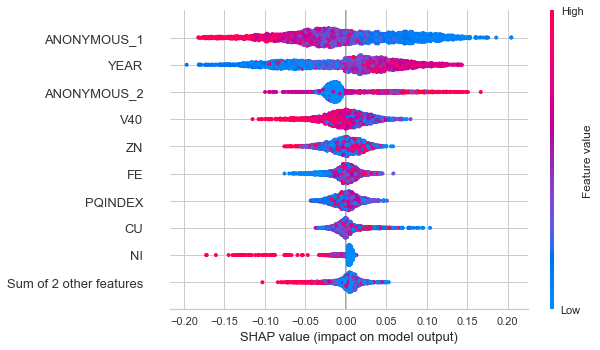

In [164]:
explainer_lgbm = shap.Explainer(clf_lgbm)
shap_values_lgbm = explainer_lgbm(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_lgbm)

In [165]:
fi_lgbm = pd.DataFrame(clf_lgbm.feature_importances_, index=X_train2.columns, columns=['feature_importance_lgbm']).sort_values('feature_importance_lgbm', ascending=False)
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                     2689
V40                             2393
ZN                              2207
FE                              2047
PQINDEX                         1660
YEAR                            1500
CU                              1422
ANONYMOUS_2                     1048
MO                               851
CR                               395
NI                               300

In [166]:
fi_lgbm['feature_importance_lgbm'] = fi_lgbm['feature_importance_lgbm'] / fi_lgbm['feature_importance_lgbm'].sum()
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                 0.162851
V40                         0.144925
ZN                          0.133660
FE                          0.123970
PQINDEX                     0.100533
YEAR                        0.090843
CU                          0.086119
ANONYMOUS_2                 0.063469
MO                          0.051538
CR                          0.023922
NI                          0.018169

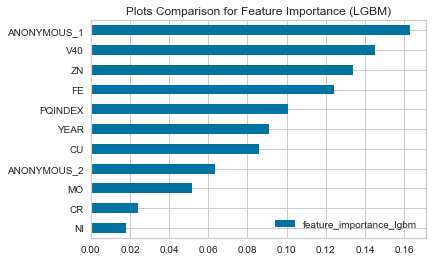

In [167]:
fi_lgbm[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (LGBM)')
plt.show()

### CatBoost

In [168]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyCB = optuna.create_study(direction='minimize')

# n_trials 지정
studyCB.optimize(lambda trial: objectiveCB(trial, X_train2, y_train2, X_test, y_test), n_trials=100) 

print('study.best_params:', studyCB.best_trial.value)
print('Number of finished trials:', len(studyCB.trials))
print('Best trial:', studyCB.best_trial.params)
print('study.best_params:', studyCB.best_params)

[I 2022-12-08 22:53:40,292] A new study created in memory with name: no-name-a967a0db-a5c9-445e-b03f-7f3392453f54
[I 2022-12-08 22:53:44,074] Trial 0 finished with value: 0.22711074286933688 and parameters: {'l2_leaf_reg': 0.6107687229722526, 'max_bin': 217, 'learning_rate': 0.015910620096521687, 'n_estimators': 408, 'max_depth': 10, 'min_data_in_leaf': 114}. Best is trial 0 with value: 0.22711074286933688.
[I 2022-12-08 22:53:44,604] Trial 1 finished with value: 0.22898279684646353 and parameters: {'l2_leaf_reg': 8.595977347343933, 'max_bin': 270, 'learning_rate': 0.0112937537989348, 'n_estimators': 387, 'max_depth': 3, 'min_data_in_leaf': 55}. Best is trial 0 with value: 0.22711074286933688.
[I 2022-12-08 22:53:45,041] Trial 2 finished with value: 0.23553899683971888 and parameters: {'l2_leaf_reg': 1.6587457583560419, 'max_bin': 300, 'learning_rate': 0.006326063540660681, 'n_estimators': 296, 'max_depth': 3, 'min_data_in_leaf': 116}. Best is trial 0 with value: 0.22711074286933688.
[

[I 2022-12-08 22:56:04,938] Trial 27 finished with value: 0.22546910613675689 and parameters: {'l2_leaf_reg': 2.656565505811388, 'max_bin': 303, 'learning_rate': 0.014707620697890712, 'n_estimators': 432, 'max_depth': 7, 'min_data_in_leaf': 229}. Best is trial 21 with value: 0.2242516569703638.
[I 2022-12-08 22:56:05,536] Trial 28 finished with value: 0.23159524159030356 and parameters: {'l2_leaf_reg': 0.014640934389125802, 'max_bin': 316, 'learning_rate': 0.00853920950604975, 'n_estimators': 268, 'max_depth': 4, 'min_data_in_leaf': 138}. Best is trial 21 with value: 0.2242516569703638.
[I 2022-12-08 22:56:06,372] Trial 29 finished with value: 0.2255792131419726 and parameters: {'l2_leaf_reg': 0.24246862217659015, 'max_bin': 218, 'learning_rate': 0.0163584741336415, 'n_estimators': 415, 'max_depth': 6, 'min_data_in_leaf': 244}. Best is trial 21 with value: 0.2242516569703638.
[I 2022-12-08 22:56:08,554] Trial 30 finished with value: 0.22815831807983394 and parameters: {'l2_leaf_reg': 0

[I 2022-12-08 22:57:36,380] Trial 54 finished with value: 0.2264304215374544 and parameters: {'l2_leaf_reg': 0.048591508774191855, 'max_bin': 393, 'learning_rate': 0.013266563654378827, 'n_estimators': 371, 'max_depth': 8, 'min_data_in_leaf': 70}. Best is trial 53 with value: 0.22238285815359266.
[I 2022-12-08 22:57:42,353] Trial 55 finished with value: 0.2261770151372801 and parameters: {'l2_leaf_reg': 0.01935363867232289, 'max_bin': 376, 'learning_rate': 0.011533822257336257, 'n_estimators': 424, 'max_depth': 9, 'min_data_in_leaf': 99}. Best is trial 53 with value: 0.22238285815359266.
[I 2022-12-08 22:57:45,672] Trial 56 finished with value: 0.22554669883735612 and parameters: {'l2_leaf_reg': 0.152616866507005, 'max_bin': 385, 'learning_rate': 0.012281201122658144, 'n_estimators': 395, 'max_depth': 8, 'min_data_in_leaf': 71}. Best is trial 53 with value: 0.22238285815359266.
[I 2022-12-08 22:57:47,260] Trial 57 finished with value: 0.22711084959272237 and parameters: {'l2_leaf_reg':

[I 2022-12-08 22:58:56,962] Trial 81 finished with value: 0.22486194183235242 and parameters: {'l2_leaf_reg': 0.1322930824296972, 'max_bin': 336, 'learning_rate': 0.012531223876327033, 'n_estimators': 487, 'max_depth': 9, 'min_data_in_leaf': 39}. Best is trial 53 with value: 0.22238285815359266.
[I 2022-12-08 22:59:05,460] Trial 82 finished with value: 0.22540825445720983 and parameters: {'l2_leaf_reg': 0.20449113993641074, 'max_bin': 367, 'learning_rate': 0.012871724205549275, 'n_estimators': 469, 'max_depth': 8, 'min_data_in_leaf': 1}. Best is trial 53 with value: 0.22238285815359266.
[I 2022-12-08 22:59:09,682] Trial 83 finished with value: 0.22477113014250208 and parameters: {'l2_leaf_reg': 0.05728121660097519, 'max_bin': 394, 'learning_rate': 0.011555099737449887, 'n_estimators': 454, 'max_depth': 7, 'min_data_in_leaf': 15}. Best is trial 53 with value: 0.22238285815359266.
[I 2022-12-08 22:59:15,190] Trial 84 finished with value: 0.22468590031760466 and parameters: {'l2_leaf_reg'

study.best_params: 0.22238285815359266
Number of finished trials: 100
Best trial: {'l2_leaf_reg': 0.06649448838397229, 'max_bin': 382, 'learning_rate': 0.013386842751462055, 'n_estimators': 426, 'max_depth': 8, 'min_data_in_leaf': 79}
study.best_params: {'l2_leaf_reg': 0.06649448838397229, 'max_bin': 382, 'learning_rate': 0.013386842751462055, 'n_estimators': 426, 'max_depth': 8, 'min_data_in_leaf': 79}


In [183]:
param_cat = studyCB.best_params

clf_cat2 = CatBoostRegressor(**param_cat, random_state=42)

In [184]:
clf_cat2.fit(X_train2, y_train2)

pred_test_cat = clf_cat2.predict(X_test)

y_test['pred_cat'] = [labeling(pred, threshold=0.6) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

0:	learn: 0.3804062	total: 6.9ms	remaining: 2.93s
1:	learn: 0.3798865	total: 13.5ms	remaining: 2.86s
2:	learn: 0.3793314	total: 20.4ms	remaining: 2.88s
3:	learn: 0.3788726	total: 27.9ms	remaining: 2.94s
4:	learn: 0.3783929	total: 35.5ms	remaining: 2.99s
5:	learn: 0.3778233	total: 43ms	remaining: 3.01s
6:	learn: 0.3772324	total: 51.1ms	remaining: 3.06s
7:	learn: 0.3767710	total: 59ms	remaining: 3.08s
8:	learn: 0.3762673	total: 67.6ms	remaining: 3.13s
9:	learn: 0.3758007	total: 76.1ms	remaining: 3.16s
10:	learn: 0.3752758	total: 84.1ms	remaining: 3.17s
11:	learn: 0.3748035	total: 92.4ms	remaining: 3.19s
12:	learn: 0.3741897	total: 101ms	remaining: 3.2s
13:	learn: 0.3736871	total: 109ms	remaining: 3.21s
14:	learn: 0.3732804	total: 118ms	remaining: 3.23s
15:	learn: 0.3728039	total: 127ms	remaining: 3.25s
16:	learn: 0.3723799	total: 136ms	remaining: 3.26s
17:	learn: 0.3719291	total: 144ms	remaining: 3.27s
18:	learn: 0.3714936	total: 153ms	remaining: 3.27s
19:	learn: 0.3710823	total: 162ms	r

161:	learn: 0.3384405	total: 1.72s	remaining: 2.81s
162:	learn: 0.3382772	total: 1.74s	remaining: 2.81s
163:	learn: 0.3381204	total: 1.75s	remaining: 2.8s
164:	learn: 0.3379798	total: 1.77s	remaining: 2.79s
165:	learn: 0.3378030	total: 1.78s	remaining: 2.79s
166:	learn: 0.3376739	total: 1.79s	remaining: 2.78s
167:	learn: 0.3375682	total: 1.8s	remaining: 2.77s
168:	learn: 0.3374388	total: 1.81s	remaining: 2.76s
169:	learn: 0.3373007	total: 1.83s	remaining: 2.75s
170:	learn: 0.3371569	total: 1.86s	remaining: 2.78s
171:	learn: 0.3369442	total: 1.88s	remaining: 2.78s
172:	learn: 0.3368435	total: 1.9s	remaining: 2.77s
173:	learn: 0.3367651	total: 1.91s	remaining: 2.76s
174:	learn: 0.3366150	total: 1.93s	remaining: 2.76s
175:	learn: 0.3364389	total: 1.94s	remaining: 2.76s
176:	learn: 0.3362715	total: 1.95s	remaining: 2.75s
177:	learn: 0.3361331	total: 1.97s	remaining: 2.74s
178:	learn: 0.3360119	total: 1.98s	remaining: 2.73s
179:	learn: 0.3359065	total: 2.02s	remaining: 2.75s
180:	learn: 0.3

321:	learn: 0.3191210	total: 3.85s	remaining: 1.25s
322:	learn: 0.3190262	total: 3.87s	remaining: 1.23s
323:	learn: 0.3189513	total: 3.88s	remaining: 1.22s
324:	learn: 0.3188881	total: 3.89s	remaining: 1.21s
325:	learn: 0.3188696	total: 3.9s	remaining: 1.2s
326:	learn: 0.3187432	total: 3.91s	remaining: 1.18s
327:	learn: 0.3186738	total: 3.93s	remaining: 1.17s
328:	learn: 0.3186116	total: 3.94s	remaining: 1.16s
329:	learn: 0.3185384	total: 3.95s	remaining: 1.15s
330:	learn: 0.3184120	total: 3.96s	remaining: 1.14s
331:	learn: 0.3183733	total: 3.98s	remaining: 1.13s
332:	learn: 0.3183211	total: 4s	remaining: 1.12s
333:	learn: 0.3181940	total: 4.01s	remaining: 1.1s
334:	learn: 0.3181267	total: 4.02s	remaining: 1.09s
335:	learn: 0.3180670	total: 4.04s	remaining: 1.08s
336:	learn: 0.3179416	total: 4.05s	remaining: 1.07s
337:	learn: 0.3178530	total: 4.07s	remaining: 1.06s
338:	learn: 0.3178036	total: 4.08s	remaining: 1.05s
339:	learn: 0.3177544	total: 4.09s	remaining: 1.03s
340:	learn: 0.3176

In [171]:
optuna.visualization.plot_param_importances(studyCB)

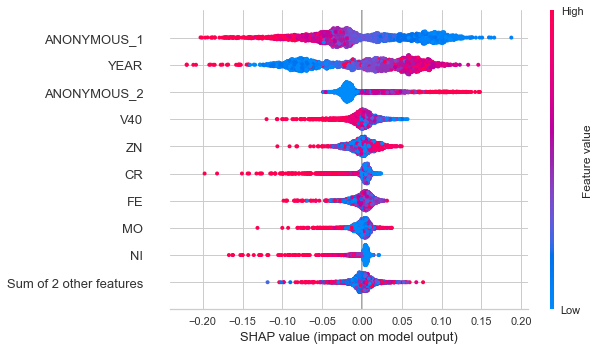

In [172]:
explainer_cat = shap.Explainer(clf_cat2)
shap_values_cat = explainer_cat(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_cat)

In [173]:
fi_cat = pd.DataFrame(clf_cat2.feature_importances_, index=X_train2.columns, columns=['feature_importance_cat']).sort_values('feature_importance_cat', ascending=False)
fi_cat

feature_importance_cat
YEAR                      18.905907
ANONYMOUS_1               18.687862
ANONYMOUS_2                9.037638
V40                        8.653539
ZN                         8.119150
FE                         8.111697
PQINDEX                    6.840190
MO                         6.129017
CR                         5.761526
CU                         5.428345
NI                         4.325130

In [174]:
fi_cat['feature_importance_cat'] = fi_cat['feature_importance_cat'] / fi_cat['feature_importance_cat'].sum()
fi_cat

feature_importance_cat
YEAR                       0.189059
ANONYMOUS_1                0.186879
ANONYMOUS_2                0.090376
V40                        0.086535
ZN                         0.081192
FE                         0.081117
PQINDEX                    0.068402
MO                         0.061290
CR                         0.057615
CU                         0.054283
NI                         0.043251

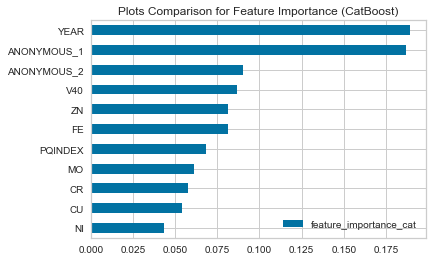

In [175]:
fi_cat[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (CatBoost)')
plt.show()

### Extra Tree

In [176]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyET = optuna.create_study(direction='minimize')

# n_trials 지정
studyET.optimize(lambda trial: objectiveET(trial, X_train2, y_train2, X_test, y_test), n_trials=100) 

print('study.best_params:', studyET.best_trial.value)
print('Number of finished trials:', len(studyET.trials))
print('Best trial:', studyET.best_trial.params)
print('study.best_params:', studyET.best_params)

[I 2022-12-08 23:02:54,797] A new study created in memory with name: no-name-1dabea1f-5ac5-46e0-8b09-2c32ac5aad5c
[I 2022-12-08 23:02:57,824] Trial 0 finished with value: 0.22280983668519744 and parameters: {'max_depth': 9, 'max_leaf_nodes': 824, 'n_estimators': 246}. Best is trial 0 with value: 0.22280983668519744.
[I 2022-12-08 23:02:59,793] Trial 1 finished with value: 0.22368373513812226 and parameters: {'max_depth': 8, 'max_leaf_nodes': 288, 'n_estimators': 155}. Best is trial 0 with value: 0.22280983668519744.
[I 2022-12-08 23:03:06,945] Trial 2 finished with value: 0.2249304377494519 and parameters: {'max_depth': 13, 'max_leaf_nodes': 68, 'n_estimators': 481}. Best is trial 0 with value: 0.22280983668519744.
[I 2022-12-08 23:03:09,391] Trial 3 finished with value: 0.23034023877642582 and parameters: {'max_depth': 5, 'max_leaf_nodes': 136, 'n_estimators': 298}. Best is trial 0 with value: 0.22280983668519744.
[I 2022-12-08 23:03:09,997] Trial 4 finished with value: 0.234160188967

[I 2022-12-08 23:04:06,135] Trial 37 finished with value: 0.2224944129596092 and parameters: {'max_depth': 10, 'max_leaf_nodes': 129, 'n_estimators': 318}. Best is trial 31 with value: 0.22162050256478463.
[I 2022-12-08 23:04:09,455] Trial 38 finished with value: 0.2228683868702117 and parameters: {'max_depth': 12, 'max_leaf_nodes': 429, 'n_estimators': 443}. Best is trial 31 with value: 0.22162050256478463.
[I 2022-12-08 23:04:10,948] Trial 39 finished with value: 0.22722017996774801 and parameters: {'max_depth': 6, 'max_leaf_nodes': 255, 'n_estimators': 379}. Best is trial 31 with value: 0.22162050256478463.
[I 2022-12-08 23:04:12,024] Trial 40 finished with value: 0.22370966679355014 and parameters: {'max_depth': 8, 'max_leaf_nodes': 382, 'n_estimators': 216}. Best is trial 31 with value: 0.22162050256478463.
[I 2022-12-08 23:04:13,729] Trial 41 finished with value: 0.22177664735066624 and parameters: {'max_depth': 10, 'max_leaf_nodes': 314, 'n_estimators': 264}. Best is trial 31 wi

[I 2022-12-08 23:05:45,301] Trial 75 finished with value: 0.2231949647313106 and parameters: {'max_depth': 11, 'max_leaf_nodes': 104, 'n_estimators': 498}. Best is trial 69 with value: 0.2213359487975191.
[I 2022-12-08 23:05:49,171] Trial 76 finished with value: 0.22278116373143383 and parameters: {'max_depth': 12, 'max_leaf_nodes': 150, 'n_estimators': 455}. Best is trial 69 with value: 0.2213359487975191.
[I 2022-12-08 23:05:53,795] Trial 77 finished with value: 0.22143959282308406 and parameters: {'max_depth': 11, 'max_leaf_nodes': 196, 'n_estimators': 425}. Best is trial 69 with value: 0.2213359487975191.
[I 2022-12-08 23:05:57,838] Trial 78 finished with value: 0.2243947951696382 and parameters: {'max_depth': 11, 'max_leaf_nodes': 74, 'n_estimators': 424}. Best is trial 69 with value: 0.2213359487975191.
[I 2022-12-08 23:06:03,232] Trial 79 finished with value: 0.2221240376016206 and parameters: {'max_depth': 12, 'max_leaf_nodes': 191, 'n_estimators': 476}. Best is trial 69 with v

study.best_params: 0.22120831717483858
Number of finished trials: 100
Best trial: {'max_depth': 11, 'max_leaf_nodes': 232, 'n_estimators': 489}
study.best_params: {'max_depth': 11, 'max_leaf_nodes': 232, 'n_estimators': 489}


In [177]:
param_et = studyET.best_params

clf_et = ExtraTreesRegressor(**param_et, random_state=42)

In [178]:
clf_et.fit(X_train2, y_train2)

pred_test_et = clf_et.predict(X_test)

y_test['pred_et'] = [labeling(pred, threshold=0.6) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.2212
F1 Score : 0.2384
Macro F1 Score : 0.5825 

[[2383  193]
 [ 184   59]]


In [179]:
optuna.visualization.plot_param_importances(studyET)

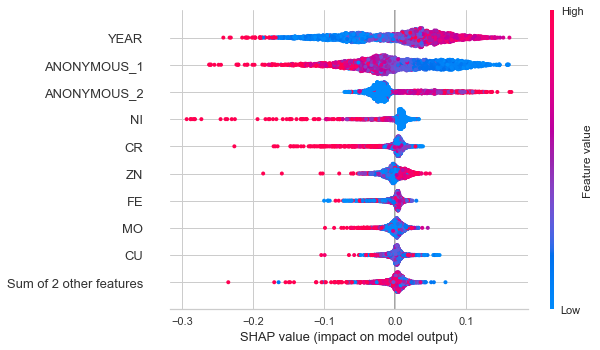

In [180]:
explainer_et = shap.Explainer(clf_et)
shap_values_et = explainer_et(X_train2)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_et)

In [181]:
fi_et = pd.DataFrame(clf_et.feature_importances_, index=X_train2.columns, columns=['feature_importance_et']).sort_values('feature_importance_et', ascending=False)
fi_et

feature_importance_et
ANONYMOUS_1               0.187087
YEAR                      0.182376
ANONYMOUS_2               0.080092
CR                        0.073552
CU                        0.073475
FE                        0.073273
V40                       0.070693
ZN                        0.066730
NI                        0.065895
PQINDEX                   0.063814
MO                        0.063013

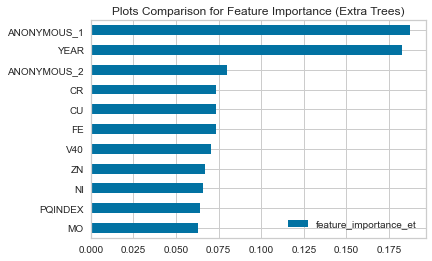

In [182]:
fi_et[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Extra Trees)')
plt.show()

## Dataset 3

### Decision Tree

In [185]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyDT=optuna.create_study(direction='minimize')

# n_trials 지정
studyDT.optimize(lambda trial: objectiveDT(trial, X_train3, y_train3, X_test, y_test), n_trials=100) 

print('study.best_params:', studyDT.best_trial.value)
print('Number of finished trials:', len(studyDT.trials))
print('Best trial:', studyDT.best_trial.params)
print('study.best_params:', studyDT.best_params)

[I 2022-12-08 23:19:26,415] A new study created in memory with name: no-name-83f320d5-efd0-4963-bf50-1b58f5b2e660
[I 2022-12-08 23:19:26,428] Trial 0 finished with value: 0.22481720365334693 and parameters: {'max_depth': 7, 'max_leaf_nodes': 23}. Best is trial 0 with value: 0.22481720365334693.
[I 2022-12-08 23:19:26,447] Trial 1 finished with value: 0.22826479461901247 and parameters: {'max_depth': 12, 'max_leaf_nodes': 336}. Best is trial 0 with value: 0.22481720365334693.
[I 2022-12-08 23:19:26,461] Trial 2 finished with value: 0.21963418643300597 and parameters: {'max_depth': 7, 'max_leaf_nodes': 613}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:26,473] Trial 3 finished with value: 0.21997055977287902 and parameters: {'max_depth': 6, 'max_leaf_nodes': 345}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:26,492] Trial 4 finished with value: 0.22575248194258296 and parameters: {'max_depth': 13, 'max_leaf_nodes': 167}. Best is trial 2 wit

[I 2022-12-08 23:19:27,498] Trial 41 finished with value: 0.21963418643300597 and parameters: {'max_depth': 7, 'max_leaf_nodes': 910}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:27,546] Trial 42 finished with value: 0.21963418643300597 and parameters: {'max_depth': 7, 'max_leaf_nodes': 992}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:27,594] Trial 43 finished with value: 0.22102266860652708 and parameters: {'max_depth': 8, 'max_leaf_nodes': 659}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:27,644] Trial 44 finished with value: 0.21997055977287902 and parameters: {'max_depth': 6, 'max_leaf_nodes': 564}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:27,691] Trial 45 finished with value: 0.21997055977287902 and parameters: {'max_depth': 6, 'max_leaf_nodes': 993}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:27,735] Trial 46 finished with value: 0.21963418643300597 an

[I 2022-12-08 23:19:29,321] Trial 83 finished with value: 0.21997055977287902 and parameters: {'max_depth': 6, 'max_leaf_nodes': 629}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:29,363] Trial 84 finished with value: 0.21963418643300597 and parameters: {'max_depth': 7, 'max_leaf_nodes': 475}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:29,408] Trial 85 finished with value: 0.21963418643300597 and parameters: {'max_depth': 7, 'max_leaf_nodes': 885}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:29,447] Trial 86 finished with value: 0.21997055977287902 and parameters: {'max_depth': 6, 'max_leaf_nodes': 449}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:29,492] Trial 87 finished with value: 0.22102266860652708 and parameters: {'max_depth': 8, 'max_leaf_nodes': 612}. Best is trial 2 with value: 0.21963418643300597.
[I 2022-12-08 23:19:29,532] Trial 88 finished with value: 0.21963418643300597 an

study.best_params: 0.21963418643300597
Number of finished trials: 100
Best trial: {'max_depth': 7, 'max_leaf_nodes': 613}
study.best_params: {'max_depth': 7, 'max_leaf_nodes': 613}


In [186]:
param_dt = studyDT.best_params

clf_dt = DecisionTreeRegressor(**param_dt, random_state=42)

In [187]:
clf_dt.fit(X_train3, y_train3)

pred_test_dt = clf_dt.predict(X_test)

y_test['pred_dt'] = [labeling(pred, threshold=0.6) for pred in pred_test_dt]

print('MAE :', round(mean_absolute_error(pred_test_dt, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_dt, y_test.Y_LABEL))

MAE : 0.2196
F1 Score : 0.1765
Macro F1 Score : 0.5412 

[[2292  201]
 [ 275   51]]


In [188]:
optuna.visualization.plot_param_importances(studyDT)

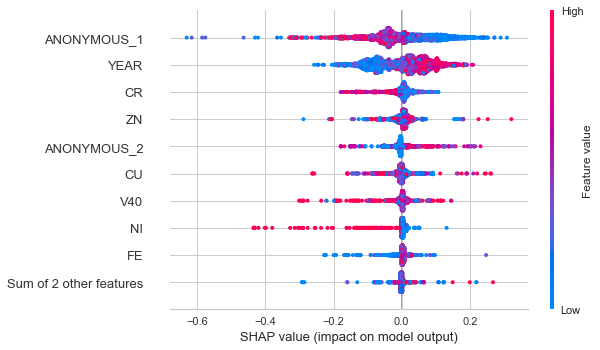

In [189]:
explainer_dt = shap.Explainer(clf_dt)
shap_values_dt = explainer_dt(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_dt)

In [190]:
fi_dt = pd.DataFrame(clf_dt.feature_importances_, index=X_train3.columns, columns=['feature_importance_dt']).sort_values('feature_importance_dt', ascending=False)
fi_dt

feature_importance_dt
ANONYMOUS_1               0.249238
YEAR                      0.175918
ZN                        0.112376
CU                        0.097694
V40                       0.092480
NI                        0.085239
ANONYMOUS_2               0.072161
PQINDEX                   0.047292
CR                        0.040509
FE                        0.027044
MO                        0.000049

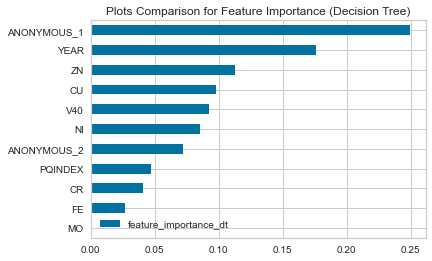

In [191]:
fi_dt[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Decision Tree)')
plt.show()

### SVR

In [192]:
# MAE가 최소가 되는 방향으로 학습을 진행
studySVR=optuna.create_study(direction='minimize')

# n_trials 지정
studySVR.optimize(lambda trial: objectiveSVR(trial, X_train3, y_train3, X_test, y_test), n_trials=100) 

print('study.best_params:', studySVR.best_trial.value)
print('Number of finished trials:', len(studySVR.trials))
print('Best trial:', studySVR.best_trial.params)
print('study.best_params:', studySVR.best_params)

[I 2022-12-08 23:22:34,328] A new study created in memory with name: no-name-f6aabe51-c7a4-4b02-b9e9-aea7f0d26e1c
[I 2022-12-08 23:22:35,229] Trial 0 finished with value: 0.4442957432168284 and parameters: {'C': 5.173842102331582, 'degree': 2, 'gamma': 0.00286338740702666, 'epsilon': 0.47512539405797616}. Best is trial 0 with value: 0.4442957432168284.
[I 2022-12-08 23:22:36,390] Trial 1 finished with value: 0.34838171451069966 and parameters: {'C': 1.0070792321644886, 'degree': 5, 'gamma': 0.0029468050374513617, 'epsilon': 0.35278913973590753}. Best is trial 1 with value: 0.34838171451069966.
[I 2022-12-08 23:22:37,415] Trial 2 finished with value: 0.30838201705331547 and parameters: {'C': 0.31874680390876126, 'degree': 3, 'gamma': 0.0013021076937133338, 'epsilon': 0.30634543630022626}. Best is trial 2 with value: 0.30838201705331547.
[I 2022-12-08 23:22:38,748] Trial 3 finished with value: 0.2404597553033593 and parameters: {'C': 0.5012539446810641, 'degree': 5, 'gamma': 0.0040738947

[I 2022-12-08 23:23:15,004] Trial 32 finished with value: 0.1357212366098215 and parameters: {'C': 0.49110491211591567, 'degree': 4, 'gamma': 0.0034145594599915676, 'epsilon': 0.07882772489279972}. Best is trial 32 with value: 0.1357212366098215.
[I 2022-12-08 23:23:16,013] Trial 33 finished with value: 0.13329097844156323 and parameters: {'C': 0.4213271055688508, 'degree': 4, 'gamma': 0.0027586166158480255, 'epsilon': 0.07810347536307817}. Best is trial 33 with value: 0.13329097844156323.
[I 2022-12-08 23:23:17,004] Trial 34 finished with value: 0.20401614930433146 and parameters: {'C': 0.4130768162030252, 'degree': 4, 'gamma': 0.0026846100114831127, 'epsilon': 0.17044639676325526}. Best is trial 33 with value: 0.13329097844156323.
[I 2022-12-08 23:23:18,054] Trial 35 finished with value: 0.13835895497658654 and parameters: {'C': 0.443451772322091, 'degree': 3, 'gamma': 0.0034575082372742907, 'epsilon': 0.08306104138405891}. Best is trial 33 with value: 0.13329097844156323.
[I 2022-12

[I 2022-12-08 23:23:46,430] Trial 64 finished with value: 0.3232965913092743 and parameters: {'C': 0.7833384873929109, 'degree': 5, 'gamma': 0.0010724615911943576, 'epsilon': 0.3246037338373561}. Best is trial 54 with value: 0.10967022740007122.
[I 2022-12-08 23:23:47,483] Trial 65 finished with value: 0.11277101821103969 and parameters: {'C': 1.1123846641957136, 'degree': 5, 'gamma': 0.0011373394893728216, 'epsilon': 0.05017243325463292}. Best is trial 54 with value: 0.10967022740007122.
[I 2022-12-08 23:23:48,506] Trial 66 finished with value: 0.11223081822218665 and parameters: {'C': 0.7657666249556795, 'degree': 6, 'gamma': 0.0011644900299142787, 'epsilon': 0.051757545370925806}. Best is trial 54 with value: 0.10967022740007122.
[I 2022-12-08 23:23:49,475] Trial 67 finished with value: 0.14382682871995553 and parameters: {'C': 0.49837098494663123, 'degree': 6, 'gamma': 0.001382279129439227, 'epsilon': 0.09657785727788942}. Best is trial 54 with value: 0.10967022740007122.
[I 2022-1

[I 2022-12-08 23:24:19,763] Trial 96 finished with value: 0.24781812219102828 and parameters: {'C': 0.5682836100823343, 'degree': 7, 'gamma': 0.001961063944897821, 'epsilon': 0.22642617526574976}. Best is trial 89 with value: 0.10882169607413499.
[I 2022-12-08 23:24:20,770] Trial 97 finished with value: 0.11838099698212995 and parameters: {'C': 0.3803606402424917, 'degree': 7, 'gamma': 0.0014337060777618138, 'epsilon': 0.06370749277465523}. Best is trial 89 with value: 0.10882169607413499.
[I 2022-12-08 23:24:21,779] Trial 98 finished with value: 0.1400684604511067 and parameters: {'C': 0.5426063292534703, 'degree': 7, 'gamma': 0.0015981040949863835, 'epsilon': 0.09025107360477647}. Best is trial 89 with value: 0.10882169607413499.
[I 2022-12-08 23:24:22,815] Trial 99 finished with value: 0.11634353046508322 and parameters: {'C': 0.6181127069121626, 'degree': 7, 'gamma': 0.0011186402529221122, 'epsilon': 0.05960409528654766}. Best is trial 89 with value: 0.10882169607413499.


study.best_params: 0.10882169607413499
Number of finished trials: 100
Best trial: {'C': 0.39707829287161517, 'degree': 7, 'gamma': 0.0010858443446789374, 'epsilon': 0.05042129341032593}
study.best_params: {'C': 0.39707829287161517, 'degree': 7, 'gamma': 0.0010858443446789374, 'epsilon': 0.05042129341032593}


In [193]:
param_svr = studySVR.best_params

clf_svr = SVR(**param_svr)

In [194]:
clf_svr.fit(X_train3, y_train3)

pred_test_svr = clf_svr.predict(X_test)

y_test['pred_svr'] = [labeling(pred, threshold=0.6) for pred in pred_test_svr]

print('MAE :', round(mean_absolute_error(pred_test_svr, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_svr, y_test.Y_LABEL))

MAE : 0.1088
F1 Score : 0.0154
Macro F1 Score : 0.484 

[[2562  250]
 [   5    2]]


In [195]:
optuna.visualization.plot_param_importances(studySVR)

### Random Forest Regressor

In [196]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyRF=optuna.create_study(direction='minimize')

# n_trials 지정
studyRF.optimize(lambda trial: objectiveRF(trial, X_train3, y_train3, X_test, y_test), n_trials=100) 

print('study.best_params:', studyRF.best_trial.value)
print('Number of finished trials:', len(studyRF.trials))
print('Best trial:', studyRF.best_trial.params)
print('study.best_params:', studyRF.best_params)

[I 2022-12-08 23:25:59,587] A new study created in memory with name: no-name-bf12683f-0111-40a6-ad76-4cb936b324ff
[I 2022-12-08 23:26:02,081] Trial 0 finished with value: 0.22538609888190209 and parameters: {'max_depth': 4, 'max_leaf_nodes': 158, 'n_estimators': 446}. Best is trial 0 with value: 0.22538609888190209.
[I 2022-12-08 23:26:02,451] Trial 1 finished with value: 0.220810869326758 and parameters: {'max_depth': 8, 'max_leaf_nodes': 24, 'n_estimators': 52}. Best is trial 1 with value: 0.220810869326758.
[I 2022-12-08 23:26:03,797] Trial 2 finished with value: 0.2298549615362597 and parameters: {'max_depth': 3, 'max_leaf_nodes': 221, 'n_estimators': 324}. Best is trial 1 with value: 0.220810869326758.
[I 2022-12-08 23:26:06,140] Trial 3 finished with value: 0.22306952525931198 and parameters: {'max_depth': 5, 'max_leaf_nodes': 19, 'n_estimators': 410}. Best is trial 1 with value: 0.220810869326758.
[I 2022-12-08 23:26:09,601] Trial 4 finished with value: 0.22024711043582296 and p

[I 2022-12-08 23:27:13,883] Trial 37 finished with value: 0.21690840668448486 and parameters: {'max_depth': 9, 'max_leaf_nodes': 677, 'n_estimators': 164}. Best is trial 28 with value: 0.21624578625750374.
[I 2022-12-08 23:27:14,717] Trial 38 finished with value: 0.21869318272569074 and parameters: {'max_depth': 6, 'max_leaf_nodes': 725, 'n_estimators': 77}. Best is trial 28 with value: 0.21624578625750374.
[I 2022-12-08 23:27:15,265] Trial 39 finished with value: 0.22897863898094828 and parameters: {'max_depth': 3, 'max_leaf_nodes': 422, 'n_estimators': 120}. Best is trial 28 with value: 0.21624578625750374.
[I 2022-12-08 23:27:17,128] Trial 40 finished with value: 0.21854497016159266 and parameters: {'max_depth': 11, 'max_leaf_nodes': 811, 'n_estimators': 158}. Best is trial 28 with value: 0.21624578625750374.
[I 2022-12-08 23:27:17,951] Trial 41 finished with value: 0.21629076574060432 and parameters: {'max_depth': 9, 'max_leaf_nodes': 552, 'n_estimators': 92}. Best is trial 28 with

[I 2022-12-08 23:27:56,366] Trial 75 finished with value: 0.21697818328554164 and parameters: {'max_depth': 10, 'max_leaf_nodes': 386, 'n_estimators': 107}. Best is trial 43 with value: 0.21601110833171833.
[I 2022-12-08 23:27:57,688] Trial 76 finished with value: 0.21677104332673383 and parameters: {'max_depth': 9, 'max_leaf_nodes': 470, 'n_estimators': 128}. Best is trial 43 with value: 0.21601110833171833.
[I 2022-12-08 23:27:58,277] Trial 77 finished with value: 0.21620005209498228 and parameters: {'max_depth': 8, 'max_leaf_nodes': 413, 'n_estimators': 66}. Best is trial 43 with value: 0.21601110833171833.
[I 2022-12-08 23:27:58,814] Trial 78 finished with value: 0.21712295101305595 and parameters: {'max_depth': 7, 'max_leaf_nodes': 432, 'n_estimators': 63}. Best is trial 43 with value: 0.21601110833171833.
[I 2022-12-08 23:27:59,559] Trial 79 finished with value: 0.21633160626882142 and parameters: {'max_depth': 8, 'max_leaf_nodes': 185, 'n_estimators': 76}. Best is trial 43 with 

study.best_params: 0.21595312797370242
Number of finished trials: 100
Best trial: {'max_depth': 9, 'max_leaf_nodes': 582, 'n_estimators': 60}
study.best_params: {'max_depth': 9, 'max_leaf_nodes': 582, 'n_estimators': 60}


In [197]:
param_rf = studyRF.best_params

clf_rf = RandomForestRegressor(**param_rf, random_state=42)

In [198]:
clf_rf.fit(X_train3, y_train3)

pred_test_rf = clf_rf.predict(X_test)

y_test['pred_rf'] = [labeling(pred, threshold=0.6) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.216
F1 Score : 0.2255
Macro F1 Score : 0.5768 

[[2394  198]
 [ 173   54]]


In [199]:
optuna.visualization.plot_param_importances(studyRF)

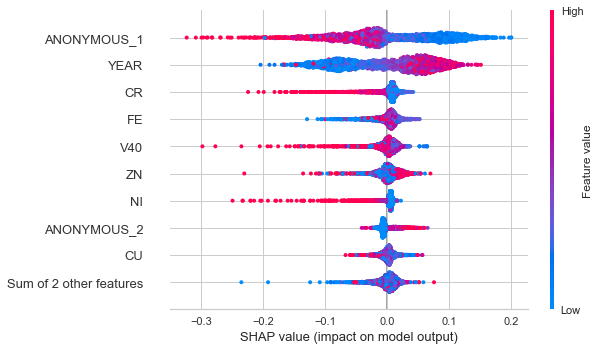

In [200]:
explainer_rf = shap.Explainer(clf_rf)
shap_values_rf = explainer_rf(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_rf)

In [201]:
fi_rf = pd.DataFrame(clf_rf.feature_importances_, index=X_train3.columns, columns=['feature_importance_rf']).sort_values('feature_importance_rf', ascending=False)
fi_rf

feature_importance_rf
ANONYMOUS_1               0.221101
YEAR                      0.129317
V40                       0.111908
ZN                        0.105460
FE                        0.096883
PQINDEX                   0.082770
CU                        0.070724
CR                        0.060212
MO                        0.044347
NI                        0.039696
ANONYMOUS_2               0.037582

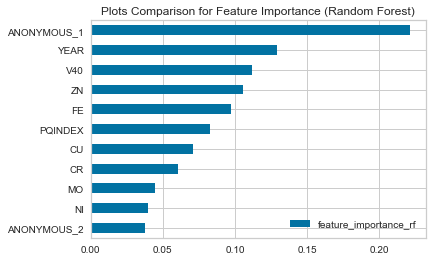

In [202]:
fi_rf[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Random Forest)')
plt.show()

### XGBRegressor

In [203]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X_train3, y_train3, X_test, y_test), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)

[I 2022-12-08 23:31:08,888] A new study created in memory with name: no-name-7b315eb9-70aa-4f44-8c83-7d636a912cb3
[I 2022-12-08 23:31:09,641] Trial 0 finished with value: 0.3207148185624092 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.003219639532845061, 'n_estimators': 287, 'subsample': 0.786241082264362, 'min_child_weight': 132, 'alpha': 0.0017656528600920897}. Best is trial 0 with value: 0.3207148185624092.
[I 2022-12-08 23:31:10,186] Trial 1 finished with value: 0.4628554467047643 and parameters: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 3.6295390751623755e-06, 'n_estimators': 182, 'subsample': 0.7093884068500016, 'min_child_weight': 9, 'alpha': 0.0025905096142737967}. Best is trial 0 with value: 0.3207148185624092.
[I 2022-12-08 23:31:10,763] Trial 2 finished with value: 0.46298418463936675 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 6.51452745936552e-07, 'n_estimators': 181, 's

[I 2022-12-08 23:31:48,658] Trial 23 finished with value: 0.36694318820473654 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.0015089154945783642, 'n_estimators': 349, 'subsample': 0.8945008443781672, 'min_child_weight': 161, 'alpha': 0.18270922156841105}. Best is trial 16 with value: 0.2315980332384214.
[I 2022-12-08 23:31:50,618] Trial 24 finished with value: 0.3525082443608084 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.001658044196111595, 'n_estimators': 383, 'subsample': 0.8729224367182038, 'min_child_weight': 127, 'alpha': 0.22546096586771588}. Best is trial 16 with value: 0.2315980332384214.
[I 2022-12-08 23:31:52,731] Trial 25 finished with value: 0.4424425003046175 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.0004303346071531709, 'n_estimators': 209, 'subsample': 0.8392367803576906, 'min_child_weight': 4, 'alpha': 1.1555110122732084}. Best is trial 16 with va

[I 2022-12-08 23:32:31,204] Trial 47 finished with value: 0.24741106898425191 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.0046824592554292254, 'n_estimators': 475, 'subsample': 0.8477089922917374, 'min_child_weight': 26, 'alpha': 0.025758761893615666}. Best is trial 46 with value: 0.2231125762418383.
[I 2022-12-08 23:32:34,231] Trial 48 finished with value: 0.4185630021309421 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.0004098438541420212, 'n_estimators': 500, 'subsample': 0.8078379299851105, 'min_child_weight': 15, 'alpha': 0.012167788840836002}. Best is trial 46 with value: 0.2231125762418383.
[I 2022-12-08 23:32:36,029] Trial 49 finished with value: 0.36004406303564424 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.0012527784427910813, 'n_estimators': 456, 'subsample': 0.7047782483342528, 'min_child_weight': 41, 'alpha': 0.13653981644349558}. Best is trial 46 wi

[I 2022-12-08 23:33:02,999] Trial 71 finished with value: 0.22705621843940194 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.009878381614735943, 'n_estimators': 412, 'subsample': 0.9245365954823453, 'min_child_weight': 39, 'alpha': 0.16274895397129713}. Best is trial 46 with value: 0.2231125762418383.
[I 2022-12-08 23:33:04,302] Trial 72 finished with value: 0.29217924145336227 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.0030327537441820233, 'n_estimators': 418, 'subsample': 0.9240990183085195, 'min_child_weight': 37, 'alpha': 0.17285622765761402}. Best is trial 46 with value: 0.2231125762418383.
[I 2022-12-08 23:33:05,607] Trial 73 finished with value: 0.2293578780314651 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.00728866640722802, 'n_estimators': 500, 'subsample': 0.9648865383825814, 'min_child_weight': 28, 'alpha': 0.21941347569913972}. Best is trial 46 with value

[I 2022-12-08 23:33:35,946] Trial 95 finished with value: 0.2433735156773083 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.005307070673449314, 'n_estimators': 475, 'subsample': 0.7206425173840082, 'min_child_weight': 80, 'alpha': 0.1560738333557522}. Best is trial 46 with value: 0.2231125762418383.
[I 2022-12-08 23:33:38,119] Trial 96 finished with value: 0.22939586440611073 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.006853505133346378, 'n_estimators': 493, 'subsample': 0.8771207728918383, 'min_child_weight': 49, 'alpha': 0.13409744517601593}. Best is trial 46 with value: 0.2231125762418383.
[I 2022-12-08 23:33:39,520] Trial 97 finished with value: 0.28966221224416777 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.0029306749030076347, 'n_estimators': 454, 'subsample': 0.9174180062725001, 'min_child_weight': 114, 'alpha': 0.4924963946648289}. Best is trial 46 with va

study.best_params: 0.2231125762418383
Number of finished trials: 100
Best trial: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.009933796797070326, 'n_estimators': 473, 'subsample': 0.8725327652427629, 'min_child_weight': 25, 'alpha': 0.033579752096297065}
study.best_params: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.009933796797070326, 'n_estimators': 473, 'subsample': 0.8725327652427629, 'min_child_weight': 25, 'alpha': 0.033579752096297065}


In [204]:
param_xgb = studyXGB.best_params

clf_xgb = xgb.XGBRegressor(**param_xgb, random_state=42)

In [205]:
clf_xgb.fit(X_train3, y_train3)

pred_test_xgb = clf_xgb.predict(X_test)

y_test['pred_xgb'] = [labeling(pred, threshold=0.6) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.2213
F1 Score : 0.2401
Macro F1 Score : 0.5763 

[[2306  182]
 [ 261   70]]


In [206]:
optuna.visualization.plot_param_importances(studyXGB)

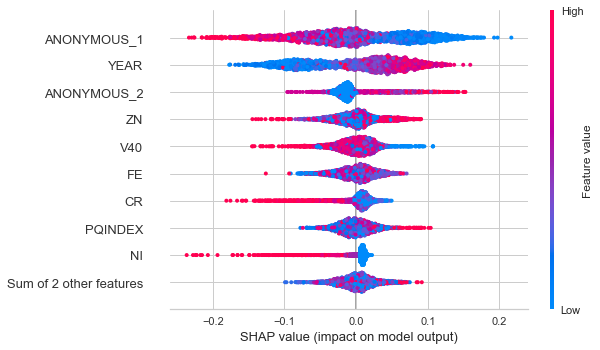

In [207]:
explainer_xgb = shap.Explainer(clf_xgb)
shap_values_xgb = explainer_xgb(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_xgb)

In [208]:
fi_xgb = pd.DataFrame(clf_xgb.feature_importances_, index=X_train3.columns, columns=['feature_importance_xgb']).sort_values('feature_importance_xgb', ascending=False)
fi_xgb

feature_importance_xgb
YEAR                       0.126941
NI                         0.126371
CR                         0.111823
ANONYMOUS_1                0.101523
ANONYMOUS_2                0.089157
V40                        0.078292
FE                         0.075467
ZN                         0.074842
PQINDEX                    0.074119
CU                         0.072493
MO                         0.068972

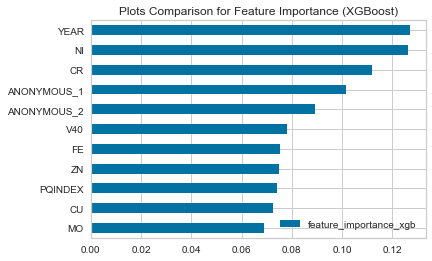

In [209]:
fi_xgb[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (XGBoost)')
plt.show()

### LGBM

In [210]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyLGBM = optuna.create_study(direction='minimize')

# n_trials 지정
studyLGBM.optimize(lambda trial: objectiveLGBM(trial, X_train3, y_train3, X_test, y_test), n_trials=100) 

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-12-08 23:35:53,051] A new study created in memory with name: no-name-274c5f2d-5f76-4916-961e-77749d86f7c9
[I 2022-12-08 23:35:53,110] Trial 0 finished with value: 0.25149647338549375 and parameters: {'n_estimators': 128, 'reg_alpha': 0.0022823817013194955, 'reg_lambda': 0.02464289396907962, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.0006751081218415269, 'num_leaves': 8, 'min_child_samples': 273, 'min_data_per_groups': 42}. Best is trial 0 with value: 0.25149647338549375.
[I 2022-12-08 23:35:53,307] Trial 1 finished with value: 0.25226227160804165 and parameters: {'n_estimators': 423, 'reg_alpha': 9.509196627137978, 'reg_lambda': 0.001075240618218316, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 1.5490339890545457e-08, 'num_leaves': 8, 'min_child_samples': 1, 'min_data_per_groups': 42}. Best is trial 0 with value: 0.25149647338549375.
[I 2022-12-08 23:35:53,438] Trial 2 finished with value: 0.2522623294630456 and parameters: {'n_estimators': 160

[I 2022-12-08 23:35:57,947] Trial 21 finished with value: 0.22882277540183313 and parameters: {'n_estimators': 301, 'reg_alpha': 0.09058144225244552, 'reg_lambda': 0.631978875245298, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.009210467858004839, 'num_leaves': 64, 'min_child_samples': 189, 'min_data_per_groups': 1}. Best is trial 13 with value: 0.225046410289081.
[I 2022-12-08 23:35:58,204] Trial 22 finished with value: 0.2286053410671627 and parameters: {'n_estimators': 336, 'reg_alpha': 0.09463778133448927, 'reg_lambda': 0.9318183337609027, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.008690430416635716, 'num_leaves': 64, 'min_child_samples': 195, 'min_data_per_groups': 26}. Best is trial 13 with value: 0.225046410289081.
[I 2022-12-08 23:35:58,446] Trial 23 finished with value: 0.242049769960707 and parameters: {'n_estimators': 339, 'reg_alpha': 0.08643700449383689, 'reg_lambda': 0.08209279397070632, 'colsample_bytree': 0.7, 'subsample': 0.5, 'lear

[I 2022-12-08 23:36:06,966] Trial 42 finished with value: 0.23048719895901473 and parameters: {'n_estimators': 473, 'reg_alpha': 0.4248453233706592, 'reg_lambda': 1.3472686929740896, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.004043066233541085, 'num_leaves': 64, 'min_child_samples': 143, 'min_data_per_groups': 14}. Best is trial 41 with value: 0.22378875272122117.
[I 2022-12-08 23:36:07,341] Trial 43 finished with value: 0.2255041095640214 and parameters: {'n_estimators': 449, 'reg_alpha': 5.142857471145081, 'reg_lambda': 0.4101844764020154, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.009876904607478166, 'num_leaves': 64, 'min_child_samples': 117, 'min_data_per_groups': 8}. Best is trial 41 with value: 0.22378875272122117.
[I 2022-12-08 23:36:07,638] Trial 44 finished with value: 0.2350190185803351 and parameters: {'n_estimators': 441, 'reg_alpha': 8.872046374164993, 'reg_lambda': 0.7400579640998038, 'colsample_bytree': 0.8, 'subsample': 0.8, 'lear

[I 2022-12-08 23:36:15,017] Trial 63 finished with value: 0.2260510962900364 and parameters: {'n_estimators': 472, 'reg_alpha': 1.1454244947934251, 'reg_lambda': 0.7307008210518284, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.006687140843102452, 'num_leaves': 64, 'min_child_samples': 151, 'min_data_per_groups': 1}. Best is trial 41 with value: 0.22378875272122117.
[I 2022-12-08 23:36:15,466] Trial 64 finished with value: 0.23423930000552873 and parameters: {'n_estimators': 491, 'reg_alpha': 0.6889841885309528, 'reg_lambda': 1.0927309847516458, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.0025539101131688492, 'num_leaves': 128, 'min_child_samples': 136, 'min_data_per_groups': 11}. Best is trial 41 with value: 0.22378875272122117.
[I 2022-12-08 23:36:15,655] Trial 65 finished with value: 0.2348874776608665 and parameters: {'n_estimators': 168, 'reg_alpha': 2.253381862151695, 'reg_lambda': 1.8281882450711766, 'colsample_bytree': 0.8, 'subsample': 1.0, 'l

[I 2022-12-08 23:36:22,835] Trial 84 finished with value: 0.24992466436538907 and parameters: {'n_estimators': 52, 'reg_alpha': 2.538415735968046, 'reg_lambda': 2.2649548397268777, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.002304828485932996, 'num_leaves': 64, 'min_child_samples': 105, 'min_data_per_groups': 12}. Best is trial 41 with value: 0.22378875272122117.
[I 2022-12-08 23:36:23,524] Trial 85 finished with value: 0.22446786218593262 and parameters: {'n_estimators': 473, 'reg_alpha': 0.7949839933718994, 'reg_lambda': 0.4731917443768261, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.007217041145690043, 'num_leaves': 1024, 'min_child_samples': 124, 'min_data_per_groups': 8}. Best is trial 41 with value: 0.22378875272122117.
[I 2022-12-08 23:36:23,661] Trial 86 finished with value: 0.2442840733459723 and parameters: {'n_estimators': 85, 'reg_alpha': 0.9152849294449552, 'reg_lambda': 0.47001954340418034, 'colsample_bytree': 1.0, 'subsample': 0.5, 'l

study.best_params: 0.22118632300617147
Number of finished trials: 100
Best trial: {'n_estimators': 479, 'reg_alpha': 0.5526418743483084, 'reg_lambda': 1.48044145716641, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.006701661435398824, 'num_leaves': 1024, 'min_child_samples': 38, 'min_data_per_groups': 35}
study.best_params: {'n_estimators': 479, 'reg_alpha': 0.5526418743483084, 'reg_lambda': 1.48044145716641, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.006701661435398824, 'num_leaves': 1024, 'min_child_samples': 38, 'min_data_per_groups': 35}


In [211]:
param_lgbm = studyLGBM.best_params

clf_lgbm = lgb.LGBMRegressor(**param_lgbm, max_depth=-1, random_state=42)

In [212]:
clf_lgbm.fit(X_train3, y_train3)

pred_test_lgbm = clf_lgbm.predict(X_test)

y_test['pred_lgbm'] = [labeling(pred, threshold=0.6) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE : 0.2212
F1 Score : 0.228
Macro F1 Score : 0.5736 

[[2345  191]
 [ 222   61]]


In [213]:
optuna.visualization.plot_param_importances(studyLGBM)

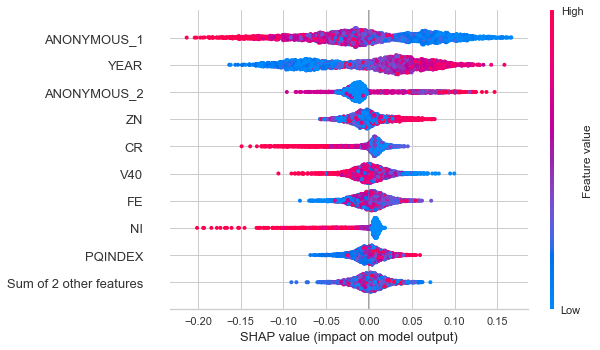

In [214]:
explainer_lgbm = shap.Explainer(clf_lgbm)
shap_values_lgbm = explainer_lgbm(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_lgbm)

In [215]:
fi_lgbm = pd.DataFrame(clf_lgbm.feature_importances_, index=X_train3.columns, columns=['feature_importance_lgbm']).sort_values('feature_importance_lgbm', ascending=False)
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                     4607
ZN                              3524
V40                             3309
FE                              3020
PQINDEX                         2709
YEAR                            2174
CU                              1984
MO                              1502
ANONYMOUS_2                     1340
CR                               922
NI                               447

In [216]:
fi_lgbm['feature_importance_lgbm'] = fi_lgbm['feature_importance_lgbm'] / fi_lgbm['feature_importance_lgbm'].sum()
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                 0.180398
ZN                          0.137990
V40                         0.129572
FE                          0.118255
PQINDEX                     0.106077
YEAR                        0.085128
CU                          0.077688
MO                          0.058814
ANONYMOUS_2                 0.052471
CR                          0.036103
NI                          0.017503

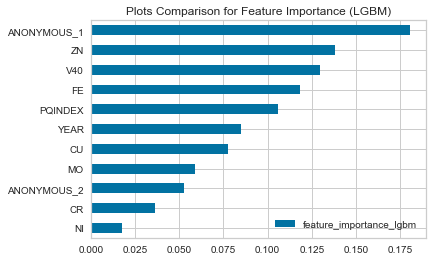

In [217]:
fi_lgbm[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (LGBM)')
plt.show()

### CatBoost

In [218]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyCB = optuna.create_study(direction='minimize')

# n_trials 지정
studyCB.optimize(lambda trial: objectiveCB(trial, X_train3, y_train3, X_test, y_test), n_trials=100) 

print('study.best_params:', studyCB.best_trial.value)
print('Number of finished trials:', len(studyCB.trials))
print('Best trial:', studyCB.best_trial.params)
print('study.best_params:', studyCB.best_params)

[I 2022-12-08 23:41:53,781] A new study created in memory with name: no-name-53aa38c4-fc6f-4efb-89a3-7a3d77042ac2
[I 2022-12-08 23:42:03,355] Trial 0 finished with value: 0.22686288584136544 and parameters: {'l2_leaf_reg': 2.114992719906968, 'max_bin': 215, 'learning_rate': 0.008621919761446063, 'n_estimators': 422, 'max_depth': 10, 'min_data_in_leaf': 218}. Best is trial 0 with value: 0.22686288584136544.
[I 2022-12-08 23:42:35,621] Trial 1 finished with value: 0.22941044599818008 and parameters: {'l2_leaf_reg': 0.409670248246371, 'max_bin': 304, 'learning_rate': 0.009166059269368131, 'n_estimators': 475, 'max_depth': 12, 'min_data_in_leaf': 287}. Best is trial 0 with value: 0.22686288584136544.
[I 2022-12-08 23:42:43,481] Trial 2 finished with value: 0.23044123050863494 and parameters: {'l2_leaf_reg': 0.5179932481626403, 'max_bin': 250, 'learning_rate': 0.011373498000946149, 'n_estimators': 133, 'max_depth': 11, 'min_data_in_leaf': 157}. Best is trial 0 with value: 0.2268628858413654

[I 2022-12-08 23:43:55,653] Trial 27 finished with value: 0.22527681123686544 and parameters: {'l2_leaf_reg': 0.14549981322880887, 'max_bin': 289, 'learning_rate': 0.014119637749684758, 'n_estimators': 286, 'max_depth': 6, 'min_data_in_leaf': 178}. Best is trial 21 with value: 0.22328360764823743.
[I 2022-12-08 23:43:57,941] Trial 28 finished with value: 0.2254763573659213 and parameters: {'l2_leaf_reg': 0.008630751874033228, 'max_bin': 319, 'learning_rate': 0.012245381730591715, 'n_estimators': 439, 'max_depth': 7, 'min_data_in_leaf': 217}. Best is trial 21 with value: 0.22328360764823743.
[I 2022-12-08 23:43:58,881] Trial 29 finished with value: 0.22400862676353672 and parameters: {'l2_leaf_reg': 0.002429552480205491, 'max_bin': 215, 'learning_rate': 0.017158035705079934, 'n_estimators': 409, 'max_depth': 5, 'min_data_in_leaf': 100}. Best is trial 21 with value: 0.22328360764823743.
[I 2022-12-08 23:44:03,549] Trial 30 finished with value: 0.22686535448245448 and parameters: {'l2_lea

[I 2022-12-08 23:44:52,941] Trial 54 finished with value: 0.2249429647242151 and parameters: {'l2_leaf_reg': 0.00593381741727664, 'max_bin': 281, 'learning_rate': 0.014320421063688315, 'n_estimators': 411, 'max_depth': 6, 'min_data_in_leaf': 110}. Best is trial 21 with value: 0.22328360764823743.
[I 2022-12-08 23:44:53,695] Trial 55 finished with value: 0.2247471405237809 and parameters: {'l2_leaf_reg': 0.0921771424209483, 'max_bin': 262, 'learning_rate': 0.017486206155733562, 'n_estimators': 279, 'max_depth': 5, 'min_data_in_leaf': 56}. Best is trial 21 with value: 0.22328360764823743.
[I 2022-12-08 23:44:54,425] Trial 56 finished with value: 0.23143438093134536 and parameters: {'l2_leaf_reg': 0.00394125518068862, 'max_bin': 251, 'learning_rate': 0.01676807850939184, 'n_estimators': 87, 'max_depth': 8, 'min_data_in_leaf': 288}. Best is trial 21 with value: 0.22328360764823743.
[I 2022-12-08 23:45:01,285] Trial 57 finished with value: 0.22421984782023013 and parameters: {'l2_leaf_reg':

[I 2022-12-08 23:45:36,335] Trial 81 finished with value: 0.223546341656642 and parameters: {'l2_leaf_reg': 0.0014693337672224377, 'max_bin': 241, 'learning_rate': 0.017242679973955784, 'n_estimators': 312, 'max_depth': 6, 'min_data_in_leaf': 39}. Best is trial 72 with value: 0.22112866122520114.
[I 2022-12-08 23:45:37,610] Trial 82 finished with value: 0.22406364270953766 and parameters: {'l2_leaf_reg': 0.0044553208708936485, 'max_bin': 219, 'learning_rate': 0.017717109504868992, 'n_estimators': 338, 'max_depth': 6, 'min_data_in_leaf': 7}. Best is trial 72 with value: 0.22112866122520114.
[I 2022-12-08 23:45:38,672] Trial 83 finished with value: 0.22553810220460846 and parameters: {'l2_leaf_reg': 0.19435131100783495, 'max_bin': 255, 'learning_rate': 0.016459863741437163, 'n_estimators': 271, 'max_depth': 6, 'min_data_in_leaf': 51}. Best is trial 72 with value: 0.22112866122520114.
[I 2022-12-08 23:45:39,972] Trial 84 finished with value: 0.2257931987710612 and parameters: {'l2_leaf_re

study.best_params: 0.22112866122520114
Number of finished trials: 100
Best trial: {'l2_leaf_reg': 0.0013865337365716428, 'max_bin': 239, 'learning_rate': 0.017499699761684594, 'n_estimators': 349, 'max_depth': 6, 'min_data_in_leaf': 10}
study.best_params: {'l2_leaf_reg': 0.0013865337365716428, 'max_bin': 239, 'learning_rate': 0.017499699761684594, 'n_estimators': 349, 'max_depth': 6, 'min_data_in_leaf': 10}


In [219]:
param_cat = studyCB.best_params

clf_cat = CatBoostRegressor(**param_cat, random_state=42)

In [220]:
clf_cat.fit(X_train3, y_train3)

pred_test_cat = clf_cat.predict(X_test)

y_test['pred_cat'] = [labeling(pred, threshold=0.6) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

0:	learn: 0.3798636	total: 2.27ms	remaining: 789ms
1:	learn: 0.3792937	total: 4.4ms	remaining: 763ms
2:	learn: 0.3786390	total: 6.42ms	remaining: 741ms
3:	learn: 0.3780630	total: 8.32ms	remaining: 718ms
4:	learn: 0.3775161	total: 10.6ms	remaining: 726ms
5:	learn: 0.3770498	total: 12.5ms	remaining: 714ms
6:	learn: 0.3765570	total: 14.4ms	remaining: 703ms
7:	learn: 0.3760504	total: 16.3ms	remaining: 697ms
8:	learn: 0.3755616	total: 18.6ms	remaining: 701ms
9:	learn: 0.3751069	total: 20.5ms	remaining: 696ms
10:	learn: 0.3746066	total: 22.7ms	remaining: 696ms
11:	learn: 0.3741264	total: 25ms	remaining: 702ms
12:	learn: 0.3736065	total: 27.1ms	remaining: 701ms
13:	learn: 0.3732904	total: 29.1ms	remaining: 697ms
14:	learn: 0.3727808	total: 31.2ms	remaining: 696ms
15:	learn: 0.3722188	total: 33.7ms	remaining: 702ms
16:	learn: 0.3717828	total: 35.8ms	remaining: 700ms
17:	learn: 0.3713670	total: 38ms	remaining: 698ms
18:	learn: 0.3709980	total: 40ms	remaining: 696ms
19:	learn: 0.3706348	total: 4

229:	learn: 0.3396255	total: 513ms	remaining: 265ms
230:	learn: 0.3395388	total: 516ms	remaining: 263ms
231:	learn: 0.3394126	total: 518ms	remaining: 261ms
232:	learn: 0.3392392	total: 520ms	remaining: 259ms
233:	learn: 0.3391284	total: 522ms	remaining: 257ms
234:	learn: 0.3390279	total: 525ms	remaining: 255ms
235:	learn: 0.3389683	total: 527ms	remaining: 252ms
236:	learn: 0.3389148	total: 529ms	remaining: 250ms
237:	learn: 0.3388232	total: 531ms	remaining: 248ms
238:	learn: 0.3387347	total: 533ms	remaining: 246ms
239:	learn: 0.3386760	total: 536ms	remaining: 243ms
240:	learn: 0.3386233	total: 539ms	remaining: 241ms
241:	learn: 0.3385545	total: 541ms	remaining: 239ms
242:	learn: 0.3384206	total: 543ms	remaining: 237ms
243:	learn: 0.3383600	total: 545ms	remaining: 235ms
244:	learn: 0.3382739	total: 548ms	remaining: 232ms
245:	learn: 0.3382036	total: 550ms	remaining: 230ms
246:	learn: 0.3381271	total: 552ms	remaining: 228ms
247:	learn: 0.3380944	total: 554ms	remaining: 226ms
248:	learn: 

In [221]:
optuna.visualization.plot_param_importances(studyCB)

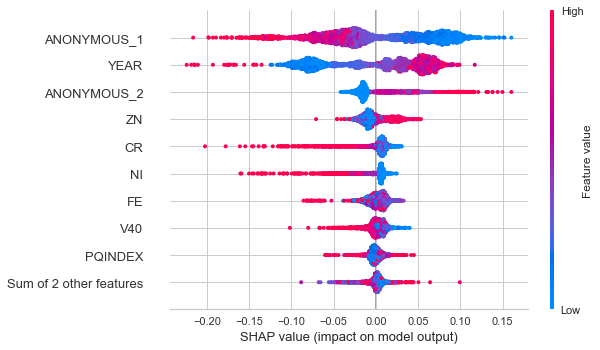

In [222]:
explainer_cat = shap.Explainer(clf_cat)
shap_values_cat = explainer_cat(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_cat)

In [223]:
fi_cat = pd.DataFrame(clf_cat.feature_importances_, index=X_train3.columns, columns=['feature_importance_cat']).sort_values('feature_importance_cat', ascending=False)
fi_cat

feature_importance_cat
YEAR                      21.236224
ANONYMOUS_1               20.785748
ANONYMOUS_2                9.125572
CR                         7.751394
ZN                         7.659401
FE                         7.370092
V40                        6.406419
PQINDEX                    6.266028
NI                         5.411933
CU                         4.065419
MO                         3.921771

In [224]:
fi_cat['feature_importance_cat'] = fi_cat['feature_importance_cat'] / fi_cat['feature_importance_cat'].sum()
fi_cat

feature_importance_cat
YEAR                       0.212362
ANONYMOUS_1                0.207857
ANONYMOUS_2                0.091256
CR                         0.077514
ZN                         0.076594
FE                         0.073701
V40                        0.064064
PQINDEX                    0.062660
NI                         0.054119
CU                         0.040654
MO                         0.039218

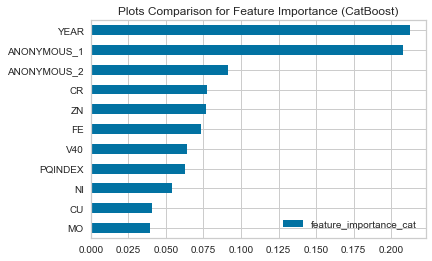

In [225]:
fi_cat[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (CatBoost)')
plt.show()

### Extra Tree

In [226]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyET = optuna.create_study(direction='minimize')

# n_trials 지정
studyET.optimize(lambda trial: objectiveET(trial, X_train3, y_train3, X_test, y_test), n_trials=100) 

print('study.best_params:', studyET.best_trial.value)
print('Number of finished trials:', len(studyET.trials))
print('Best trial:', studyET.best_trial.params)
print('study.best_params:', studyET.best_params)

[I 2022-12-08 23:49:32,237] A new study created in memory with name: no-name-a73efa40-9490-4221-80da-e568b72d0a91
[I 2022-12-08 23:49:34,009] Trial 0 finished with value: 0.22191718386871537 and parameters: {'max_depth': 9, 'max_leaf_nodes': 380, 'n_estimators': 430}. Best is trial 0 with value: 0.22191718386871537.
[I 2022-12-08 23:49:34,429] Trial 1 finished with value: 0.23035227469424957 and parameters: {'max_depth': 5, 'max_leaf_nodes': 741, 'n_estimators': 143}. Best is trial 0 with value: 0.22191718386871537.
[I 2022-12-08 23:49:34,893] Trial 2 finished with value: 0.22182925305303436 and parameters: {'max_depth': 9, 'max_leaf_nodes': 279, 'n_estimators': 92}. Best is trial 2 with value: 0.22182925305303436.
[I 2022-12-08 23:49:37,919] Trial 3 finished with value: 0.22243960639997895 and parameters: {'max_depth': 12, 'max_leaf_nodes': 587, 'n_estimators': 381}. Best is trial 2 with value: 0.22182925305303436.
[I 2022-12-08 23:49:39,951] Trial 4 finished with value: 0.22138368653

[I 2022-12-08 23:50:19,054] Trial 37 finished with value: 0.22145979950399058 and parameters: {'max_depth': 12, 'max_leaf_nodes': 436, 'n_estimators': 131}. Best is trial 27 with value: 0.2208892421530088.
[I 2022-12-08 23:50:20,195] Trial 38 finished with value: 0.22186236190285707 and parameters: {'max_depth': 9, 'max_leaf_nodes': 223, 'n_estimators': 359}. Best is trial 27 with value: 0.2208892421530088.
[I 2022-12-08 23:50:21,341] Trial 39 finished with value: 0.22104106574368676 and parameters: {'max_depth': 13, 'max_leaf_nodes': 332, 'n_estimators': 295}. Best is trial 27 with value: 0.2208892421530088.
[I 2022-12-08 23:50:21,861] Trial 40 finished with value: 0.2305436888415005 and parameters: {'max_depth': 5, 'max_leaf_nodes': 325, 'n_estimators': 297}. Best is trial 27 with value: 0.2208892421530088.
[I 2022-12-08 23:50:22,968] Trial 41 finished with value: 0.22107724436421733 and parameters: {'max_depth': 13, 'max_leaf_nodes': 368, 'n_estimators': 273}. Best is trial 27 with 

[I 2022-12-08 23:51:02,113] Trial 75 finished with value: 0.23883668013683737 and parameters: {'max_depth': 3, 'max_leaf_nodes': 257, 'n_estimators': 244}. Best is trial 42 with value: 0.22084290457412975.
[I 2022-12-08 23:51:03,390] Trial 76 finished with value: 0.22164645069017877 and parameters: {'max_depth': 12, 'max_leaf_nodes': 414, 'n_estimators': 302}. Best is trial 42 with value: 0.22084290457412975.
[I 2022-12-08 23:51:04,839] Trial 77 finished with value: 0.22103028451148413 and parameters: {'max_depth': 13, 'max_leaf_nodes': 369, 'n_estimators': 337}. Best is trial 42 with value: 0.22084290457412975.
[I 2022-12-08 23:51:05,388] Trial 78 finished with value: 0.234285069644257 and parameters: {'max_depth': 4, 'max_leaf_nodes': 377, 'n_estimators': 339}. Best is trial 42 with value: 0.22084290457412975.
[I 2022-12-08 23:51:06,648] Trial 79 finished with value: 0.22124162091409513 and parameters: {'max_depth': 13, 'max_leaf_nodes': 231, 'n_estimators': 360}. Best is trial 42 wi

study.best_params: 0.22075556453245848
Number of finished trials: 100
Best trial: {'max_depth': 12, 'max_leaf_nodes': 330, 'n_estimators': 492}
study.best_params: {'max_depth': 12, 'max_leaf_nodes': 330, 'n_estimators': 492}


In [234]:
param_et = studyET.best_params

clf_et3 = ExtraTreesRegressor(**param_et, random_state=42)

In [235]:
clf_et3.fit(X_train3, y_train3)

pred_test_et = clf_et3.predict(X_test)

y_test['pred_et'] = [labeling(pred, threshold=0.6) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.2208
F1 Score : 0.2363
Macro F1 Score : 0.5817 

[[2386  194]
 [ 181   58]]


In [229]:
optuna.visualization.plot_param_importances(studyET)

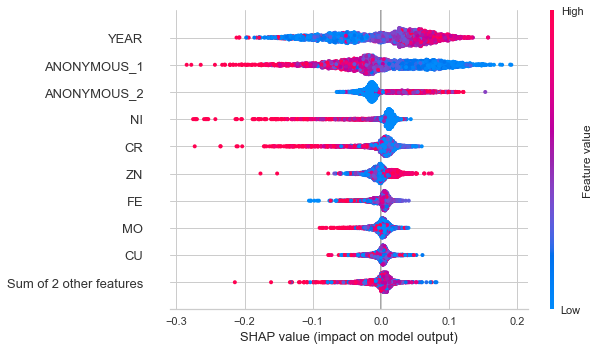

In [230]:
explainer_et = shap.Explainer(clf_et3)
shap_values_et = explainer_et(X_train3)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_et)

In [231]:
fi_et = pd.DataFrame(clf_et3.feature_importances_, index=X_train3.columns, columns=['feature_importance_et']).sort_values('feature_importance_et', ascending=False)
fi_et

feature_importance_et
ANONYMOUS_1               0.183616
YEAR                      0.157964
CR                        0.088120
FE                        0.077157
V40                       0.076083
CU                        0.075515
ZN                        0.074470
PQINDEX                   0.071084
MO                        0.066366
NI                        0.066155
ANONYMOUS_2               0.063470

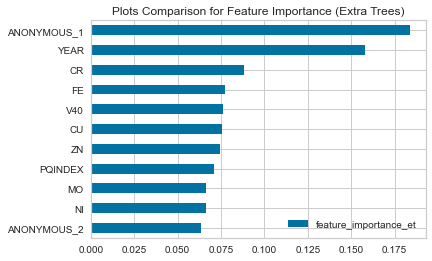

In [232]:
fi_et[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Extra Trees)')
plt.show()

## Dataset 4

### Decision Tree

In [233]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyDT=optuna.create_study(direction='minimize')

# n_trials 지정
studyDT.optimize(lambda trial: objectiveDT(trial, X_train4, y_train4, X_test, y_test), n_trials=100) 

print('study.best_params:', studyDT.best_trial.value)
print('Number of finished trials:', len(studyDT.trials))
print('Best trial:', studyDT.best_trial.params)
print('study.best_params:', studyDT.best_params)

[I 2022-12-08 23:59:14,327] A new study created in memory with name: no-name-33e3ad10-2903-4c64-8be1-6069a2d83a37
[I 2022-12-08 23:59:14,346] Trial 0 finished with value: 0.22358568840993062 and parameters: {'max_depth': 8, 'max_leaf_nodes': 565}. Best is trial 0 with value: 0.22358568840993062.
[I 2022-12-08 23:59:14,356] Trial 1 finished with value: 0.22520066746947248 and parameters: {'max_depth': 4, 'max_leaf_nodes': 290}. Best is trial 0 with value: 0.22358568840993062.
[I 2022-12-08 23:59:14,376] Trial 2 finished with value: 0.2333028928062698 and parameters: {'max_depth': 13, 'max_leaf_nodes': 417}. Best is trial 0 with value: 0.22358568840993062.
[I 2022-12-08 23:59:14,388] Trial 3 finished with value: 0.22597570302642972 and parameters: {'max_depth': 5, 'max_leaf_nodes': 348}. Best is trial 0 with value: 0.22358568840993062.
[I 2022-12-08 23:59:14,403] Trial 4 finished with value: 0.22503721986288266 and parameters: {'max_depth': 7, 'max_leaf_nodes': 888}. Best is trial 0 with

[I 2022-12-08 23:59:15,471] Trial 41 finished with value: 0.23138701130652728 and parameters: {'max_depth': 12, 'max_leaf_nodes': 303}. Best is trial 17 with value: 0.21954879976014796.
[I 2022-12-08 23:59:15,501] Trial 42 finished with value: 0.21974730785676272 and parameters: {'max_depth': 11, 'max_leaf_nodes': 94}. Best is trial 17 with value: 0.21954879976014796.
[I 2022-12-08 23:59:15,533] Trial 43 finished with value: 0.2222716092426385 and parameters: {'max_depth': 11, 'max_leaf_nodes': 139}. Best is trial 17 with value: 0.21954879976014796.
[I 2022-12-08 23:59:15,555] Trial 44 finished with value: 0.22978464003876647 and parameters: {'max_depth': 10, 'max_leaf_nodes': 6}. Best is trial 17 with value: 0.21954879976014796.
[I 2022-12-08 23:59:15,602] Trial 45 finished with value: 0.21906077738015622 and parameters: {'max_depth': 11, 'max_leaf_nodes': 108}. Best is trial 45 with value: 0.21906077738015622.
[I 2022-12-08 23:59:15,643] Trial 46 finished with value: 0.22187077147517

[I 2022-12-08 23:59:16,920] Trial 83 finished with value: 0.22175745695486568 and parameters: {'max_depth': 9, 'max_leaf_nodes': 188}. Best is trial 54 with value: 0.21846297644923318.
[I 2022-12-08 23:59:16,960] Trial 84 finished with value: 0.22469211405115047 and parameters: {'max_depth': 12, 'max_leaf_nodes': 161}. Best is trial 54 with value: 0.21846297644923318.
[I 2022-12-08 23:59:17,000] Trial 85 finished with value: 0.22277817829910618 and parameters: {'max_depth': 11, 'max_leaf_nodes': 123}. Best is trial 54 with value: 0.21846297644923318.
[I 2022-12-08 23:59:17,037] Trial 86 finished with value: 0.22062788576291512 and parameters: {'max_depth': 11, 'max_leaf_nodes': 56}. Best is trial 54 with value: 0.21846297644923318.
[I 2022-12-08 23:59:17,065] Trial 87 finished with value: 0.22225049596667668 and parameters: {'max_depth': 12, 'max_leaf_nodes': 22}. Best is trial 54 with value: 0.21846297644923318.
[I 2022-12-08 23:59:17,101] Trial 88 finished with value: 0.2267398290653

study.best_params: 0.21846297644923318
Number of finished trials: 100
Best trial: {'max_depth': 11, 'max_leaf_nodes': 101}
study.best_params: {'max_depth': 11, 'max_leaf_nodes': 101}


In [236]:
param_dt = studyDT.best_params

clf_dt = DecisionTreeRegressor(**param_dt, random_state=42)

In [237]:
clf_dt.fit(X_train4, y_train4)

pred_test_dt = clf_dt.predict(X_test)

y_test['pred_dt'] = [labeling(pred, threshold=0.6) for pred in pred_test_dt]

print('MAE :', round(mean_absolute_error(pred_test_dt, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_dt, y_test.Y_LABEL))

MAE : 0.2185
F1 Score : 0.1767
Macro F1 Score : 0.5455 

[[2334  205]
 [ 233   47]]


In [238]:
optuna.visualization.plot_param_importances(studyDT)

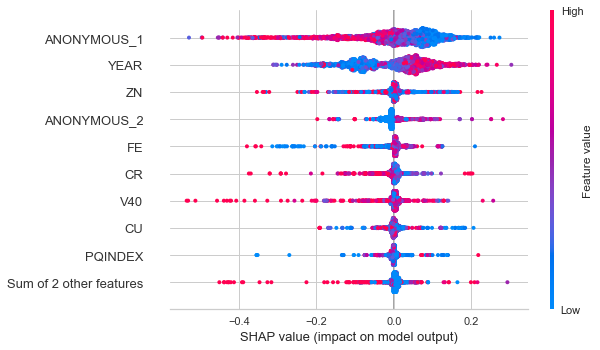

In [239]:
explainer_dt = shap.Explainer(clf_dt)
shap_values_dt = explainer_dt(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_dt)

In [240]:
fi_dt = pd.DataFrame(clf_dt.feature_importances_, index=X_train4.columns, columns=['feature_importance_dt']).sort_values('feature_importance_dt', ascending=False)
fi_dt

feature_importance_dt
ANONYMOUS_1               0.318245
YEAR                      0.156466
ZN                        0.110032
V40                       0.107303
FE                        0.072838
ANONYMOUS_2               0.043302
CU                        0.041726
CR                        0.039864
PQINDEX                   0.038968
MO                        0.037295
NI                        0.033961

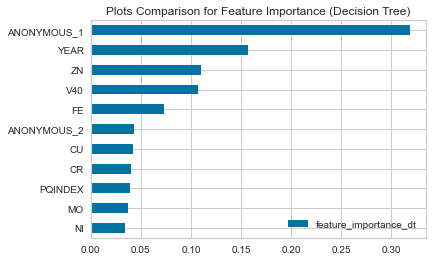

In [241]:
fi_dt[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Decision Tree)')
plt.show()

### SVR

In [242]:
# MAE가 최소가 되는 방향으로 학습을 진행
studySVR=optuna.create_study(direction='minimize')

# n_trials 지정
studySVR.optimize(lambda trial: objectiveSVR(trial, X_train4, y_train4, X_test, y_test), n_trials=100) 

print('study.best_params:', studySVR.best_trial.value)
print('Number of finished trials:', len(studySVR.trials))
print('Best trial:', studySVR.best_trial.params)
print('study.best_params:', studySVR.best_params)

[I 2022-12-09 00:01:35,060] A new study created in memory with name: no-name-cd06e5aa-2526-4bea-a6f4-a98614f7e444
[I 2022-12-09 00:01:36,185] Trial 0 finished with value: 0.43513698988262556 and parameters: {'C': 6.551372942773126, 'degree': 5, 'gamma': 0.008599743616139488, 'epsilon': 0.46387725404636976}. Best is trial 0 with value: 0.43513698988262556.
[I 2022-12-09 00:01:37,494] Trial 1 finished with value: 0.38361310613401567 and parameters: {'C': 9.642053973785606, 'degree': 2, 'gamma': 0.004756170341032792, 'epsilon': 0.4079992338602844}. Best is trial 1 with value: 0.38361310613401567.
[I 2022-12-09 00:01:38,965] Trial 2 finished with value: 0.12880724255561318 and parameters: {'C': 1.1483251264651315, 'degree': 5, 'gamma': 0.002785041147424097, 'epsilon': 0.05053170327863826}. Best is trial 2 with value: 0.12880724255561318.
[I 2022-12-09 00:01:40,237] Trial 3 finished with value: 0.23351538415954637 and parameters: {'C': 1.4293357935520734, 'degree': 4, 'gamma': 0.00142787412

[I 2022-12-09 00:02:15,513] Trial 32 finished with value: 0.13345401296426318 and parameters: {'C': 0.4277813478410383, 'degree': 5, 'gamma': 0.002491448794608288, 'epsilon': 0.07837814422555162}. Best is trial 24 with value: 0.10995310028289317.
[I 2022-12-09 00:02:16,801] Trial 33 finished with value: 0.11428562544080913 and parameters: {'C': 0.3786591776633346, 'degree': 5, 'gamma': 0.002085063834521148, 'epsilon': 0.055190594398963434}. Best is trial 24 with value: 0.10995310028289317.
[I 2022-12-09 00:02:17,894] Trial 34 finished with value: 0.11050654418914559 and parameters: {'C': 0.40426529072617373, 'degree': 6, 'gamma': 0.0013297111916397728, 'epsilon': 0.05346026332932968}. Best is trial 24 with value: 0.10995310028289317.
[I 2022-12-09 00:02:19,045] Trial 35 finished with value: 0.15299561461527617 and parameters: {'C': 0.6631960975570125, 'degree': 6, 'gamma': 0.001281636755505759, 'epsilon': 0.10847723497314596}. Best is trial 24 with value: 0.10995310028289317.
[I 2022-1

[I 2022-12-09 00:03:02,144] Trial 64 finished with value: 0.13498441346476564 and parameters: {'C': 0.5162922606876881, 'degree': 7, 'gamma': 0.001038595763591653, 'epsilon': 0.08701337825919102}. Best is trial 63 with value: 0.10880190223654532.
[I 2022-12-09 00:03:03,508] Trial 65 finished with value: 0.14624762943363498 and parameters: {'C': 0.5863478826530688, 'degree': 3, 'gamma': 0.0011525775183026245, 'epsilon': 0.10060931058789405}. Best is trial 63 with value: 0.10880190223654532.
[I 2022-12-09 00:03:04,901] Trial 66 finished with value: 0.12181308672646207 and parameters: {'C': 0.457120808952132, 'degree': 5, 'gamma': 0.0014742799885199243, 'epsilon': 0.06757512015681601}. Best is trial 63 with value: 0.10880190223654532.
[I 2022-12-09 00:03:06,308] Trial 67 finished with value: 0.15790911770238822 and parameters: {'C': 0.3051682892570894, 'degree': 5, 'gamma': 0.001099567378338625, 'epsilon': 0.11869281055288311}. Best is trial 63 with value: 0.10880190223654532.
[I 2022-12-

[I 2022-12-09 00:03:40,506] Trial 96 finished with value: 0.12620867610034694 and parameters: {'C': 0.3564212783395839, 'degree': 5, 'gamma': 0.0011597591925269876, 'epsilon': 0.07635582533149259}. Best is trial 63 with value: 0.10880190223654532.
[I 2022-12-09 00:03:41,497] Trial 97 finished with value: 0.14493522336769735 and parameters: {'C': 0.41415757120983837, 'degree': 4, 'gamma': 0.0017669094779782317, 'epsilon': 0.09805474490470867}. Best is trial 63 with value: 0.10880190223654532.
[I 2022-12-09 00:03:42,448] Trial 98 finished with value: 0.25836945153058594 and parameters: {'C': 0.5721829506338858, 'degree': 6, 'gamma': 0.001399597311455401, 'epsilon': 0.24109669205265583}. Best is trial 63 with value: 0.10880190223654532.
[I 2022-12-09 00:03:43,694] Trial 99 finished with value: 0.12431208066423353 and parameters: {'C': 0.6455792610544954, 'degree': 5, 'gamma': 0.003431622659643675, 'epsilon': 0.050034618194702625}. Best is trial 63 with value: 0.10880190223654532.


study.best_params: 0.10880190223654532
Number of finished trials: 100
Best trial: {'C': 0.5081923033429661, 'degree': 6, 'gamma': 0.001122559637854534, 'epsilon': 0.05065710744065541}
study.best_params: {'C': 0.5081923033429661, 'degree': 6, 'gamma': 0.001122559637854534, 'epsilon': 0.05065710744065541}


In [243]:
param_svr = studySVR.best_params

clf_svr = SVR(**param_svr)

In [244]:
clf_svr.fit(X_train4, y_train4)

pred_test_svr = clf_svr.predict(X_test)

y_test['pred_svr'] = [labeling(pred, threshold=0.6) for pred in pred_test_svr]

print('MAE :', round(mean_absolute_error(pred_test_svr, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_svr, y_test.Y_LABEL))

MAE : 0.1088
F1 Score : 0.0077
Macro F1 Score : 0.48 

[[2561  251]
 [   6    1]]


In [245]:
optuna.visualization.plot_param_importances(studySVR)

### Random Forest Regressor

In [246]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyRF=optuna.create_study(direction='minimize')

# n_trials 지정
studyRF.optimize(lambda trial: objectiveRF(trial, X_train4, y_train4, X_test, y_test), n_trials=100) 

print('study.best_params:', studyRF.best_trial.value)
print('Number of finished trials:', len(studyRF.trials))
print('Best trial:', studyRF.best_trial.params)
print('study.best_params:', studyRF.best_params)

[I 2022-12-09 00:06:08,268] A new study created in memory with name: no-name-4f171660-927a-477c-9df9-931b3f08e99f
[I 2022-12-09 00:06:09,093] Trial 0 finished with value: 0.21934100569765866 and parameters: {'max_depth': 6, 'max_leaf_nodes': 316, 'n_estimators': 86}. Best is trial 0 with value: 0.21934100569765866.
[I 2022-12-09 00:06:15,188] Trial 1 finished with value: 0.22057240617742047 and parameters: {'max_depth': 11, 'max_leaf_nodes': 247, 'n_estimators': 428}. Best is trial 0 with value: 0.21934100569765866.
[I 2022-12-09 00:06:18,581] Trial 2 finished with value: 0.21859095359366662 and parameters: {'max_depth': 8, 'max_leaf_nodes': 80, 'n_estimators': 312}. Best is trial 2 with value: 0.21859095359366662.
[I 2022-12-09 00:06:18,948] Trial 3 finished with value: 0.22262038387638103 and parameters: {'max_depth': 4, 'max_leaf_nodes': 483, 'n_estimators': 58}. Best is trial 2 with value: 0.21859095359366662.
[I 2022-12-09 00:06:19,650] Trial 4 finished with value: 0.2273576481147

[I 2022-12-09 00:07:29,498] Trial 37 finished with value: 0.21727568662065902 and parameters: {'max_depth': 11, 'max_leaf_nodes': 69, 'n_estimators': 238}. Best is trial 34 with value: 0.2171386833406053.
[I 2022-12-09 00:07:31,521] Trial 38 finished with value: 0.21801168927346312 and parameters: {'max_depth': 11, 'max_leaf_nodes': 58, 'n_estimators': 277}. Best is trial 34 with value: 0.2171386833406053.
[I 2022-12-09 00:07:34,230] Trial 39 finished with value: 0.22380716939050393 and parameters: {'max_depth': 13, 'max_leaf_nodes': 444, 'n_estimators': 238}. Best is trial 34 with value: 0.2171386833406053.
[I 2022-12-09 00:07:37,284] Trial 40 finished with value: 0.22163906846606407 and parameters: {'max_depth': 12, 'max_leaf_nodes': 284, 'n_estimators': 289}. Best is trial 34 with value: 0.2171386833406053.
[I 2022-12-09 00:07:39,291] Trial 41 finished with value: 0.21818723965075143 and parameters: {'max_depth': 11, 'max_leaf_nodes': 179, 'n_estimators': 207}. Best is trial 34 with

[I 2022-12-09 00:08:49,948] Trial 75 finished with value: 0.21701680908809803 and parameters: {'max_depth': 12, 'max_leaf_nodes': 160, 'n_estimators': 176}. Best is trial 65 with value: 0.21678854251376156.
[I 2022-12-09 00:08:51,869] Trial 76 finished with value: 0.21696726708728792 and parameters: {'max_depth': 13, 'max_leaf_nodes': 173, 'n_estimators': 177}. Best is trial 65 with value: 0.21678854251376156.
[I 2022-12-09 00:08:53,044] Trial 77 finished with value: 0.21727853830563862 and parameters: {'max_depth': 13, 'max_leaf_nodes': 193, 'n_estimators': 108}. Best is trial 65 with value: 0.21678854251376156.
[I 2022-12-09 00:08:54,331] Trial 78 finished with value: 0.22074068735333185 and parameters: {'max_depth': 13, 'max_leaf_nodes': 26, 'n_estimators': 189}. Best is trial 65 with value: 0.21678854251376156.
[I 2022-12-09 00:08:56,048] Trial 79 finished with value: 0.220626817440606 and parameters: {'max_depth': 13, 'max_leaf_nodes': 261, 'n_estimators': 146}. Best is trial 65 w

study.best_params: 0.21621868436456784
Number of finished trials: 100
Best trial: {'max_depth': 13, 'max_leaf_nodes': 88, 'n_estimators': 65}
study.best_params: {'max_depth': 13, 'max_leaf_nodes': 88, 'n_estimators': 65}


In [247]:
param_rf = studyRF.best_params

clf_rf = RandomForestRegressor(**param_rf, random_state=42)

In [248]:
clf_rf.fit(X_train4, y_train4)

pred_test_rf = clf_rf.predict(X_test)

y_test['pred_rf'] = [labeling(pred, threshold=0.6) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.2162
F1 Score : 0.2272
Macro F1 Score : 0.5766 

[[2382  196]
 [ 185   56]]


In [249]:
optuna.visualization.plot_param_importances(studyRF)

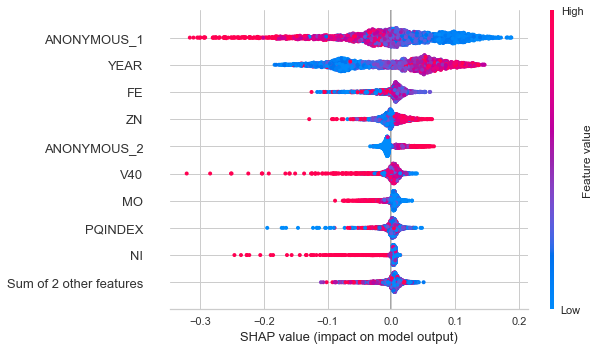

In [250]:
explainer_rf = shap.Explainer(clf_rf)
shap_values_rf = explainer_rf(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_rf)

In [251]:
fi_rf = pd.DataFrame(clf_rf.feature_importances_, index=X_train4.columns, columns=['feature_importance_rf']).sort_values('feature_importance_rf', ascending=False)
fi_rf

feature_importance_rf
ANONYMOUS_1               0.242317
YEAR                      0.131787
V40                       0.110038
ZN                        0.105654
FE                        0.098167
PQINDEX                   0.085000
CU                        0.066421
MO                        0.048319
CR                        0.043769
NI                        0.035147
ANONYMOUS_2               0.033382

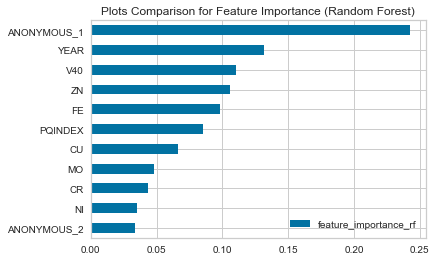

In [252]:
fi_rf[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Random Forest)')
plt.show()

### XGBRegressor

In [253]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X_train4, y_train4, X_test, y_test), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)

[I 2022-12-09 00:11:02,473] A new study created in memory with name: no-name-7321a1e5-a902-4e0f-af86-609d5ad09949
[I 2022-12-09 00:11:03,035] Trial 0 finished with value: 0.4369755527141628 and parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.0004825340216865786, 'n_estimators': 238, 'subsample': 0.8494755185736528, 'min_child_weight': 54, 'alpha': 0.026721519771684937}. Best is trial 0 with value: 0.4369755527141628.
[I 2022-12-09 00:11:03,529] Trial 1 finished with value: 0.4629924790411648 and parameters: {'objective': 'reg:squarederror', 'max_depth': 5, 'learning_rate': 4.409668039399788e-07, 'n_estimators': 179, 'subsample': 0.7591381572932755, 'min_child_weight': 3, 'alpha': 0.0031068288038717906}. Best is trial 0 with value: 0.4369755527141628.
[I 2022-12-09 00:11:04,364] Trial 2 finished with value: 0.4629805168921831 and parameters: {'objective': 'reg:squarederror', 'max_depth': 5, 'learning_rate': 3.340616877835435e-07, 'n_estimators': 373, 'su

[I 2022-12-09 00:11:16,555] Trial 23 finished with value: 0.2860078775476589 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.008394938370321906, 'n_estimators': 193, 'subsample': 0.8196494882531798, 'min_child_weight': 298, 'alpha': 9.95743210158417}. Best is trial 3 with value: 0.28280517008378175.
[I 2022-12-09 00:11:17,020] Trial 24 finished with value: 0.42016582481212417 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.0010960074676114738, 'n_estimators': 198, 'subsample': 0.828212406983006, 'min_child_weight': 298, 'alpha': 9.846500001431199}. Best is trial 3 with value: 0.28280517008378175.
[I 2022-12-09 00:11:17,657] Trial 25 finished with value: 0.4543414967644845 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.0001513635501231877, 'n_estimators': 253, 'subsample': 0.869397162873451, 'min_child_weight': 173, 'alpha': 2.9877059761931863}. Best is trial 3 with value: 

[I 2022-12-09 00:11:50,532] Trial 47 finished with value: 0.22128386906420522 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.009822176959277904, 'n_estimators': 490, 'subsample': 0.9475443398222352, 'min_child_weight': 35, 'alpha': 0.014289871943013023}. Best is trial 47 with value: 0.22128386906420522.
[I 2022-12-09 00:11:52,550] Trial 48 finished with value: 0.38613349955306064 and parameters: {'objective': 'reg:squarederror', 'max_depth': 6, 'learning_rate': 0.0007827055178583935, 'n_estimators': 490, 'subsample': 0.9373122347586536, 'min_child_weight': 36, 'alpha': 0.013465838941074395}. Best is trial 47 with value: 0.22128386906420522.
[I 2022-12-09 00:11:54,227] Trial 49 finished with value: 0.22173472070203432 and parameters: {'objective': 'reg:squarederror', 'max_depth': 5, 'learning_rate': 0.009295737906856774, 'n_estimators': 462, 'subsample': 0.951726007144512, 'min_child_weight': 1, 'alpha': 0.11425470726025298}. Best is trial 47 with v

[I 2022-12-09 00:12:51,606] Trial 71 finished with value: 0.22163774607510545 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.009492218592712626, 'n_estimators': 479, 'subsample': 0.9581137427110414, 'min_child_weight': 45, 'alpha': 0.011460174732603894}. Best is trial 47 with value: 0.22128386906420522.
[I 2022-12-09 00:12:54,692] Trial 72 finished with value: 0.29512319874956316 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.002455361262605571, 'n_estimators': 484, 'subsample': 0.9278579474418815, 'min_child_weight': 44, 'alpha': 0.02201619014737998}. Best is trial 47 with value: 0.22128386906420522.
[I 2022-12-09 00:12:57,450] Trial 73 finished with value: 0.22029187620763196 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.009651587444193206, 'n_estimators': 471, 'subsample': 0.9382193742332482, 'min_child_weight': 13, 'alpha': 0.137775651295835}. Best is trial 73 with val

[I 2022-12-09 00:13:42,506] Trial 95 finished with value: 0.22017538059866568 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.009719789194850451, 'n_estimators': 475, 'subsample': 0.9353298472323495, 'min_child_weight': 18, 'alpha': 0.1259090127952357}. Best is trial 95 with value: 0.22017538059866568.
[I 2022-12-09 00:13:44,340] Trial 96 finished with value: 0.27402235915705686 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.003429227082857427, 'n_estimators': 436, 'subsample': 0.9222770548079884, 'min_child_weight': 5, 'alpha': 0.1544133689958872}. Best is trial 95 with value: 0.22017538059866568.
[I 2022-12-09 00:13:45,330] Trial 97 finished with value: 0.22430335102999785 and parameters: {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.00980518186200288, 'n_estimators': 474, 'subsample': 0.9348349758954109, 'min_child_weight': 17, 'alpha': 0.12784143759396435}. Best is trial 95 with value:

study.best_params: 0.22017538059866568
Number of finished trials: 100
Best trial: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.009719789194850451, 'n_estimators': 475, 'subsample': 0.9353298472323495, 'min_child_weight': 18, 'alpha': 0.1259090127952357}
study.best_params: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.009719789194850451, 'n_estimators': 475, 'subsample': 0.9353298472323495, 'min_child_weight': 18, 'alpha': 0.1259090127952357}


In [254]:
param_xgb = studyXGB.best_params

clf_xgb = xgb.XGBRegressor(**param_xgb, random_state=42)

In [255]:
clf_xgb.fit(X_train4, y_train4)

pred_test_xgb = clf_xgb.predict(X_test)

y_test['pred_xgb'] = [labeling(pred, threshold=0.6) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.2201
F1 Score : 0.2372
Macro F1 Score : 0.5776 

[[2336  187]
 [ 231   65]]


In [256]:
optuna.visualization.plot_param_importances(studyXGB)

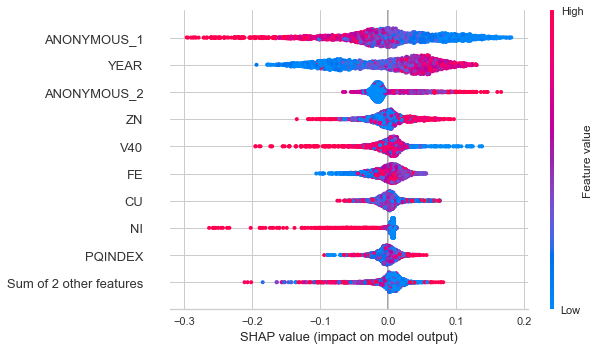

In [257]:
explainer_xgb = shap.Explainer(clf_xgb)
shap_values_xgb = explainer_xgb(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_xgb)

In [258]:
fi_xgb = pd.DataFrame(clf_xgb.feature_importances_, index=X_train4.columns, columns=['feature_importance_xgb']).sort_values('feature_importance_xgb', ascending=False)
fi_xgb

feature_importance_xgb
NI                         0.156613
YEAR                       0.134219
ANONYMOUS_1                0.108378
ANONYMOUS_2                0.082391
CR                         0.078478
V40                        0.077443
CU                         0.077133
FE                         0.073805
ZN                         0.072135
PQINDEX                    0.070812
MO                         0.068595

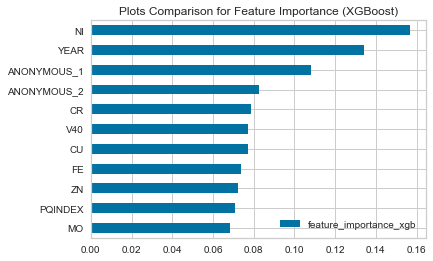

In [259]:
fi_xgb[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (XGBoost)')
plt.show()

### LGBM

In [260]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyLGBM = optuna.create_study(direction='minimize')

# n_trials 지정
studyLGBM.optimize(lambda trial: objectiveLGBM(trial, X_train4, y_train4, X_test, y_test), n_trials=100) 

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-12-09 00:16:27,177] A new study created in memory with name: no-name-089e0046-2b29-4922-9ff3-2eeafc56459d
[I 2022-12-09 00:16:27,278] Trial 0 finished with value: 0.2503859728120164 and parameters: {'n_estimators': 96, 'reg_alpha': 0.26558742274344, 'reg_lambda': 0.004045365943397462, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 7.098322737060927e-06, 'num_leaves': 64, 'min_child_samples': 75, 'min_data_per_groups': 29}. Best is trial 0 with value: 0.2503859728120164.
[I 2022-12-09 00:16:27,583] Trial 1 finished with value: 0.2342739476995675 and parameters: {'n_estimators': 491, 'reg_alpha': 0.04356668142449473, 'reg_lambda': 0.8876427284815951, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.0030690856486131376, 'num_leaves': 64, 'min_child_samples': 210, 'min_data_per_groups': 70}. Best is trial 1 with value: 0.2342739476995675.
[I 2022-12-09 00:16:27,900] Trial 2 finished with value: 0.2503712302812026 and parameters: {'n_estimators': 335, 'reg_

[I 2022-12-09 00:16:35,616] Trial 21 finished with value: 0.23579056391005973 and parameters: {'n_estimators': 158, 'reg_alpha': 2.0448542556661367, 'reg_lambda': 0.010228619186460786, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.00746895619851631, 'num_leaves': 128, 'min_child_samples': 267, 'min_data_per_groups': 51}. Best is trial 11 with value: 0.23013161127441392.
[I 2022-12-09 00:16:35,793] Trial 22 finished with value: 0.24610734833089024 and parameters: {'n_estimators': 201, 'reg_alpha': 5.011474619954819, 'reg_lambda': 0.017422905546106114, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.0013463116556302875, 'num_leaves': 128, 'min_child_samples': 245, 'min_data_per_groups': 59}. Best is trial 11 with value: 0.23013161127441392.
[I 2022-12-09 00:16:35,885] Trial 23 finished with value: 0.24814837628712968 and parameters: {'n_estimators': 74, 'reg_alpha': 1.444275187449557, 'reg_lambda': 0.046356475407321136, 'colsample_bytree': 1.0, 'subsample': 

[I 2022-12-09 00:16:40,682] Trial 42 finished with value: 0.2261012768405839 and parameters: {'n_estimators': 363, 'reg_alpha': 0.0011598386162670542, 'reg_lambda': 0.9667636838181155, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.009287540582587791, 'num_leaves': 8, 'min_child_samples': 164, 'min_data_per_groups': 93}. Best is trial 42 with value: 0.2261012768405839.
[I 2022-12-09 00:16:40,942] Trial 43 finished with value: 0.240215549489898 and parameters: {'n_estimators': 353, 'reg_alpha': 0.005375312868414121, 'reg_lambda': 0.7330872010110042, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.0022028425025241815, 'num_leaves': 8, 'min_child_samples': 155, 'min_data_per_groups': 94}. Best is trial 42 with value: 0.2261012768405839.
[I 2022-12-09 00:16:41,204] Trial 44 finished with value: 0.23353197089267766 and parameters: {'n_estimators': 315, 'reg_alpha': 0.0012572019206350312, 'reg_lambda': 1.7756335658634306, 'colsample_bytree': 0.6, 'subsample': 0.6

[I 2022-12-09 00:16:46,464] Trial 63 finished with value: 0.2255706307349321 and parameters: {'n_estimators': 451, 'reg_alpha': 0.001493961345087929, 'reg_lambda': 1.9793405366726715, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.008874945597582905, 'num_leaves': 128, 'min_child_samples': 257, 'min_data_per_groups': 91}. Best is trial 63 with value: 0.2255706307349321.
[I 2022-12-09 00:16:46,773] Trial 64 finished with value: 0.2386551384984268 and parameters: {'n_estimators': 455, 'reg_alpha': 0.0013836723464741474, 'reg_lambda': 7.941598935227607, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.0018620323660532288, 'num_leaves': 128, 'min_child_samples': 261, 'min_data_per_groups': 90}. Best is trial 63 with value: 0.2255706307349321.
[I 2022-12-09 00:16:47,199] Trial 65 finished with value: 0.23034527323560336 and parameters: {'n_estimators': 440, 'reg_alpha': 0.0022151172041936767, 'reg_lambda': 1.9947519750467508, 'colsample_bytree': 0.9, 'subsample':

[I 2022-12-09 00:16:54,470] Trial 84 finished with value: 0.2367190898565812 and parameters: {'n_estimators': 432, 'reg_alpha': 0.004315919939647408, 'reg_lambda': 0.3732908438281292, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.0023714527869166916, 'num_leaves': 128, 'min_child_samples': 264, 'min_data_per_groups': 65}. Best is trial 66 with value: 0.22486976084003435.
[I 2022-12-09 00:16:54,790] Trial 85 finished with value: 0.2503862919422805 and parameters: {'n_estimators': 468, 'reg_alpha': 0.003115581398207814, 'reg_lambda': 1.0312506208786958, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 1.5934971654022261e-06, 'num_leaves': 512, 'min_child_samples': 238, 'min_data_per_groups': 59}. Best is trial 66 with value: 0.22486976084003435.
[I 2022-12-09 00:16:55,113] Trial 86 finished with value: 0.22535562247782068 and parameters: {'n_estimators': 402, 'reg_alpha': 0.0010303420433982928, 'reg_lambda': 0.6304168440088991, 'colsample_bytree': 0.9, 'subsamp

study.best_params: 0.22439340694121182
Number of finished trials: 100
Best trial: {'n_estimators': 474, 'reg_alpha': 0.005122788547873399, 'reg_lambda': 1.4313755997145676, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.009703939496972179, 'num_leaves': 1024, 'min_child_samples': 266, 'min_data_per_groups': 96}
study.best_params: {'n_estimators': 474, 'reg_alpha': 0.005122788547873399, 'reg_lambda': 1.4313755997145676, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.009703939496972179, 'num_leaves': 1024, 'min_child_samples': 266, 'min_data_per_groups': 96}


In [261]:
param_lgbm = studyLGBM.best_params

clf_lgbm = lgb.LGBMRegressor(**param_lgbm, max_depth=-1, random_state=42)

In [262]:
clf_lgbm.fit(X_train4, y_train4)

pred_test_lgbm = clf_lgbm.predict(X_test)

y_test['pred_lgbm'] = [labeling(pred, threshold=0.6) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE : 0.2244
F1 Score : 0.1968
Macro F1 Score : 0.5647 

[[2425  209]
 [ 142   43]]


In [263]:
optuna.visualization.plot_param_importances(studyLGBM)

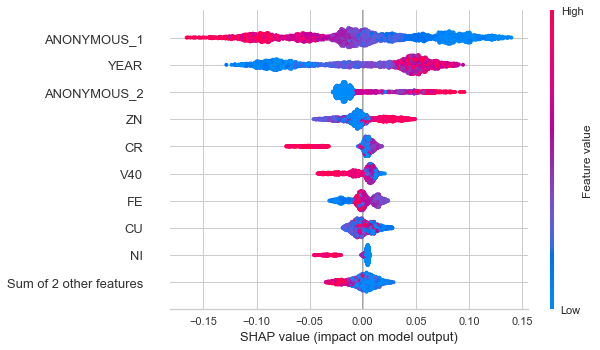

In [264]:
explainer_lgbm = shap.Explainer(clf_lgbm)
shap_values_lgbm = explainer_lgbm(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_lgbm)

In [265]:
fi_lgbm = pd.DataFrame(clf_lgbm.feature_importances_, index=X_train4.columns, columns=['feature_importance_lgbm']).sort_values('feature_importance_lgbm', ascending=False)
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                      775
YEAR                             488
ZN                               363
ANONYMOUS_2                      351
CU                               284
V40                              255
FE                               246
PQINDEX                          226
CR                               190
MO                               185
NI                                71

In [266]:
fi_lgbm['feature_importance_lgbm'] = fi_lgbm['feature_importance_lgbm'] / fi_lgbm['feature_importance_lgbm'].sum()
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                 0.225684
YEAR                        0.142108
ZN                          0.105708
ANONYMOUS_2                 0.102213
CU                          0.082702
V40                         0.074257
FE                          0.071637
PQINDEX                     0.065812
CR                          0.055329
MO                          0.053873
NI                          0.020676

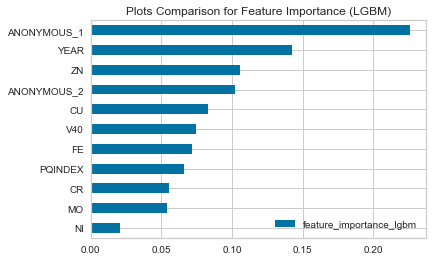

In [267]:
fi_lgbm[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (LGBM)')
plt.show()

### CatBoost

In [336]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyCB = optuna.create_study(direction='minimize')

# n_trials 지정
studyCB.optimize(lambda trial: objectiveCB(trial, X_train4, y_train4, X_test, y_test), n_trials=100) 

print('study.best_params:', studyCB.best_trial.value)
print('Number of finished trials:', len(studyCB.trials))
print('Best trial:', studyCB.best_trial.params)
print('study.best_params:', studyCB.best_params)

[I 2022-12-09 01:12:55,374] A new study created in memory with name: no-name-a6e5d937-c10f-4941-a515-93fa34cf9a96
[I 2022-12-09 01:14:01,401] Trial 0 finished with value: 0.2267478627964489 and parameters: {'l2_leaf_reg': 0.07198784093321561, 'max_bin': 393, 'learning_rate': 0.0064662447884643245, 'n_estimators': 282, 'max_depth': 13, 'min_data_in_leaf': 108}. Best is trial 0 with value: 0.2267478627964489.
[I 2022-12-09 01:14:05,586] Trial 1 finished with value: 0.2255362861022894 and parameters: {'l2_leaf_reg': 0.06044478880375536, 'max_bin': 367, 'learning_rate': 0.008703701238861524, 'n_estimators': 258, 'max_depth': 9, 'min_data_in_leaf': 206}. Best is trial 1 with value: 0.2255362861022894.
[I 2022-12-09 01:14:05,969] Trial 2 finished with value: 0.23342611957352535 and parameters: {'l2_leaf_reg': 1.5770323623501759, 'max_bin': 253, 'learning_rate': 0.012244632262516127, 'n_estimators': 119, 'max_depth': 5, 'min_data_in_leaf': 42}. Best is trial 1 with value: 0.2255362861022894.


[I 2022-12-09 01:16:06,939] Trial 27 finished with value: 0.22457169724605636 and parameters: {'l2_leaf_reg': 0.21424366995613195, 'max_bin': 367, 'learning_rate': 0.014647552863354242, 'n_estimators': 228, 'max_depth': 6, 'min_data_in_leaf': 131}. Best is trial 4 with value: 0.22194885551968407.
[I 2022-12-09 01:16:08,239] Trial 28 finished with value: 0.22420053065796525 and parameters: {'l2_leaf_reg': 0.05403150346228745, 'max_bin': 291, 'learning_rate': 0.017226224515059906, 'n_estimators': 309, 'max_depth': 8, 'min_data_in_leaf': 227}. Best is trial 4 with value: 0.22194885551968407.
[I 2022-12-09 01:16:08,589] Trial 29 finished with value: 0.22739550290049837 and parameters: {'l2_leaf_reg': 0.4814646260263967, 'max_bin': 272, 'learning_rate': 0.016104662917907776, 'n_estimators': 266, 'max_depth': 3, 'min_data_in_leaf': 175}. Best is trial 4 with value: 0.22194885551968407.
[I 2022-12-09 01:16:09,190] Trial 30 finished with value: 0.22543043547944663 and parameters: {'l2_leaf_reg

[I 2022-12-09 01:17:32,731] Trial 54 finished with value: 0.22256186701339983 and parameters: {'l2_leaf_reg': 0.6067954778839092, 'max_bin': 316, 'learning_rate': 0.012276396531795523, 'n_estimators': 322, 'max_depth': 8, 'min_data_in_leaf': 201}. Best is trial 52 with value: 0.2210767918160394.
[I 2022-12-09 01:17:42,496] Trial 55 finished with value: 0.2245956684669909 and parameters: {'l2_leaf_reg': 0.19001120185809045, 'max_bin': 321, 'learning_rate': 0.010790088143703736, 'n_estimators': 321, 'max_depth': 10, 'min_data_in_leaf': 204}. Best is trial 52 with value: 0.2210767918160394.
[I 2022-12-09 01:17:45,200] Trial 56 finished with value: 0.22442196940312228 and parameters: {'l2_leaf_reg': 0.3324339749013651, 'max_bin': 342, 'learning_rate': 0.012017197479334272, 'n_estimators': 276, 'max_depth': 8, 'min_data_in_leaf': 214}. Best is trial 52 with value: 0.2210767918160394.
[I 2022-12-09 01:17:48,732] Trial 57 finished with value: 0.22355788853691821 and parameters: {'l2_leaf_reg'

[I 2022-12-09 01:19:32,622] Trial 81 finished with value: 0.22242389985982863 and parameters: {'l2_leaf_reg': 2.6030382508525536, 'max_bin': 286, 'learning_rate': 0.015331432338479407, 'n_estimators': 318, 'max_depth': 7, 'min_data_in_leaf': 39}. Best is trial 52 with value: 0.2210767918160394.
[I 2022-12-09 01:19:34,011] Trial 82 finished with value: 0.2222705117832692 and parameters: {'l2_leaf_reg': 2.424935978700307, 'max_bin': 265, 'learning_rate': 0.01552483536358967, 'n_estimators': 316, 'max_depth': 7, 'min_data_in_leaf': 24}. Best is trial 52 with value: 0.2210767918160394.
[I 2022-12-09 01:19:35,093] Trial 83 finished with value: 0.22413896767112004 and parameters: {'l2_leaf_reg': 2.441080496621905, 'max_bin': 285, 'learning_rate': 0.015491801849467893, 'n_estimators': 283, 'max_depth': 7, 'min_data_in_leaf': 33}. Best is trial 52 with value: 0.2210767918160394.
[I 2022-12-09 01:19:35,918] Trial 84 finished with value: 0.22388261617643487 and parameters: {'l2_leaf_reg': 3.4797

study.best_params: 0.2210767918160394
Number of finished trials: 100
Best trial: {'l2_leaf_reg': 0.6830597290675959, 'max_bin': 352, 'learning_rate': 0.011084218165963517, 'n_estimators': 367, 'max_depth': 7, 'min_data_in_leaf': 165}
study.best_params: {'l2_leaf_reg': 0.6830597290675959, 'max_bin': 352, 'learning_rate': 0.011084218165963517, 'n_estimators': 367, 'max_depth': 7, 'min_data_in_leaf': 165}


In [337]:
param_cat = studyCB.best_params

clf_cat4 = CatBoostRegressor(**param_cat, random_state=42)

In [338]:
clf_cat4.fit(X_train4, y_train4)

pred_test_cat = clf_cat4.predict(X_test)

y_test['pred_cat'] = [labeling(pred, threshold=0.6) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

0:	learn: 0.3805913	total: 3.51ms	remaining: 1.28s
1:	learn: 0.3801752	total: 6.98ms	remaining: 1.27s
2:	learn: 0.3797641	total: 10.5ms	remaining: 1.28s
3:	learn: 0.3794375	total: 14ms	remaining: 1.27s
4:	learn: 0.3790455	total: 18ms	remaining: 1.3s
5:	learn: 0.3786833	total: 21.5ms	remaining: 1.3s
6:	learn: 0.3783150	total: 25.1ms	remaining: 1.29s
7:	learn: 0.3779818	total: 28.7ms	remaining: 1.29s
8:	learn: 0.3776177	total: 32.7ms	remaining: 1.3s
9:	learn: 0.3772733	total: 36.4ms	remaining: 1.3s
10:	learn: 0.3769228	total: 40.1ms	remaining: 1.3s
11:	learn: 0.3766311	total: 44ms	remaining: 1.3s
12:	learn: 0.3762993	total: 48.2ms	remaining: 1.31s
13:	learn: 0.3759446	total: 52.1ms	remaining: 1.31s
14:	learn: 0.3755954	total: 55.9ms	remaining: 1.31s
15:	learn: 0.3752932	total: 59.6ms	remaining: 1.31s
16:	learn: 0.3750039	total: 63.7ms	remaining: 1.31s
17:	learn: 0.3746748	total: 67.5ms	remaining: 1.31s
18:	learn: 0.3743675	total: 71.3ms	remaining: 1.3s
19:	learn: 0.3740439	total: 75.1ms	

191:	learn: 0.3476358	total: 706ms	remaining: 643ms
192:	learn: 0.3475306	total: 710ms	remaining: 640ms
193:	learn: 0.3474532	total: 714ms	remaining: 637ms
194:	learn: 0.3474036	total: 719ms	remaining: 634ms
195:	learn: 0.3472966	total: 723ms	remaining: 630ms
196:	learn: 0.3471959	total: 727ms	remaining: 627ms
197:	learn: 0.3471105	total: 730ms	remaining: 623ms
198:	learn: 0.3470055	total: 734ms	remaining: 620ms
199:	learn: 0.3469123	total: 738ms	remaining: 617ms
200:	learn: 0.3468452	total: 742ms	remaining: 613ms
201:	learn: 0.3467630	total: 746ms	remaining: 609ms
202:	learn: 0.3466846	total: 749ms	remaining: 605ms
203:	learn: 0.3465929	total: 753ms	remaining: 601ms
204:	learn: 0.3465472	total: 756ms	remaining: 598ms
205:	learn: 0.3464762	total: 760ms	remaining: 594ms
206:	learn: 0.3464170	total: 764ms	remaining: 590ms
207:	learn: 0.3463362	total: 767ms	remaining: 586ms
208:	learn: 0.3462581	total: 770ms	remaining: 582ms
209:	learn: 0.3461949	total: 774ms	remaining: 579ms
210:	learn: 

F1 Score : 0.2141
Macro F1 Score : 0.5784 

[[2477  211]
 [  90   41]]


In [339]:
optuna.visualization.plot_param_importances(studyCB)

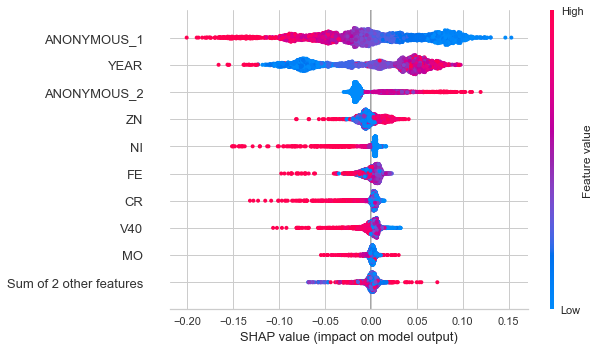

In [340]:
explainer_cat = shap.Explainer(clf_cat4)
shap_values_cat = explainer_cat(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_cat)

In [341]:
fi_cat = pd.DataFrame(clf_cat4.feature_importances_, index=X_train4.columns, columns=['feature_importance_cat']).sort_values('feature_importance_cat', ascending=False)
fi_cat

feature_importance_cat
YEAR                      23.052460
ANONYMOUS_1               22.545318
ANONYMOUS_2                8.423307
ZN                         7.133835
V40                        7.001262
FE                         6.562764
CR                         5.914745
NI                         5.171471
CU                         5.109294
PQINDEX                    4.707956
MO                         4.377588

In [342]:
fi_cat['feature_importance_cat'] = fi_cat['feature_importance_cat'] / fi_cat['feature_importance_cat'].sum()
fi_cat

feature_importance_cat
YEAR                       0.230525
ANONYMOUS_1                0.225453
ANONYMOUS_2                0.084233
ZN                         0.071338
V40                        0.070013
FE                         0.065628
CR                         0.059147
NI                         0.051715
CU                         0.051093
PQINDEX                    0.047080
MO                         0.043776

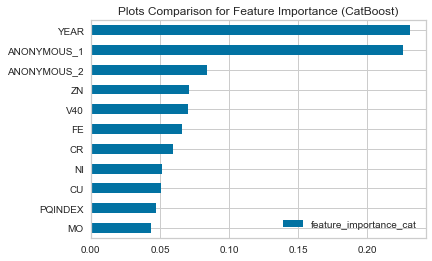

In [343]:
fi_cat[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (CatBoost)')
plt.show()

### Extra Tree

In [275]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyET = optuna.create_study(direction='minimize')

# n_trials 지정
studyET.optimize(lambda trial: objectiveET(trial, X_train4, y_train4, X_test, y_test), n_trials=100) 

print('study.best_params:', studyET.best_trial.value)
print('Number of finished trials:', len(studyET.trials))
print('Best trial:', studyET.best_trial.params)
print('study.best_params:', studyET.best_params)

[I 2022-12-09 00:27:02,328] A new study created in memory with name: no-name-c8ee5d2f-910c-4244-89f1-cea25603a231
[I 2022-12-09 00:27:02,564] Trial 0 finished with value: 0.23702022854549099 and parameters: {'max_depth': 3, 'max_leaf_nodes': 74, 'n_estimators': 196}. Best is trial 0 with value: 0.23702022854549099.
[I 2022-12-09 00:27:03,215] Trial 1 finished with value: 0.22132780157221782 and parameters: {'max_depth': 8, 'max_leaf_nodes': 865, 'n_estimators': 263}. Best is trial 1 with value: 0.22132780157221782.
[I 2022-12-09 00:27:03,873] Trial 2 finished with value: 0.22285454609990163 and parameters: {'max_depth': 7, 'max_leaf_nodes': 260, 'n_estimators': 286}. Best is trial 1 with value: 0.22132780157221782.
[I 2022-12-09 00:27:04,157] Trial 3 finished with value: 0.2382755022485237 and parameters: {'max_depth': 13, 'max_leaf_nodes': 5, 'n_estimators': 231}. Best is trial 1 with value: 0.22132780157221782.
[I 2022-12-09 00:27:05,077] Trial 4 finished with value: 0.22507899661895

[I 2022-12-09 00:27:50,933] Trial 38 finished with value: 0.2198795019235521 and parameters: {'max_depth': 13, 'max_leaf_nodes': 189, 'n_estimators': 434}. Best is trial 37 with value: 0.2196881027219076.
[I 2022-12-09 00:27:52,634] Trial 39 finished with value: 0.2198696349102994 and parameters: {'max_depth': 13, 'max_leaf_nodes': 178, 'n_estimators': 473}. Best is trial 37 with value: 0.2196881027219076.
[I 2022-12-09 00:27:54,123] Trial 40 finished with value: 0.22032642210689887 and parameters: {'max_depth': 13, 'max_leaf_nodes': 150, 'n_estimators': 479}. Best is trial 37 with value: 0.2196881027219076.
[I 2022-12-09 00:27:55,697] Trial 41 finished with value: 0.21991439738269938 and parameters: {'max_depth': 13, 'max_leaf_nodes': 182, 'n_estimators': 439}. Best is trial 37 with value: 0.2196881027219076.
[I 2022-12-09 00:27:57,192] Trial 42 finished with value: 0.21977650336251117 and parameters: {'max_depth': 13, 'max_leaf_nodes': 201, 'n_estimators': 435}. Best is trial 37 with

[I 2022-12-09 00:28:25,332] Trial 76 finished with value: 0.21944454455266563 and parameters: {'max_depth': 12, 'max_leaf_nodes': 287, 'n_estimators': 257}. Best is trial 74 with value: 0.21939393059748208.
[I 2022-12-09 00:28:26,469] Trial 77 finished with value: 0.2204897868471575 and parameters: {'max_depth': 11, 'max_leaf_nodes': 356, 'n_estimators': 262}. Best is trial 74 with value: 0.21939393059748208.
[I 2022-12-09 00:28:27,456] Trial 78 finished with value: 0.2196942685480427 and parameters: {'max_depth': 13, 'max_leaf_nodes': 325, 'n_estimators': 231}. Best is trial 74 with value: 0.21939393059748208.
[I 2022-12-09 00:28:30,191] Trial 79 finished with value: 0.21951258763286538 and parameters: {'max_depth': 13, 'max_leaf_nodes': 288, 'n_estimators': 496}. Best is trial 74 with value: 0.21939393059748208.
[I 2022-12-09 00:28:34,263] Trial 80 finished with value: 0.21996049798525097 and parameters: {'max_depth': 13, 'max_leaf_nodes': 388, 'n_estimators': 497}. Best is trial 74 

study.best_params: 0.21939393059748208
Number of finished trials: 100
Best trial: {'max_depth': 12, 'max_leaf_nodes': 279, 'n_estimators': 491}
study.best_params: {'max_depth': 12, 'max_leaf_nodes': 279, 'n_estimators': 491}


In [276]:
param_et = studyET.best_params

clf_et = ExtraTreesRegressor(**param_et, random_state=42)

In [277]:
clf_et.fit(X_train4, y_train4)

pred_test_et = clf_et.predict(X_test)

y_test['pred_et'] = [labeling(pred, threshold=0.6) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.2194
F1 Score : 0.2249
Macro F1 Score : 0.5757 

[[2385  197]
 [ 182   55]]


In [278]:
optuna.visualization.plot_param_importances(studyET)

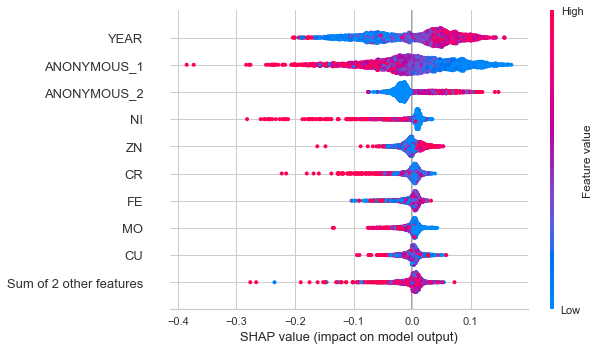

In [279]:
explainer_et = shap.Explainer(clf_et)
shap_values_et = explainer_et(X_train4)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_et)

In [280]:
fi_et = pd.DataFrame(clf_et.feature_importances_, index=X_train4.columns, columns=['feature_importance_et']).sort_values('feature_importance_et', ascending=False)
fi_et

feature_importance_et
ANONYMOUS_1               0.188912
YEAR                      0.168856
CR                        0.077877
CU                        0.077059
FE                        0.076530
ZN                        0.074252
V40                       0.074001
PQINDEX                   0.071097
ANONYMOUS_2               0.064241
NI                        0.064199
MO                        0.062977

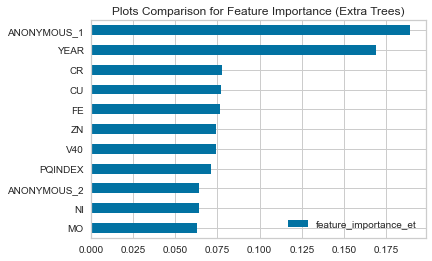

In [281]:
fi_et[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Extra Trees)')
plt.show()

## Dataset 5

### Decision Tree

In [282]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyDT=optuna.create_study(direction='minimize')

# n_trials 지정
studyDT.optimize(lambda trial: objectiveDT(trial, X_train5, y_train5, X_test, y_test), n_trials=100) 

print('study.best_params:', studyDT.best_trial.value)
print('Number of finished trials:', len(studyDT.trials))
print('Best trial:', studyDT.best_trial.params)
print('study.best_params:', studyDT.best_params)

[I 2022-12-09 00:36:51,605] A new study created in memory with name: no-name-af3f0190-7f93-4772-b9ff-761585895bf9
[I 2022-12-09 00:36:51,620] Trial 0 finished with value: 0.2302118918276902 and parameters: {'max_depth': 7, 'max_leaf_nodes': 192}. Best is trial 0 with value: 0.2302118918276902.
[I 2022-12-09 00:36:51,629] Trial 1 finished with value: 0.22758425358135412 and parameters: {'max_depth': 4, 'max_leaf_nodes': 28}. Best is trial 1 with value: 0.22758425358135412.
[I 2022-12-09 00:36:51,644] Trial 2 finished with value: 0.22713425880902796 and parameters: {'max_depth': 11, 'max_leaf_nodes': 193}. Best is trial 2 with value: 0.22713425880902796.
[I 2022-12-09 00:36:51,652] Trial 3 finished with value: 0.22758425358135412 and parameters: {'max_depth': 4, 'max_leaf_nodes': 955}. Best is trial 2 with value: 0.22713425880902796.
[I 2022-12-09 00:36:51,670] Trial 4 finished with value: 0.2332121986569455 and parameters: {'max_depth': 13, 'max_leaf_nodes': 329}. Best is trial 2 with v

[I 2022-12-09 00:36:52,530] Trial 41 finished with value: 0.22164345341761812 and parameters: {'max_depth': 13, 'max_leaf_nodes': 125}. Best is trial 31 with value: 0.2190246588658119.
[I 2022-12-09 00:36:52,561] Trial 42 finished with value: 0.22243068863149937 and parameters: {'max_depth': 13, 'max_leaf_nodes': 56}. Best is trial 31 with value: 0.2190246588658119.
[I 2022-12-09 00:36:52,605] Trial 43 finished with value: 0.2354125632408996 and parameters: {'max_depth': 13, 'max_leaf_nodes': 833}. Best is trial 31 with value: 0.2190246588658119.
[I 2022-12-09 00:36:52,641] Trial 44 finished with value: 0.21947766484994624 and parameters: {'max_depth': 12, 'max_leaf_nodes': 102}. Best is trial 31 with value: 0.2190246588658119.
[I 2022-12-09 00:36:52,689] Trial 45 finished with value: 0.23019693985115633 and parameters: {'max_depth': 12, 'max_leaf_nodes': 990}. Best is trial 31 with value: 0.2190246588658119.
[I 2022-12-09 00:36:52,727] Trial 46 finished with value: 0.2291517402892815 

[I 2022-12-09 00:36:53,844] Trial 83 finished with value: 0.22417790182576933 and parameters: {'max_depth': 12, 'max_leaf_nodes': 42}. Best is trial 69 with value: 0.21869330968128725.
[I 2022-12-09 00:36:53,883] Trial 84 finished with value: 0.21907739704902282 and parameters: {'max_depth': 13, 'max_leaf_nodes': 76}. Best is trial 69 with value: 0.21869330968128725.
[I 2022-12-09 00:36:53,919] Trial 85 finished with value: 0.22122113110392427 and parameters: {'max_depth': 12, 'max_leaf_nodes': 61}. Best is trial 69 with value: 0.21869330968128725.
[I 2022-12-09 00:36:53,951] Trial 86 finished with value: 0.22291029376639943 and parameters: {'max_depth': 13, 'max_leaf_nodes': 137}. Best is trial 69 with value: 0.21869330968128725.
[I 2022-12-09 00:36:53,971] Trial 87 finished with value: 0.24495855920755977 and parameters: {'max_depth': 11, 'max_leaf_nodes': 2}. Best is trial 69 with value: 0.21869330968128725.
[I 2022-12-09 00:36:54,009] Trial 88 finished with value: 0.230196939851156

study.best_params: 0.21869330968128725
Number of finished trials: 100
Best trial: {'max_depth': 12, 'max_leaf_nodes': 82}
study.best_params: {'max_depth': 12, 'max_leaf_nodes': 82}


In [283]:
param_dt = studyDT.best_params

clf_dt = DecisionTreeRegressor(**param_dt, random_state=42)

In [284]:
clf_dt.fit(X_train5, y_train5)

pred_test_dt = clf_dt.predict(X_test)

y_test['pred_dt'] = [labeling(pred, threshold=0.6) for pred in pred_test_dt]

print('MAE :', round(mean_absolute_error(pred_test_dt, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_dt, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_dt, y_test.Y_LABEL))

MAE : 0.2187
F1 Score : 0.1869
Macro F1 Score : 0.5441 

[[2266  195]
 [ 301   57]]


In [285]:
optuna.visualization.plot_param_importances(studyDT)

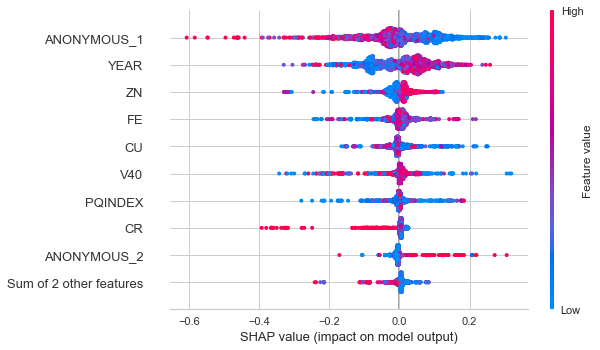

In [286]:
explainer_dt = shap.Explainer(clf_dt)
shap_values_dt = explainer_dt(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_dt)

In [287]:
fi_dt = pd.DataFrame(clf_dt.feature_importances_, index=X_train5.columns, columns=['feature_importance_dt']).sort_values('feature_importance_dt', ascending=False)
fi_dt

feature_importance_dt
ANONYMOUS_1               0.308080
YEAR                      0.140000
V40                       0.116837
FE                        0.087595
PQINDEX                   0.078514
ZN                        0.077817
CU                        0.063065
CR                        0.050910
ANONYMOUS_2               0.033155
MO                        0.028680
NI                        0.015348

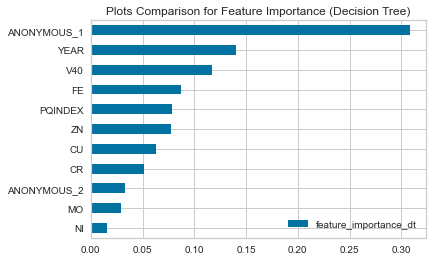

In [288]:
fi_dt[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Decision Tree)')
plt.show()

### SVR

In [289]:
# MAE가 최소가 되는 방향으로 학습을 진행
studySVR=optuna.create_study(direction='minimize')

# n_trials 지정
studySVR.optimize(lambda trial: objectiveSVR(trial, X_train5, y_train5, X_test, y_test), n_trials=100) 

print('study.best_params:', studySVR.best_trial.value)
print('Number of finished trials:', len(studySVR.trials))
print('Best trial:', studySVR.best_trial.params)
print('study.best_params:', studySVR.best_params)

[I 2022-12-09 00:38:21,651] A new study created in memory with name: no-name-b119cbb6-c82c-4251-9dc0-b19caae53786
[I 2022-12-09 00:38:22,652] Trial 0 finished with value: 0.3180232167841333 and parameters: {'C': 0.34113871820077835, 'degree': 3, 'gamma': 0.008330066442074874, 'epsilon': 0.3105742657871638}. Best is trial 0 with value: 0.3180232167841333.
[I 2022-12-09 00:38:24,142] Trial 1 finished with value: 0.2300788190742268 and parameters: {'C': 3.675300745353306, 'degree': 4, 'gamma': 0.004799634051684804, 'epsilon': 0.18034841065176677}. Best is trial 1 with value: 0.2300788190742268.
[I 2022-12-09 00:38:25,465] Trial 2 finished with value: 0.39115096876347044 and parameters: {'C': 3.9598890790248795, 'degree': 7, 'gamma': 0.008698479486782857, 'epsilon': 0.4165561363575771}. Best is trial 1 with value: 0.2300788190742268.
[I 2022-12-09 00:38:26,677] Trial 3 finished with value: 0.23170223686587116 and parameters: {'C': 1.2259373596569747, 'degree': 5, 'gamma': 0.002233181152819

[I 2022-12-09 00:39:02,654] Trial 32 finished with value: 0.136322374866361 and parameters: {'C': 0.40903623379435594, 'degree': 2, 'gamma': 0.001798546898074823, 'epsilon': 0.08741010361174376}. Best is trial 26 with value: 0.1086651838023415.
[I 2022-12-09 00:39:03,735] Trial 33 finished with value: 0.16342719806828296 and parameters: {'C': 0.5146665584146434, 'degree': 7, 'gamma': 0.0014080861825790224, 'epsilon': 0.12306950567687722}. Best is trial 26 with value: 0.1086651838023415.
[I 2022-12-09 00:39:04,837] Trial 34 finished with value: 0.22122924105573202 and parameters: {'C': 0.37565008914479764, 'degree': 6, 'gamma': 0.002192568415828498, 'epsilon': 0.19380893688197595}. Best is trial 26 with value: 0.1086651838023415.
[I 2022-12-09 00:39:05,958] Trial 35 finished with value: 0.1228352426168362 and parameters: {'C': 0.301059665696928, 'degree': 5, 'gamma': 0.0017999638084218175, 'epsilon': 0.07110413652101542}. Best is trial 26 with value: 0.1086651838023415.
[I 2022-12-09 00

[I 2022-12-09 00:39:46,143] Trial 64 finished with value: 0.13280215790270913 and parameters: {'C': 0.6061447732745636, 'degree': 4, 'gamma': 0.0011665737605929675, 'epsilon': 0.0843292614626669}. Best is trial 51 with value: 0.10822034759468391.
[I 2022-12-09 00:39:47,832] Trial 65 finished with value: 0.15336069382527692 and parameters: {'C': 0.7293443493252526, 'degree': 3, 'gamma': 0.0013081466721387865, 'epsilon': 0.10938099807499053}. Best is trial 51 with value: 0.10822034759468391.
[I 2022-12-09 00:39:49,151] Trial 66 finished with value: 0.11937583500160905 and parameters: {'C': 0.40384758977967006, 'degree': 5, 'gamma': 0.0016986032433256016, 'epsilon': 0.06522786853705093}. Best is trial 51 with value: 0.10822034759468391.
[I 2022-12-09 00:39:50,503] Trial 67 finished with value: 0.1321335654466834 and parameters: {'C': 0.4866226788949973, 'degree': 2, 'gamma': 0.001512493670702305, 'epsilon': 0.08252488392282031}. Best is trial 51 with value: 0.10822034759468391.
[I 2022-12

[I 2022-12-09 00:40:25,048] Trial 96 finished with value: 0.10763651441757235 and parameters: {'C': 0.4267701028982267, 'degree': 4, 'gamma': 0.0013380313500512336, 'epsilon': 0.050096565310217424}. Best is trial 91 with value: 0.1065155544613145.
[I 2022-12-09 00:40:26,356] Trial 97 finished with value: 0.12531114165654536 and parameters: {'C': 0.41680804595154775, 'degree': 4, 'gamma': 0.0011846830067217392, 'epsilon': 0.07536319980681255}. Best is trial 91 with value: 0.1065155544613145.
[I 2022-12-09 00:40:27,931] Trial 98 finished with value: 0.1441249788188862 and parameters: {'C': 0.4600212693070272, 'degree': 4, 'gamma': 0.004243343891904755, 'epsilon': 0.08710048580387156}. Best is trial 91 with value: 0.1065155544613145.
[I 2022-12-09 00:40:28,669] Trial 99 finished with value: 0.3727056244075481 and parameters: {'C': 0.32575413418079363, 'degree': 4, 'gamma': 0.0014511962316540307, 'epsilon': 0.3859355935385024}. Best is trial 91 with value: 0.1065155544613145.


study.best_params: 0.1065155544613145
Number of finished trials: 100
Best trial: {'C': 0.32264428806366113, 'degree': 4, 'gamma': 0.0011104033733311336, 'epsilon': 0.05037390202058798}
study.best_params: {'C': 0.32264428806366113, 'degree': 4, 'gamma': 0.0011104033733311336, 'epsilon': 0.05037390202058798}


In [290]:
param_svr = studySVR.best_params

clf_svr = SVR(**param_svr)

In [291]:
clf_svr.fit(X_train5, y_train5)

pred_test_svr = clf_svr.predict(X_test)

y_test['pred_svr'] = [labeling(pred, threshold=0.6) for pred in pred_test_svr]

print('MAE :', round(mean_absolute_error(pred_test_svr, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_svr, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_svr, y_test.Y_LABEL))

MAE : 0.1065
F1 Score : 0.0
Macro F1 Score : 0.4762 

[[2563  252]
 [   4    0]]


In [292]:
optuna.visualization.plot_param_importances(studySVR)

### Random Forest Regressor

In [293]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyRF=optuna.create_study(direction='minimize')

# n_trials 지정
studyRF.optimize(lambda trial: objectiveRF(trial, X_train5, y_train5, X_test, y_test), n_trials=100) 

print('study.best_params:', studyRF.best_trial.value)
print('Number of finished trials:', len(studyRF.trials))
print('Best trial:', studyRF.best_trial.params)
print('study.best_params:', studyRF.best_params)

[I 2022-12-09 00:41:23,020] A new study created in memory with name: no-name-3dfa1469-f4bf-491c-9062-d64ed0c3b6eb
[I 2022-12-09 00:41:24,048] Trial 0 finished with value: 0.22327875527833266 and parameters: {'max_depth': 13, 'max_leaf_nodes': 404, 'n_estimators': 90}. Best is trial 0 with value: 0.22327875527833266.
[I 2022-12-09 00:41:24,837] Trial 1 finished with value: 0.21945559205669635 and parameters: {'max_depth': 10, 'max_leaf_nodes': 347, 'n_estimators': 71}. Best is trial 1 with value: 0.21945559205669635.
[I 2022-12-09 00:41:28,090] Trial 2 finished with value: 0.22362167767316957 and parameters: {'max_depth': 12, 'max_leaf_nodes': 326, 'n_estimators': 290}. Best is trial 1 with value: 0.21945559205669635.
[I 2022-12-09 00:41:29,850] Trial 3 finished with value: 0.2230820015946253 and parameters: {'max_depth': 5, 'max_leaf_nodes': 711, 'n_estimators': 327}. Best is trial 1 with value: 0.21945559205669635.
[I 2022-12-09 00:41:33,638] Trial 4 finished with value: 0.22097222143

[I 2022-12-09 00:42:53,715] Trial 37 finished with value: 0.2187222857654873 and parameters: {'max_depth': 12, 'max_leaf_nodes': 75, 'n_estimators': 384}. Best is trial 36 with value: 0.21833699311594065.
[I 2022-12-09 00:43:01,125] Trial 38 finished with value: 0.22480514413809868 and parameters: {'max_depth': 13, 'max_leaf_nodes': 385, 'n_estimators': 425}. Best is trial 36 with value: 0.21833699311594065.
[I 2022-12-09 00:43:07,397] Trial 39 finished with value: 0.22259325973309577 and parameters: {'max_depth': 12, 'max_leaf_nodes': 275, 'n_estimators': 455}. Best is trial 36 with value: 0.21833699311594065.
[I 2022-12-09 00:43:11,468] Trial 40 finished with value: 0.2224176038157536 and parameters: {'max_depth': 11, 'max_leaf_nodes': 715, 'n_estimators': 303}. Best is trial 36 with value: 0.21833699311594065.
[I 2022-12-09 00:43:15,738] Trial 41 finished with value: 0.2181538288886968 and parameters: {'max_depth': 13, 'max_leaf_nodes': 112, 'n_estimators': 333}. Best is trial 41 wi

[I 2022-12-09 00:45:16,965] Trial 75 finished with value: 0.218192824930611 and parameters: {'max_depth': 12, 'max_leaf_nodes': 107, 'n_estimators': 464}. Best is trial 63 with value: 0.21802289190773924.
[I 2022-12-09 00:45:22,854] Trial 76 finished with value: 0.22468451809901804 and parameters: {'max_depth': 13, 'max_leaf_nodes': 917, 'n_estimators': 467}. Best is trial 63 with value: 0.21802289190773924.
[I 2022-12-09 00:45:25,162] Trial 77 finished with value: 0.2217599567912247 and parameters: {'max_depth': 6, 'max_leaf_nodes': 255, 'n_estimators': 335}. Best is trial 63 with value: 0.21802289190773924.
[I 2022-12-09 00:45:28,414] Trial 78 finished with value: 0.2222194355796437 and parameters: {'max_depth': 12, 'max_leaf_nodes': 24, 'n_estimators': 491}. Best is trial 63 with value: 0.21802289190773924.
[I 2022-12-09 00:45:32,299] Trial 79 finished with value: 0.21835180471723548 and parameters: {'max_depth': 13, 'max_leaf_nodes': 118, 'n_estimators': 381}. Best is trial 63 with

study.best_params: 0.21735805321781443
Number of finished trials: 100
Best trial: {'max_depth': 13, 'max_leaf_nodes': 106, 'n_estimators': 232}
study.best_params: {'max_depth': 13, 'max_leaf_nodes': 106, 'n_estimators': 232}


In [294]:
param_rf = studyRF.best_params

clf_rf = RandomForestRegressor(**param_rf, random_state=42)

In [295]:
clf_rf.fit(X_train5, y_train5)

pred_test_rf = clf_rf.predict(X_test)

y_test['pred_rf'] = [labeling(pred, threshold=0.6) for pred in pred_test_rf]

print('MAE :', round(mean_absolute_error(pred_test_rf, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_rf, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_rf, y_test.Y_LABEL))

MAE : 0.2174
F1 Score : 0.2143
Macro F1 Score : 0.5686 

[[2369  198]
 [ 198   54]]


In [296]:
optuna.visualization.plot_param_importances(studyRF)

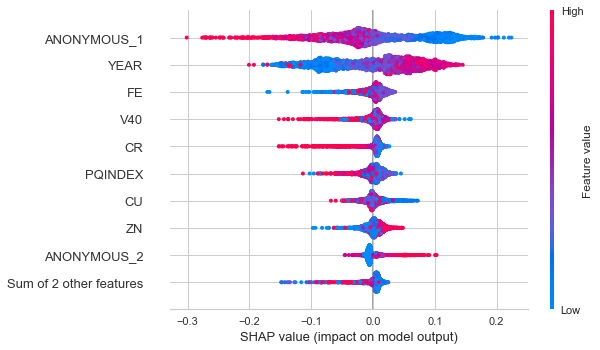

In [297]:
explainer_rf = shap.Explainer(clf_rf)
shap_values_rf = explainer_rf(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_rf)

In [298]:
fi_rf = pd.DataFrame(clf_rf.feature_importances_, index=X_train5.columns, columns=['feature_importance_rf']).sort_values('feature_importance_rf', ascending=False)
fi_rf

feature_importance_rf
ANONYMOUS_1               0.228647
YEAR                      0.122702
V40                       0.114704
PQINDEX                   0.097105
FE                        0.095871
ZN                        0.095226
CU                        0.081763
CR                        0.053924
MO                        0.046628
ANONYMOUS_2               0.037269
NI                        0.026159

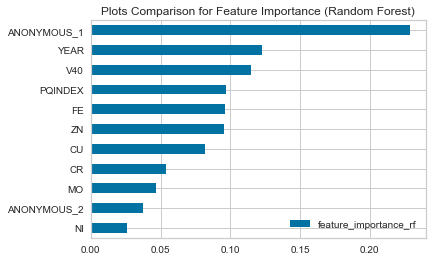

In [299]:
fi_rf[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Random Forest)')
plt.show()

### XGBRegressor

In [300]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyXGB=optuna.create_study(direction='minimize')

# n_trials 지정
studyXGB.optimize(lambda trial: objectiveXGB(trial, X_train5, y_train5, X_test, y_test), n_trials=100) 

print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)
print('study.best_params:', studyXGB.best_params)

[I 2022-12-09 00:49:01,387] A new study created in memory with name: no-name-02cddcd9-2d48-4d26-a5e6-6fd788a9488c
[I 2022-12-09 00:49:02,194] Trial 0 finished with value: 0.45402760263573577 and parameters: {'objective': 'reg:squarederror', 'max_depth': 13, 'learning_rate': 0.00010028830280337608, 'n_estimators': 389, 'subsample': 0.963624305391751, 'min_child_weight': 299, 'alpha': 0.012114032206757462}. Best is trial 0 with value: 0.45402760263573577.
[I 2022-12-09 00:49:02,549] Trial 1 finished with value: 0.459231855608462 and parameters: {'objective': 'reg:squarederror', 'max_depth': 7, 'learning_rate': 0.00011523638277150357, 'n_estimators': 142, 'subsample': 0.9208767843630187, 'min_child_weight': 138, 'alpha': 1.3784299136476204}. Best is trial 0 with value: 0.45402760263573577.
[I 2022-12-09 00:49:03,115] Trial 2 finished with value: 0.4503125696035935 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.00031725582775704586, 'n_estimators': 17

[I 2022-12-09 00:49:30,780] Trial 23 finished with value: 0.4159856779974375 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.0005270842788643495, 'n_estimators': 423, 'subsample': 0.7713918565798171, 'min_child_weight': 178, 'alpha': 0.0210138405757197}. Best is trial 17 with value: 0.2286507478233769.
[I 2022-12-09 00:49:32,286] Trial 24 finished with value: 0.3133235629335115 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.0021677197840152653, 'n_estimators': 470, 'subsample': 0.853316525097153, 'min_child_weight': 240, 'alpha': 0.0010137979197916256}. Best is trial 17 with value: 0.2286507478233769.
[I 2022-12-09 00:49:34,239] Trial 25 finished with value: 0.22767201387400998 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.009042350802700777, 'n_estimators': 500, 'subsample': 0.8874956842782434, 'min_child_weight': 197, 'alpha': 0.0030927998162059915}. Best is trial 25 wi

[I 2022-12-09 00:50:11,770] Trial 46 finished with value: 0.3678107153719644 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.001085670236502242, 'n_estimators': 476, 'subsample': 0.8999409817752182, 'min_child_weight': 171, 'alpha': 0.0015759317459682733}. Best is trial 33 with value: 0.22703975302267262.
[I 2022-12-09 00:50:13,951] Trial 47 finished with value: 0.2668399340279942 and parameters: {'objective': 'reg:squarederror', 'max_depth': 12, 'learning_rate': 0.004810035472393876, 'n_estimators': 366, 'subsample': 0.7884969250776466, 'min_child_weight': 150, 'alpha': 0.0010625205036728686}. Best is trial 33 with value: 0.22703975302267262.
[I 2022-12-09 00:50:16,034] Trial 48 finished with value: 0.22841756515274575 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.009981133373761813, 'n_estimators': 454, 'subsample': 0.874937866317332, 'min_child_weight': 230, 'alpha': 0.006425244649506977}. Best is trial 33

[I 2022-12-09 00:50:51,933] Trial 69 finished with value: 0.3023645882611919 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 0.002484782589164669, 'n_estimators': 470, 'subsample': 0.7507330276273282, 'min_child_weight': 261, 'alpha': 0.0027265941370367133}. Best is trial 61 with value: 0.22651699298501393.
[I 2022-12-09 00:50:53,221] Trial 70 finished with value: 0.28092674936465056 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.003439898964641984, 'n_estimators': 428, 'subsample': 0.8331672856955122, 'min_child_weight': 167, 'alpha': 0.001379343676835569}. Best is trial 61 with value: 0.22651699298501393.
[I 2022-12-09 00:50:54,794] Trial 71 finished with value: 0.23081912126126716 and parameters: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.008643765797996415, 'n_estimators': 454, 'subsample': 0.8592919423596028, 'min_child_weight': 227, 'alpha': 0.00775113613452928}. Best is trial 61 w

[I 2022-12-09 00:51:21,752] Trial 92 finished with value: 0.25567300029611195 and parameters: {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.004741580388526764, 'n_estimators': 460, 'subsample': 0.832064888668726, 'min_child_weight': 283, 'alpha': 0.0016854743728069396}. Best is trial 61 with value: 0.22651699298501393.
[I 2022-12-09 00:51:23,008] Trial 93 finished with value: 0.22712387897696804 and parameters: {'objective': 'reg:squarederror', 'max_depth': 10, 'learning_rate': 0.009573259752827419, 'n_estimators': 491, 'subsample': 0.9473913787448269, 'min_child_weight': 224, 'alpha': 0.0026946056800382975}. Best is trial 61 with value: 0.22651699298501393.
[I 2022-12-09 00:51:24,186] Trial 94 finished with value: 0.24478431934297148 and parameters: {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 0.005248333417194402, 'n_estimators': 500, 'subsample': 0.9777445638147971, 'min_child_weight': 275, 'alpha': 0.005028471000475251}. Best is trial 61

study.best_params: 0.22651699298501393
Number of finished trials: 100
Best trial: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.009559033980377796, 'n_estimators': 487, 'subsample': 0.8127038561867209, 'min_child_weight': 164, 'alpha': 0.001581112171498993}
study.best_params: {'objective': 'reg:squarederror', 'max_depth': 11, 'learning_rate': 0.009559033980377796, 'n_estimators': 487, 'subsample': 0.8127038561867209, 'min_child_weight': 164, 'alpha': 0.001581112171498993}


In [301]:
param_xgb = studyXGB.best_params

clf_xgb = xgb.XGBRegressor(**param_xgb, random_state=42)

In [302]:
clf_xgb.fit(X_train5, y_train5)

pred_test_xgb = clf_xgb.predict(X_test)

y_test['pred_xgb'] = [labeling(pred, threshold=0.6) for pred in pred_test_xgb]

print('MAE :', round(mean_absolute_error(pred_test_xgb, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_xgb, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_xgb, y_test.Y_LABEL))

MAE : 0.2265
F1 Score : 0.2209
Macro F1 Score : 0.5734 

[[2384  198]
 [ 183   54]]


In [303]:
optuna.visualization.plot_param_importances(studyXGB)

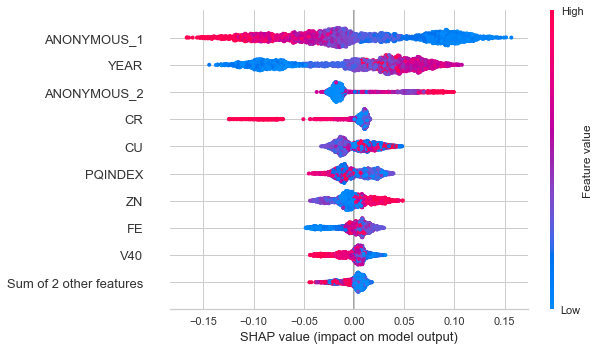

In [304]:
explainer_xgb = shap.Explainer(clf_xgb)
shap_values_xgb = explainer_xgb(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_xgb)

In [305]:
fi_xgb = pd.DataFrame(clf_xgb.feature_importances_, index=X_train5.columns, columns=['feature_importance_xgb']).sort_values('feature_importance_xgb', ascending=False)
fi_xgb

feature_importance_xgb
CR                         0.147945
YEAR                       0.140539
ANONYMOUS_1                0.129316
ANONYMOUS_2                0.107660
PQINDEX                    0.076570
NI                         0.071415
CU                         0.068200
FE                         0.067542
ZN                         0.066507
V40                        0.063626
MO                         0.060681

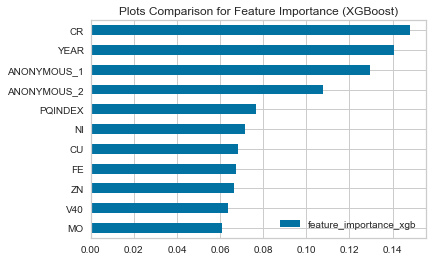

In [306]:
fi_xgb[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (XGBoost)')
plt.show()

### LGBM

In [307]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyLGBM = optuna.create_study(direction='minimize')

# n_trials 지정
studyLGBM.optimize(lambda trial: objectiveLGBM(trial, X_train5, y_train5, X_test, y_test), n_trials=100) 

print('study.best_params:', studyLGBM.best_trial.value)
print('Number of finished trials:', len(studyLGBM.trials))
print('Best trial:', studyLGBM.best_trial.params)
print('study.best_params:', studyLGBM.best_params)

[I 2022-12-09 00:53:08,890] A new study created in memory with name: no-name-63ff75c0-d768-4a13-94ab-031c4ae174f2
[I 2022-12-09 00:53:09,628] Trial 0 finished with value: 0.25058480351471557 and parameters: {'n_estimators': 408, 'reg_alpha': 0.006228028646934856, 'reg_lambda': 2.5878242848977147, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 5.655285928149358e-06, 'num_leaves': 128, 'min_child_samples': 46, 'min_data_per_groups': 68}. Best is trial 0 with value: 0.25058480351471557.
[I 2022-12-09 00:53:09,798] Trial 1 finished with value: 0.250624066287886 and parameters: {'n_estimators': 144, 'reg_alpha': 0.6395160997494848, 'reg_lambda': 0.0018430132765495655, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 9.59602089211843e-07, 'num_leaves': 32, 'min_child_samples': 116, 'min_data_per_groups': 98}. Best is trial 0 with value: 0.25058480351471557.
[I 2022-12-09 00:53:10,623] Trial 2 finished with value: 0.2506209285323608 and parameters: {'n_estimators': 154

[I 2022-12-09 00:53:23,834] Trial 21 finished with value: 0.22384428474894785 and parameters: {'n_estimators': 498, 'reg_alpha': 2.9126057770983365, 'reg_lambda': 0.012300284654133095, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009813963139658845, 'num_leaves': 512, 'min_child_samples': 97, 'min_data_per_groups': 7}. Best is trial 13 with value: 0.2232326042127787.
[I 2022-12-09 00:53:24,967] Trial 22 finished with value: 0.2250180872790551 and parameters: {'n_estimators': 461, 'reg_alpha': 3.217380399934326, 'reg_lambda': 0.009607255278214991, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.008148829822354705, 'num_leaves': 512, 'min_child_samples': 84, 'min_data_per_groups': 11}. Best is trial 13 with value: 0.2232326042127787.
[I 2022-12-09 00:53:25,848] Trial 23 finished with value: 0.2455469576631244 and parameters: {'n_estimators': 496, 'reg_alpha': 1.655419669679337, 'reg_lambda': 0.026007989988472657, 'colsample_bytree': 0.8, 'subsample': 1.0, '

[I 2022-12-09 00:53:41,719] Trial 42 finished with value: 0.22374557004960535 and parameters: {'n_estimators': 402, 'reg_alpha': 3.7996512885218077, 'reg_lambda': 0.02653045565164812, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.009926052758057429, 'num_leaves': 16, 'min_child_samples': 20, 'min_data_per_groups': 28}. Best is trial 39 with value: 0.22304767306338416.
[I 2022-12-09 00:53:42,349] Trial 43 finished with value: 0.23948158868583097 and parameters: {'n_estimators': 393, 'reg_alpha': 0.4415303769216801, 'reg_lambda': 0.035112979894156515, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.0016683384207240763, 'num_leaves': 16, 'min_child_samples': 18, 'min_data_per_groups': 34}. Best is trial 39 with value: 0.22304767306338416.
[I 2022-12-09 00:53:42,952] Trial 44 finished with value: 0.23047344340589002 and parameters: {'n_estimators': 416, 'reg_alpha': 4.666154197928153, 'reg_lambda': 0.06960577970359502, 'colsample_bytree': 0.7, 'subsample': 0.6

[I 2022-12-09 00:53:53,613] Trial 63 finished with value: 0.24070945150659864 and parameters: {'n_estimators': 482, 'reg_alpha': 0.040309770453469916, 'reg_lambda': 0.014954402312279715, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.0011752638066213632, 'num_leaves': 512, 'min_child_samples': 87, 'min_data_per_groups': 2}. Best is trial 39 with value: 0.22304767306338416.
[I 2022-12-09 00:53:54,359] Trial 64 finished with value: 0.22706987400266335 and parameters: {'n_estimators': 442, 'reg_alpha': 3.765963909464599, 'reg_lambda': 0.008802473201409452, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.006784592024934619, 'num_leaves': 512, 'min_child_samples': 79, 'min_data_per_groups': 12}. Best is trial 39 with value: 0.22304767306338416.
[I 2022-12-09 00:53:55,113] Trial 65 finished with value: 0.23639791482444303 and parameters: {'n_estimators': 490, 'reg_alpha': 1.1969828013639585, 'reg_lambda': 1.6374133164696676, 'colsample_bytree': 0.8, 'subsample': 

[I 2022-12-09 00:54:44,788] Trial 84 finished with value: 0.21713161833770814 and parameters: {'n_estimators': 414, 'reg_alpha': 0.011754945190191638, 'reg_lambda': 5.339110618060145, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.00611461973634902, 'num_leaves': 256, 'min_child_samples': 4, 'min_data_per_groups': 1}. Best is trial 73 with value: 0.2151123156834197.
[I 2022-12-09 00:54:48,204] Trial 85 finished with value: 0.22448769762175866 and parameters: {'n_estimators': 383, 'reg_alpha': 0.0210816841312609, 'reg_lambda': 7.096774770768495, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.003019466165854967, 'num_leaves': 256, 'min_child_samples': 2, 'min_data_per_groups': 1}. Best is trial 73 with value: 0.2151123156834197.
[I 2022-12-09 00:54:51,441] Trial 86 finished with value: 0.22087111063979165 and parameters: {'n_estimators': 411, 'reg_alpha': 0.003641623191396255, 'reg_lambda': 5.057597525172566, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learn

study.best_params: 0.2151123156834197
Number of finished trials: 100
Best trial: {'n_estimators': 398, 'reg_alpha': 0.034411479266898054, 'reg_lambda': 8.14315832774548, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009523658588728431, 'num_leaves': 256, 'min_child_samples': 4, 'min_data_per_groups': 10}
study.best_params: {'n_estimators': 398, 'reg_alpha': 0.034411479266898054, 'reg_lambda': 8.14315832774548, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009523658588728431, 'num_leaves': 256, 'min_child_samples': 4, 'min_data_per_groups': 10}


In [308]:
param_lgbm = studyLGBM.best_params

clf_lgbm = lgb.LGBMRegressor(**param_lgbm, max_depth=-1, random_state=42)

In [309]:
clf_lgbm.fit(X_train5, y_train5)

pred_test_lgbm = clf_lgbm.predict(X_test)

y_test['pred_lgbm'] = [labeling(pred, threshold=0.6) for pred in pred_test_lgbm]

print('MAE :', round(mean_absolute_error(pred_test_lgbm, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_lgbm, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_lgbm, y_test.Y_LABEL))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE : 0.2156
F1 Score : 0.2174
Macro F1 Score : 0.5623 

[[2286  187]
 [ 281   65]]


In [310]:
optuna.visualization.plot_param_importances(studyLGBM)

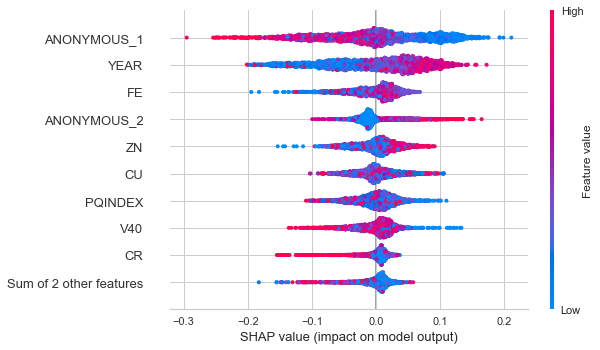

In [311]:
explainer_lgbm = shap.Explainer(clf_lgbm)
shap_values_lgbm = explainer_lgbm(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_lgbm)

In [312]:
fi_lgbm = pd.DataFrame(clf_lgbm.feature_importances_, index=X_train5.columns, columns=['feature_importance_lgbm']).sort_values('feature_importance_lgbm', ascending=False)
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                    15293
V40                            14162
ZN                             14113
FE                             12604
PQINDEX                        12491
CU                             10574
MO                              6663
YEAR                            6610
CR                              3897
ANONYMOUS_2                     3614
NI                              1448

In [313]:
fi_lgbm['feature_importance_lgbm'] = fi_lgbm['feature_importance_lgbm'] / fi_lgbm['feature_importance_lgbm'].sum()
fi_lgbm

feature_importance_lgbm
ANONYMOUS_1                 0.150716
V40                         0.139570
ZN                          0.139087
FE                          0.124215
PQINDEX                     0.123102
CU                          0.104209
MO                          0.065665
YEAR                        0.065143
CR                          0.038406
ANONYMOUS_2                 0.035617
NI                          0.014270

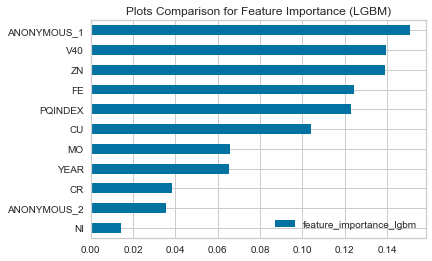

In [314]:
fi_lgbm[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (LGBM)')
plt.show()

### CatBoost

In [315]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyCB = optuna.create_study(direction='minimize')

# n_trials 지정
studyCB.optimize(lambda trial: objectiveCB(trial, X_train5, y_train5, X_test, y_test), n_trials=100) 

print('study.best_params:', studyCB.best_trial.value)
print('Number of finished trials:', len(studyCB.trials))
print('Best trial:', studyCB.best_trial.params)
print('study.best_params:', studyCB.best_params)

[I 2022-12-09 00:58:47,935] A new study created in memory with name: no-name-f78d8ab0-2ec8-4cef-9a5b-c791600e6fce
[I 2022-12-09 00:58:48,313] Trial 0 finished with value: 0.22805079275001452 and parameters: {'l2_leaf_reg': 0.05753571494348684, 'max_bin': 389, 'learning_rate': 0.017923385025196244, 'n_estimators': 371, 'max_depth': 3, 'min_data_in_leaf': 41}. Best is trial 0 with value: 0.22805079275001452.
[I 2022-12-09 00:58:52,887] Trial 1 finished with value: 0.22794998664441718 and parameters: {'l2_leaf_reg': 7.0007273962996805, 'max_bin': 372, 'learning_rate': 0.00825591490979949, 'n_estimators': 406, 'max_depth': 9, 'min_data_in_leaf': 109}. Best is trial 1 with value: 0.22794998664441718.
[I 2022-12-09 00:58:53,341] Trial 2 finished with value: 0.2284511522558589 and parameters: {'l2_leaf_reg': 0.8616694296104387, 'max_bin': 329, 'learning_rate': 0.01228877822881673, 'n_estimators': 491, 'max_depth': 3, 'min_data_in_leaf': 226}. Best is trial 1 with value: 0.22794998664441718.
[

[I 2022-12-09 01:00:52,728] Trial 27 finished with value: 0.2263062376273371 and parameters: {'l2_leaf_reg': 0.007482504527840034, 'max_bin': 303, 'learning_rate': 0.017199464816471343, 'n_estimators': 464, 'max_depth': 7, 'min_data_in_leaf': 135}. Best is trial 20 with value: 0.22625886726092437.
[I 2022-12-09 01:00:53,439] Trial 28 finished with value: 0.22768741049734398 and parameters: {'l2_leaf_reg': 0.0037471391429616608, 'max_bin': 309, 'learning_rate': 0.017357173076208966, 'n_estimators': 465, 'max_depth': 4, 'min_data_in_leaf': 299}. Best is trial 20 with value: 0.22625886726092437.
[I 2022-12-09 01:00:54,044] Trial 29 finished with value: 0.2282084312614771 and parameters: {'l2_leaf_reg': 0.0010200956030872255, 'max_bin': 397, 'learning_rate': 0.017989569455072, 'n_estimators': 358, 'max_depth': 3, 'min_data_in_leaf': 76}. Best is trial 20 with value: 0.22625886726092437.
[I 2022-12-09 01:00:56,434] Trial 30 finished with value: 0.22915365839923013 and parameters: {'l2_leaf_

[I 2022-12-09 01:01:25,746] Trial 54 finished with value: 0.22655461175743263 and parameters: {'l2_leaf_reg': 0.07020421636341967, 'max_bin': 337, 'learning_rate': 0.016468571662726604, 'n_estimators': 456, 'max_depth': 5, 'min_data_in_leaf': 94}. Best is trial 51 with value: 0.2257370263626795.
[I 2022-12-09 01:01:27,004] Trial 55 finished with value: 0.22681641739544958 and parameters: {'l2_leaf_reg': 0.04222441866166408, 'max_bin': 289, 'learning_rate': 0.017614935822818565, 'n_estimators': 434, 'max_depth': 8, 'min_data_in_leaf': 138}. Best is trial 51 with value: 0.2257370263626795.
[I 2022-12-09 01:01:27,624] Trial 56 finished with value: 0.22639203517418527 and parameters: {'l2_leaf_reg': 0.02146228160850931, 'max_bin': 346, 'learning_rate': 0.015869153267663694, 'n_estimators': 237, 'max_depth': 5, 'min_data_in_leaf': 119}. Best is trial 51 with value: 0.2257370263626795.
[I 2022-12-09 01:01:29,475] Trial 57 finished with value: 0.22772591473738954 and parameters: {'l2_leaf_reg

[I 2022-12-09 01:02:21,052] Trial 81 finished with value: 0.22743087091412167 and parameters: {'l2_leaf_reg': 1.4853598564284056, 'max_bin': 383, 'learning_rate': 0.016090767598212884, 'n_estimators': 392, 'max_depth': 8, 'min_data_in_leaf': 256}. Best is trial 51 with value: 0.2257370263626795.
[I 2022-12-09 01:02:23,173] Trial 82 finished with value: 0.2264957963159605 and parameters: {'l2_leaf_reg': 2.6173038231236836, 'max_bin': 363, 'learning_rate': 0.013670246411827078, 'n_estimators': 409, 'max_depth': 8, 'min_data_in_leaf': 242}. Best is trial 51 with value: 0.2257370263626795.
[I 2022-12-09 01:03:09,988] Trial 83 finished with value: 0.22855947364693455 and parameters: {'l2_leaf_reg': 1.1699347825233826, 'max_bin': 356, 'learning_rate': 0.012773054999598299, 'n_estimators': 395, 'max_depth': 13, 'min_data_in_leaf': 223}. Best is trial 51 with value: 0.2257370263626795.
[I 2022-12-09 01:03:14,390] Trial 84 finished with value: 0.22636087713751105 and parameters: {'l2_leaf_reg':

study.best_params: 0.22517512970081274
Number of finished trials: 100
Best trial: {'l2_leaf_reg': 0.04117389515813014, 'max_bin': 261, 'learning_rate': 0.013404843797928924, 'n_estimators': 256, 'max_depth': 8, 'min_data_in_leaf': 156}
study.best_params: {'l2_leaf_reg': 0.04117389515813014, 'max_bin': 261, 'learning_rate': 0.013404843797928924, 'n_estimators': 256, 'max_depth': 8, 'min_data_in_leaf': 156}


In [316]:
param_cat = studyCB.best_params

clf_cat = CatBoostRegressor(**param_cat, random_state=42)

In [317]:
clf_cat.fit(X_train5, y_train5)

pred_test_cat = clf_cat.predict(X_test)

y_test['pred_cat'] = [labeling(pred, threshold=0.6) for pred in pred_test_cat]

print('MAE :', round(mean_absolute_error(pred_test_cat, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_cat, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_cat, y_test.Y_LABEL))

0:	learn: 0.3806049	total: 4.82ms	remaining: 1.23s
1:	learn: 0.3800413	total: 9.4ms	remaining: 1.19s
2:	learn: 0.3794596	total: 14.3ms	remaining: 1.2s
3:	learn: 0.3789312	total: 19.4ms	remaining: 1.22s
4:	learn: 0.3783350	total: 24.7ms	remaining: 1.24s
5:	learn: 0.3777042	total: 29.7ms	remaining: 1.24s
6:	learn: 0.3771417	total: 34.9ms	remaining: 1.24s
7:	learn: 0.3766176	total: 40.2ms	remaining: 1.25s
8:	learn: 0.3761063	total: 45.5ms	remaining: 1.25s
9:	learn: 0.3756596	total: 51ms	remaining: 1.25s
10:	learn: 0.3750977	total: 56.1ms	remaining: 1.25s
11:	learn: 0.3745974	total: 61.3ms	remaining: 1.25s
12:	learn: 0.3740219	total: 66.3ms	remaining: 1.24s
13:	learn: 0.3735913	total: 71.6ms	remaining: 1.24s
14:	learn: 0.3731936	total: 76.7ms	remaining: 1.23s
15:	learn: 0.3727035	total: 81.9ms	remaining: 1.23s
16:	learn: 0.3722648	total: 87.3ms	remaining: 1.23s
17:	learn: 0.3718108	total: 92.6ms	remaining: 1.22s
18:	learn: 0.3714041	total: 97.7ms	remaining: 1.22s
19:	learn: 0.3709793	total

175:	learn: 0.3359019	total: 903ms	remaining: 410ms
176:	learn: 0.3357595	total: 908ms	remaining: 405ms
177:	learn: 0.3356672	total: 913ms	remaining: 400ms
178:	learn: 0.3355561	total: 919ms	remaining: 395ms
179:	learn: 0.3353729	total: 924ms	remaining: 390ms
180:	learn: 0.3352652	total: 930ms	remaining: 385ms
181:	learn: 0.3350909	total: 935ms	remaining: 380ms
182:	learn: 0.3348549	total: 941ms	remaining: 375ms
183:	learn: 0.3347088	total: 947ms	remaining: 370ms
184:	learn: 0.3345551	total: 953ms	remaining: 366ms
185:	learn: 0.3344607	total: 958ms	remaining: 361ms
186:	learn: 0.3342536	total: 964ms	remaining: 356ms
187:	learn: 0.3341017	total: 969ms	remaining: 351ms
188:	learn: 0.3338636	total: 974ms	remaining: 345ms
189:	learn: 0.3337733	total: 980ms	remaining: 340ms
190:	learn: 0.3336060	total: 985ms	remaining: 335ms
191:	learn: 0.3335267	total: 990ms	remaining: 330ms
192:	learn: 0.3333941	total: 995ms	remaining: 325ms
193:	learn: 0.3332470	total: 1000ms	remaining: 320ms
194:	learn:

In [318]:
optuna.visualization.plot_param_importances(studyCB)

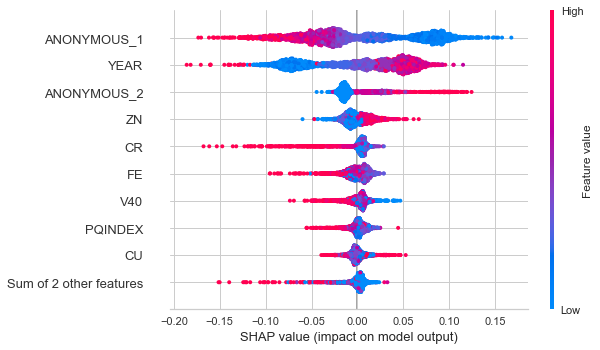

In [319]:
explainer_cat = shap.Explainer(clf_cat)
shap_values_cat = explainer_cat(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_cat)

In [320]:
fi_cat = pd.DataFrame(clf_cat.feature_importances_, index=X_train5.columns, columns=['feature_importance_cat']).sort_values('feature_importance_cat', ascending=False)
fi_cat

feature_importance_cat
ANONYMOUS_1               20.307326
YEAR                      19.691283
ANONYMOUS_2                8.870713
FE                         8.149836
ZN                         8.074224
V40                        7.359848
CR                         6.732751
CU                         6.504269
PQINDEX                    6.140288
MO                         4.799281
NI                         3.370182

In [321]:
fi_cat['feature_importance_cat'] = fi_cat['feature_importance_cat'] / fi_cat['feature_importance_cat'].sum()
fi_cat

feature_importance_cat
ANONYMOUS_1                0.203073
YEAR                       0.196913
ANONYMOUS_2                0.088707
FE                         0.081498
ZN                         0.080742
V40                        0.073598
CR                         0.067328
CU                         0.065043
PQINDEX                    0.061403
MO                         0.047993
NI                         0.033702

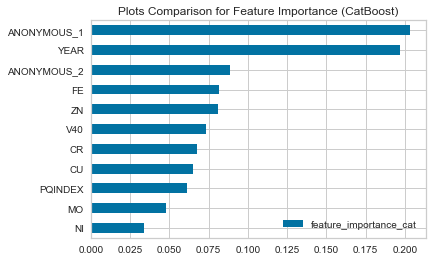

In [322]:
fi_cat[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (CatBoost)')
plt.show()

### Extra Tree

In [323]:
# MAE가 최소가 되는 방향으로 학습을 진행
studyET = optuna.create_study(direction='minimize')

# n_trials 지정
studyET.optimize(lambda trial: objectiveET(trial, X_train5, y_train5, X_test, y_test), n_trials=100) 

print('study.best_params:', studyET.best_trial.value)
print('Number of finished trials:', len(studyET.trials))
print('Best trial:', studyET.best_trial.params)
print('study.best_params:', studyET.best_params)

[I 2022-12-09 01:06:08,513] A new study created in memory with name: no-name-e84f4a50-73c8-431c-8518-bc48b4e1dce8
[I 2022-12-09 01:06:08,997] Trial 0 finished with value: 0.22970042786881023 and parameters: {'max_depth': 5, 'max_leaf_nodes': 839, 'n_estimators': 240}. Best is trial 0 with value: 0.22970042786881023.
[I 2022-12-09 01:06:09,334] Trial 1 finished with value: 0.22486542706289137 and parameters: {'max_depth': 7, 'max_leaf_nodes': 794, 'n_estimators': 129}. Best is trial 1 with value: 0.22486542706289137.
[I 2022-12-09 01:06:10,611] Trial 2 finished with value: 0.22242211247045313 and parameters: {'max_depth': 9, 'max_leaf_nodes': 938, 'n_estimators': 359}. Best is trial 2 with value: 0.22242211247045313.
[I 2022-12-09 01:06:11,210] Trial 3 finished with value: 0.2223683359135266 and parameters: {'max_depth': 10, 'max_leaf_nodes': 869, 'n_estimators': 157}. Best is trial 3 with value: 0.2223683359135266.
[I 2022-12-09 01:06:12,495] Trial 4 finished with value: 0.222332726460

[I 2022-12-09 01:06:44,643] Trial 37 finished with value: 0.22139845224848187 and parameters: {'max_depth': 12, 'max_leaf_nodes': 328, 'n_estimators': 220}. Best is trial 37 with value: 0.22139845224848187.
[I 2022-12-09 01:06:45,692] Trial 38 finished with value: 0.22250380802281006 and parameters: {'max_depth': 12, 'max_leaf_nodes': 442, 'n_estimators': 222}. Best is trial 37 with value: 0.22139845224848187.
[I 2022-12-09 01:06:46,105] Trial 39 finished with value: 0.2299105582793755 and parameters: {'max_depth': 5, 'max_leaf_nodes': 341, 'n_estimators': 212}. Best is trial 37 with value: 0.22139845224848187.
[I 2022-12-09 01:06:47,519] Trial 40 finished with value: 0.22233502859566587 and parameters: {'max_depth': 9, 'max_leaf_nodes': 359, 'n_estimators': 392}. Best is trial 37 with value: 0.22139845224848187.
[I 2022-12-09 01:06:48,319] Trial 41 finished with value: 0.22147296148035445 and parameters: {'max_depth': 13, 'max_leaf_nodes': 285, 'n_estimators': 187}. Best is trial 37 w

[I 2022-12-09 01:07:06,994] Trial 75 finished with value: 0.2206853893183538 and parameters: {'max_depth': 12, 'max_leaf_nodes': 200, 'n_estimators': 106}. Best is trial 75 with value: 0.2206853893183538.
[I 2022-12-09 01:07:07,171] Trial 76 finished with value: 0.23798512817781753 and parameters: {'max_depth': 3, 'max_leaf_nodes': 242, 'n_estimators': 101}. Best is trial 75 with value: 0.2206853893183538.
[I 2022-12-09 01:07:07,535] Trial 77 finished with value: 0.2207936571361028 and parameters: {'max_depth': 12, 'max_leaf_nodes': 203, 'n_estimators': 89}. Best is trial 75 with value: 0.2206853893183538.
[I 2022-12-09 01:07:07,872] Trial 78 finished with value: 0.2218906795015548 and parameters: {'max_depth': 12, 'max_leaf_nodes': 138, 'n_estimators': 90}. Best is trial 75 with value: 0.2206853893183538.
[I 2022-12-09 01:07:08,127] Trial 79 finished with value: 0.2208474197227562 and parameters: {'max_depth': 12, 'max_leaf_nodes': 171, 'n_estimators': 65}. Best is trial 75 with value

study.best_params: 0.22027961643854943
Number of finished trials: 100
Best trial: {'max_depth': 12, 'max_leaf_nodes': 192, 'n_estimators': 50}
study.best_params: {'max_depth': 12, 'max_leaf_nodes': 192, 'n_estimators': 50}


In [330]:
param_et = studyET.best_params

clf_et5 = ExtraTreesRegressor(**param_et, random_state=42)

In [331]:
clf_et5.fit(X_train5, y_train5)

pred_test_et = clf_et5.predict(X_test)

y_test['pred_et'] = [labeling(pred, threshold=0.6) for pred in pred_test_et]

print('MAE :', round(mean_absolute_error(pred_test_et, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_et, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_et, y_test.Y_LABEL))

MAE : 0.2203
F1 Score : 0.2189
Macro F1 Score : 0.5743 

[[2404  201]
 [ 163   51]]


In [332]:
optuna.visualization.plot_param_importances(studyET)

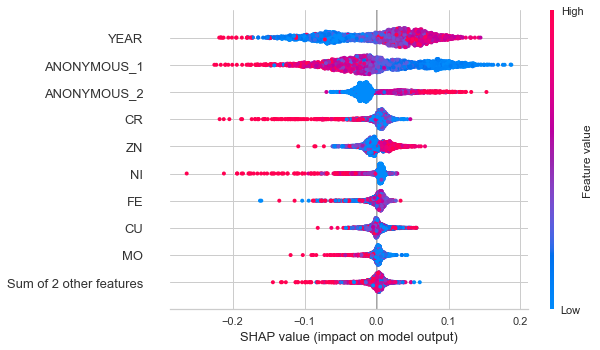

In [333]:
explainer_et = shap.Explainer(clf_et5)
shap_values_et = explainer_et(X_train5)

# SHAP 값 plot
shap.plots.beeswarm(shap_values_et)

In [334]:
fi_et = pd.DataFrame(clf_et5.feature_importances_, index=X_train5.columns, columns=['feature_importance_et']).sort_values('feature_importance_et', ascending=False)
fi_et

feature_importance_et
ANONYMOUS_1               0.192359
YEAR                      0.178111
CR                        0.085621
FE                        0.076344
CU                        0.072627
ANONYMOUS_2               0.071463
ZN                        0.071435
V40                       0.065837
MO                        0.063097
PQINDEX                   0.062137
NI                        0.060970

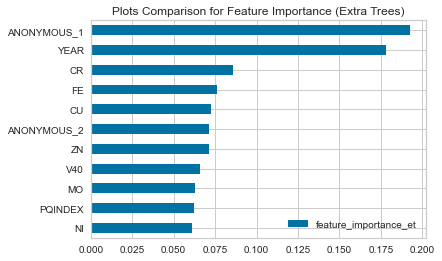

In [335]:
fi_et[::-1].plot(kind='barh', title='Plots Comparison for Feature Importance (Extra Trees)')
plt.show()

## Stacking

- Dataset 1 clf_et1  	{'max_depth': 12, 'max_leaf_nodes': 312, 'n_estimators': 222}

- Dataset 2 clf_cat2 	{'l2_leaf_reg': 0.06649448838397229, 'max_bin': 382, 'learning_rate': 0.013386842751462055, 'n_estimators': 426, 'max_depth': 8, 'min_data_in_leaf': 79}

- Dataset 3 clf_et3  	{'max_depth': 12, 'max_leaf_nodes': 330, 'n_estimators': 492}

- Dataset 4 clf_cat4 {'l2_leaf_reg': 0.6830597290675959, 'max_bin': 352, 'learning_rate': 0.011084218165963517, 'n_estimators': 367, 'max_depth': 7, 'min_data_in_leaf': 165}

- Dataset 5 clf_et5 	{'max_depth': 12, 'max_leaf_nodes': 192, 'n_estimators': 50}

### mean

In [344]:
pred_test_et1 = clf_et1.predict(X_test)
pred_test_cat2 = clf_cat2.predict(X_test)
pred_test_et3 = clf_et3.predict(X_test)
pred_test_cat4 = clf_cat4.predict(X_test)
pred_test_et5 = clf_et5.predict(X_test)

In [345]:
pred_test_stack = 0.2*pred_test_et1 + 0.2*pred_test_cat2 + 0.2*pred_test_et3 + 0.2*pred_test_cat4 + 0.2*pred_test_et5

y_test['pred_mean'] = [labeling(pred, threshold=0.6) for pred in pred_test_stack]

print('MAE :', round(mean_absolute_error(pred_test_stack, y_test.Score_0),4))
print('F1 Score :', competition_metric(y_test.pred_mean, y_test.Y_LABEL)[0])
print('Macro F1 Score :', competition_metric(y_test.pred_mean, y_test.Y_LABEL)[1], '\n')
print(confusion_matrix(y_test.pred_mean, y_test.Y_LABEL))

MAE : 0.22
F1 Score : 0.2181
Macro F1 Score : 0.5767 

[[2435  205]
 [ 132   47]]


### Submission

In [347]:
# Prediction
pred_test_real_et1 = clf_et1.predict(real_test)
pred_test_real_cat2 = clf_cat2.predict(real_test)
pred_test_real_et3 = clf_et3.predict(real_test)
pred_test_real_cat4 = clf_cat4.predict(real_test)
pred_test_real_et5 = clf_et5.predict(real_test)

# Stacking Mean
pred_test_real = 0.2*pred_test_real_et1 + 0.2*pred_test_real_cat2 + 0.2*pred_test_real_et3 + 0.2*pred_test_real_cat4 + 0.2*pred_test_real_et5

pred_test_real = [labeling(pred, threshold=0.6) for pred in pred_test_real]

In [353]:
submit = pd.read_csv('C:/Users/cdbre/Desktop/MyLife/DACON/data/sample_submission.csv')
submit['Y_LABEL'] = pred_test_real
submit.head()

ID  Y_LABEL
0  TEST_0000        0
1  TEST_0001        0
2  TEST_0002        0
3  TEST_0003        0
4  TEST_0004        0

In [354]:
submit.Y_LABEL.value_counts()  # 약 7.4 %

0    5589
1     452
Name: Y_LABEL, dtype: int64

In [356]:
submit.to_csv('C:/Users/cdbre/Desktop/MyLife/DACON/data/submit_down_mean4all.csv', index=False)